**Robot navigation in a maze**

Mark Nelson <mnelson@american.edu>, 12/2019

Set up folders to save images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd
!ls




/content/drive/My Drive/HardMazeEx/HardMazeEx
HardMazeEx  maze_0.png


In [ ]:
%cd drive/
!pwd

[Errno 2] No such file or directory: 'drive/'
/content/drive/My Drive/HardMazeEx/HardMazeEx
/content/drive/My Drive/HardMazeEx/HardMazeEx


In [ ]:
!pwd
%ls 

%cd drive/
%ls

%cd 'My Drive'
#%ls

!mkdir HardMazeEx
%cd HardMazeEx/

!pwd


/content/drive/My Drive/HardMazeEx/HardMazeEx
HardMazeEx/  maze_0.png
[Errno 2] No such file or directory: 'drive/'
/content/drive/My Drive/HardMazeEx/HardMazeEx
HardMazeEx/  maze_0.png
[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive/HardMazeEx/HardMazeEx
mkdir: cannot create directory ‘HardMazeEx’: File exists
/content/drive/My Drive/HardMazeEx/HardMazeEx/HardMazeEx
/content/drive/My Drive/HardMazeEx/HardMazeEx/HardMazeEx


## References

Adapted from:
* J. Lehman & K.O. Stanley (2011). Abandoning Objectives: Evolution Through the Search for Novelty Alone. *Evolutionary Computation* 19(2): 189-223. https://doi.org/10.1162/EVCO_a_00025.

In particular, the domain definition is based primarily on Figures 1-2 from that paper:

![Lehman & Stanley (2011), Figures 1-2](http://www.kmjn.org/temp/robotdomain.png)

## Visualization stuff

In [ ]:
import math
from PIL import Image, ImageDraw
from IPython.display import display

scalefactor = 40 # pixels per 'maze unit' for vis purposes
border = 5       # in pixels
markersize = 3   # in pixels, should be even
linewidth = 2    # in pixels

# convert world-space coordinate to pixel coordinate
def coord(x):
  if type(x) is list:
    return [coord(elem) for elem in x]
  elif type(x) is tuple:
    return tuple(coord(elem) for elem in x)
  else:
    return int(scalefactor*x) + border

# returns bounds for ImageDraw.Draw.ellipse()
def marker(x):
  return list(i - markersize for i in coord(x)) + list(i + markersize for i in coord(x))


def showmaze(m,i):
  width = m['dimensions'][0]
  height = m['dimensions'][1]
  img = Image.new("RGB", (int(width*scalefactor) + 2*border, int(height*scalefactor) + 2*border), 'white')
  img1 = ImageDraw.Draw(img)
  img1.rectangle(coord([0.0, 0.0, width, height]), None, 'black')
  img1.ellipse(marker(m['position']), 'black')
  img1.ellipse(marker(m['goal']), 'red')
  for obstacle in m['obstacles']:
    img1.line(coord(obstacle), 'black', linewidth)
  mazeNamePNG = "maze_" + str(i) + ".png"
  img.save(mazeNamePNG)
  display(img)
 

## Maze definitions

Test mazes from Lehman & Stanely (2011), Fig. 2.

"Medium" maze



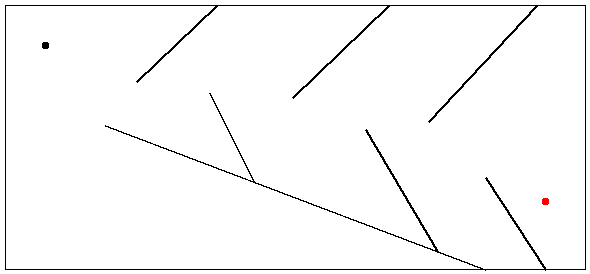

In [ ]:
mediumMaze = {
    'dimensions': (14.5, 6.6),

    # obstacles are lines specified as [(x1,y1),(x2,y2)],
    #   where (0,0) is the top-left corner of the world
    # the four walls around the world are implicit and don't need to be specified
    'obstacles': [[(2.5, 3.0),(12.0, 6.6)], [(5.1, 2.2), (6.2, 4.4)],
                  [(9.0, 3.1), (10.8, 6.15)], [(12.0, 4.3), (13.5, 6.6)],
                  [(3.3, 1.9), (5.3, 0.0)], [(7.2, 2.3), (9.6, 0.0)],
                  [(10.6, 2.9), (13.3, 0.0)]],
   
    'position': (1.0, 1.0),
    'heading': 0, # in radians. 0 is to the right (+x axis); increasing heading rotates clockwise
    'goal': (13.5, 4.9),
}

showmaze(mediumMaze,0)

"Hard" maze:

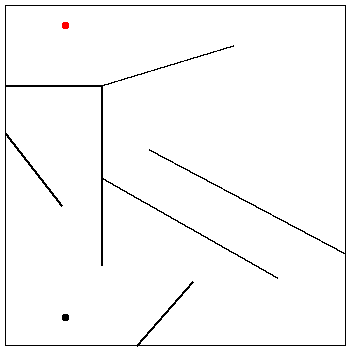

In [ ]:
hardMaze = {
    'dimensions': (8.5, 8.5),

    'obstacles': [[(0.0, 2.0), (2.4, 2.0)], [(2.4, 2.0), (5.7, 1.0)],
                  [(2.4, 2.0), (2.4, 6.5)], [(0.0, 3.2), (1.4, 5.0)],
                  [(2.4, 4.3), (6.8, 6.8)], [(3.3, 8.5), (4.7, 6.9)],
                  [(3.6, 3.6), (8.5, 6.2)]],
   
    'position': (1.5, 7.8),
    'heading': 0,
    'goal': (1.5, 0.5),
}

showmaze(hardMaze,0)

## Simulation parameters

In [ ]:
# robot max speed, in world units per timestep
speed = 0.1

# epsilon distance for considering goal reached, collisions, etc.
epsilon = 0.01
sqEpsilon = epsilon**2

# interval to update visualization
visInterval = 1

# max simulation timesteps
timeout = 400

## Controller

The controller can move forward/back along the current heading, and rotate left/right to change heading (based on my intepretation of Fig. 1 at the top of this notebook). At each timestep it should return a 2-tuple:
* Forward/back speed, in the range [-1.0,1.0]. Max speed (i.e. -1.0 or 1.0) is equal to the 'speed' simulation parameter above, and lower speeds are linearly scaled.
* Left/right rotation, in the range [-1.0, 1.0]. Max rotation in either direction is 180 degrees. 0.0 means continue on the current heading, -0.5 means turn 90 degrees to the left, etc.

The controller is given a 10-element list with current sensor readings (see Fig. 1 again):
* The first six rangefinder sensors give the distance to the nearest obstacle in the directions: left, left-front, front, right-front, front, and rear (relative to current heading).
* The last four wedge sensors will have exactly one of the four set to 1.0, and the others to 0.0. The one set to 1.0 indicates the 90-degree quadrant that the goal is in, relative to the current heading. The order of the quadrants is: left, front, right, back.

Random controller:

In [ ]:
import random
def randomController(sensors):
  # ignores sensors
  return (random.uniform(-1, 1), random.uniform(-1,1))

Go-straight controller:

In [ ]:
def goStraight(sensors):
  # ignores sensors
  return (1.0, 0.0)

A controller that goes mostly straight, but avoids walls, mostly to test use of the sensors:

In [ ]:
def goStraightAvoid(sensors):
  print(sensors)
  # go left-forward, forward, or right-forward, depending on which direction is furthest from obstacles
  if sensors[2] >= sensors[1] and sensors[2] >= sensors[3]:
    return (1.0, 0.0)        # go straight
  elif sensors[1] > sensors[3]:
    return (1.0, -0.25) # turn 45 degrees left
  return (1.0, 0.25)  # turn 45 degrees right

My ANN controller

In [ ]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [ ]:
# activation function 
def sigmoid(x): 
    return(1/(1 + np.exp(-x))) 

In [ ]:
# Creating the Feed forward neural network 
# 1 Input layer
# 1 hidden layer 
# 1 output layer
def f_forward(x, w1, w2): 
    # hidden 
    z1 = x.dot(w1)# input from layer 1  
    a1 = sigmoid(z1)# out put of layer 2  
      
    # Output layer 
    z2 = a1.dot(w2)# input of out layer 
    a2 = sigmoid(z2)# output of out layer 
    return(a2) 

In [ ]:

# initializing the weights randomly 
def generate_wt(x, y): 
    l =[] 
    for i in range(x * y): 
        l.append(np.random.randn()) 
    return(np.array(l).reshape(x, y)) 

In [ ]:
# for loss we will be using mean square error(MSE) 
def loss(out, Y): 
    s =(np.square(out-Y)) 
    s = np.sum(s)/len(y) 
    return(s) 
    

In [ ]:
# Back propagation of error  
def back_prop(x, y, w1, w2, alpha): 
      
    # hiden layer 
    z1 = x.dot(w1)# input from layer 1  
    a1 = sigmoid(z1)# output of layer 2  
      
    # Output layer 
    z2 = a1.dot(w2)# input of out layer 
    a2 = sigmoid(z2)# output of out layer 
    # error in output layer 
    d2 =(a2-y) 
    d1 = np.multiply((w2.dot((d2.transpose()))).transpose(),  
                                   (np.multiply(a1, 1-a1))) 
  
    # Gradient for w1 and w2 
    w1_adj = x.transpose().dot(d1) 
    w2_adj = a1.transpose().dot(d2) 
      
    # Updating parameters 
    w1 = w1-(alpha*(w1_adj)) 
    w2 = w2-(alpha*(w2_adj)) 
      
    return(w1, w2) 

In [ ]:
 #Not exactly helpful for maze solver
 def train(x, Y, w1, w2, alpha = 0.01, epoch = 10): 
    acc =[] 
    losss =[] 
    for j in range(epoch): 
        l =[] 
        for i in range(len(x)): 
            out = f_forward(x[i], w1, w2) 
            l.append((loss(out, Y[i]))) 
            w1, w2 = back_prop(x[i], y[i], w1, w2, alpha) 
        print("epochs:", j + 1, "======== acc:", (1-(sum(l)/len(x)))*100)    
        acc.append((1-(sum(l)/len(x)))*100) 
        losss.append(sum(l)/len(x)) 
    return(acc, losss, w1, w2) 
   

In [ ]:
#This was for image prediction, inputs were basically A, B, C in bits
def predict(x, w1, w2): 
    Out = f_forward(x, w1, w2) 
    maxm = 0
    k = 0
    for i in range(len(Out[0])): 
        if(maxm<Out[0][i]): 
            maxm = Out[0][i] 
            k = i 
    if(k == 0): 
        print("Image is of letter A.") 
    elif(k == 1): 
        print("Image is of letter B.") 
    else: 
        print("Image is of letter C.") 
    plt.imshow(x.reshape(5, 6)) 
    plt.show()     
    

In [ ]:
w1 = generate_wt(10, 5) 
w2 = generate_wt(5, 2) 
print(w1, "\n\n", w2)

In [ ]:
#training model
acc, losss, w1, w2 = train(x, y, w1, w2, 0.1, 100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def ANNcontroller(sensors):
  return predict(x[1], w1, w2)

## Simulation

Some utility functions:

In [ ]:
from shapely.geometry import Point, LineString
import copy

def sqDistance(pos1, pos2):
  return (pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2

def isGoal(state):
  return sqDistance(state['position'], state['goal']) < sqEpsilon

# direction a given offset from the current heading, after normalizing (all in radians)
def newHeading(currentHeading, amount):
  return (currentHeading + amount) % (math.pi * 2.0)

# distance to the nearest obstacle in a given direction
def rangeSensor(pos, direction, obstacles, maxDist):
  pos2 = (pos[0] + math.cos(direction) * maxDist,
          pos[1] + math.sin(direction) * maxDist)
  testray = LineString([pos, pos2])
  collisions = [testray.intersection(obstacle) for obstacle in obstacles]
  posPt = Point(pos[0], pos[1])
  distances = [posPt.distance(c) for c in collisions if c]
  return min(distances)



The main simulation loop:

In [ ]:
def runSimulation(initState, controller):
  state = copy.copy(initState)
  timestep = 0

  # add the 4 edges as pseudo-obstacles,
  # and cache the shapely.geometry.LineString versions, since obstacles don't move
  obstacles = [LineString(obstacle) for obstacle in state['obstacles']]
  (width, height) = state['dimensions']
  obstacles += [LineString([(0.0, 0.0), (width, 0.0)]),
                LineString([(0.0, 0.0), (0.0, height)]),
                LineString([(width, 0.0), (width, height)]),
                LineString([(0.0, height), (width, height)])]
  maxDist = math.sqrt(width**2 + height**2) # max distance between points in the maze

  print("Initial state:")
  showmaze(state,timestep)
    
  while not isGoal(state) and timestep < timeout:
    # bookkeeping and state vis
    timestep += 1
    if timestep % visInterval == 0:
      print(f"Step {timestep}:")
      showmaze(state, timestep)

    # update sensors
    # six range sensors, angled (in order): left, left-center, center, right-center, right, back
    rangeSensorDirections = [-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2, math.pi]
    rangeSensors = [rangeSensor(state['position'], newHeading(state['heading'], direction), obstacles, maxDist)
                    for direction in rangeSensorDirections]
    # wedge sensor, as a 4-element one-hot encoding
    # angleToGoal is relative to heading, normalized to [0, 2pi], where 0 is forward
    angleToGoal = (math.atan2(state['goal'][1] - state['position'][1], state['goal'][0] - state['position'][0]) - state['heading']) % (math.pi * 2.0)
    if 0.25*math.pi < angleToGoal <= 0.75*math.pi:   # right
      wedgeSensors = [0.0, 0.0, 1.0, 0.0]
    elif 0.75*math.pi < angleToGoal <= 1.25*math.pi: # rear
      wedgeSensors = [0.0, 0.0, 0.0, 1.0]
    elif 1.25*math.pi < angleToGoal <= 1.75*math.pi: # left
      wedgeSensors = [1.0, 0.0, 0.0, 0.0]
    else:                                            # forward
      wedgeSensors = [0.0, 1.0, 0.0, 0.0]
    sensors = rangeSensors + wedgeSensors
    
    # query the controller
    (forwardBack, leftRight) = controller(sensors)
    movement = forwardBack * speed
    state['heading'] = newHeading(state['heading'], leftRight * math.pi)

    # collision detection and position updating:
    # since we only have a point agent and line-segment obstacles, we can skip a
    #   'real' physics engine and just look for whether our path on the next
    #   timestep would intersect an obstacle
    pos = state['position']
    if (movement >= 0.0):
      effectiveHeading = state['heading']
      effectiveMovement = movement
    else:
      effectiveHeading = newHeading(state['heading'], 2*math.pi)
      effectiveMovement = -movement
    distToCollision = rangeSensor(pos, effectiveHeading, obstacles, maxDist)
    if distToCollision <= effectiveMovement: # collision
      # bounce back epsilon from the collision point
      newpos = (pos[0] + math.cos(effectiveHeading) * (distToCollision - epsilon),
                pos[1] + math.sin(effectiveHeading) * (distToCollision - epsilon))
    else:
      newpos = (pos[0] + math.cos(effectiveHeading) * effectiveMovement,
                pos[1] + math.sin(effectiveHeading) * effectiveMovement)
    state['position'] = newpos

  if isGoal(state):
    print(f"Goal reached in {timestep} steps:")
    showmaze(state, timestep)
  else:
    print(f"Timeout at {timestep} steps:")
    showmaze(state, timestep)

In [ ]:
%ls

maze_0.png    maze_173.png  maze_246.png  maze_319.png  maze_392.png
maze_100.png  maze_174.png  maze_247.png  maze_31.png   maze_393.png
maze_101.png  maze_175.png  maze_248.png  maze_320.png  maze_394.png
maze_102.png  maze_176.png  maze_249.png  maze_321.png  maze_395.png
maze_103.png  maze_177.png  maze_24.png   maze_322.png  maze_396.png
maze_104.png  maze_178.png  maze_250.png  maze_323.png  maze_397.png
maze_105.png  maze_179.png  maze_251.png  maze_324.png  maze_398.png
maze_106.png  maze_17.png   maze_252.png  maze_325.png  maze_399.png
maze_107.png  maze_180.png  maze_253.png  maze_326.png  maze_39.png
maze_108.png  maze_181.png  maze_254.png  maze_327.png  maze_3.png
maze_109.png  maze_182.png  maze_255.png  maze_328.png  maze_400.png
maze_10.png   maze_183.png  maze_256.png  maze_329.png  maze_40.png
maze_110.png  maze_184.png  maze_257.png  maze_32.png   maze_41.png
maze_111.png  maze_185.png  maze_258.png  maze_330.png  maze_42.png
maze_112.png  maze_186.png  maze_259.png

A test run:

Initial state:


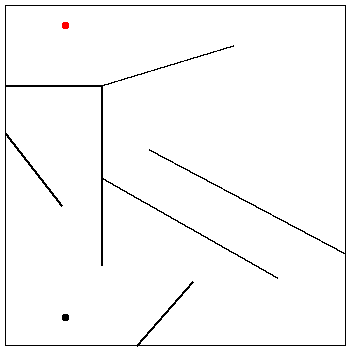

Step 1:


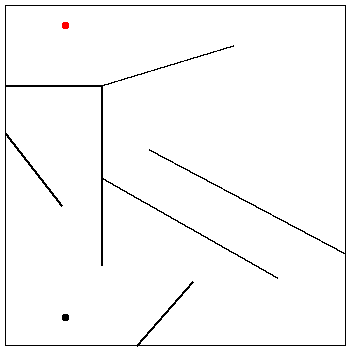

[5.8, 3.6175173008529167, 2.4125, 0.9899494936611665, 0.7000000000000002, 1.5, 1.0, 0.0, 0.0, 0.0]
Step 2:


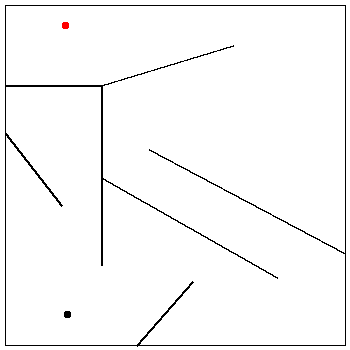

[2.221320343559642, 5.729289321881345, 3.517517300852917, 2.4036611652351683, 1.0899494936611664, 1.0899494936611656, 1.0, 0.0, 0.0, 0.0]
Step 3:


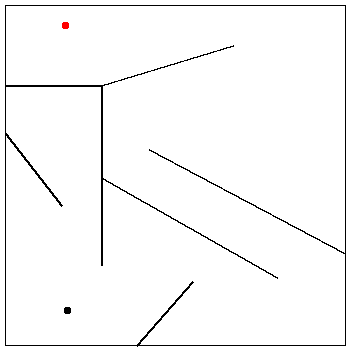

[1.5707106781186548, 2.221320343559642, 5.629289321881346, 3.4273355664407195, 2.4911611652351686, 0.8707106781186544, 0.0, 1.0, 0.0, 0.0]
Step 4:


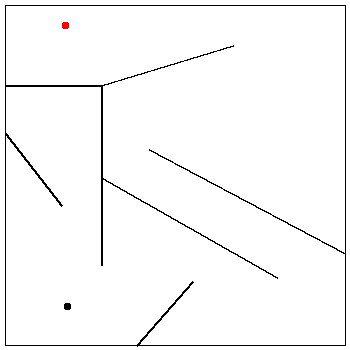

[1.5707106781186548, 2.221320343559642, 5.529289321881346, 3.337153832028523, 2.578661165235168, 0.9707106781186541, 0.0, 1.0, 0.0, 0.0]
Step 5:


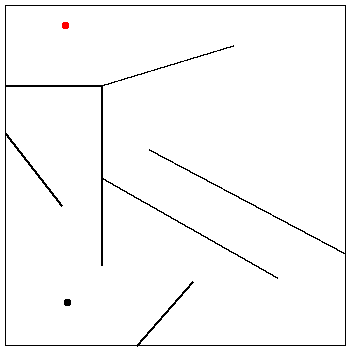

[1.5707106781186548, 2.221320343559642, 5.429289321881346, 3.246972097616325, 2.6661611652351676, 1.0707106781186537, 0.0, 1.0, 0.0, 0.0]
Step 6:


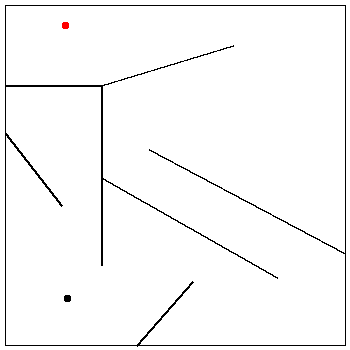

[1.5707106781186548, 2.2213203435596425, 5.329289321881347, 3.156790363204129, 2.753661165235167, 1.1707106781186534, 0.0, 1.0, 0.0, 0.0]
Step 7:


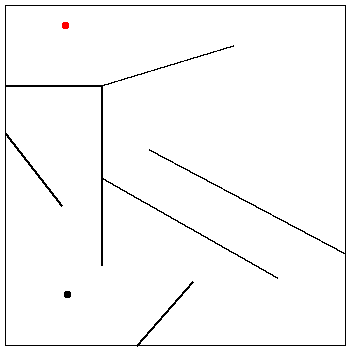

[1.5707106781186548, 2.221320343559642, 5.229289321881347, 1.1727922061357858, 2.8411611652351674, 1.270710678118653, 0.0, 1.0, 0.0, 0.0]
Step 8:


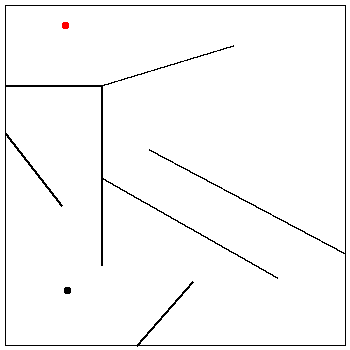

[1.5707106781186548, 2.221320343559642, 5.129289321881347, 1.1727922061357858, 2.928661165235167, 1.3707106781186527, 0.0, 1.0, 0.0, 0.0]
Step 9:


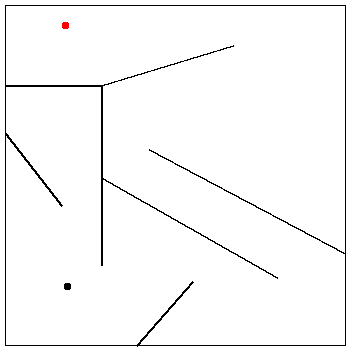

[1.5707106781186548, 2.2213203435596425, 5.029289321881348, 1.1727922061357852, 3.0161611652351663, 1.4707106781186523, 0.0, 1.0, 0.0, 0.0]
Step 10:


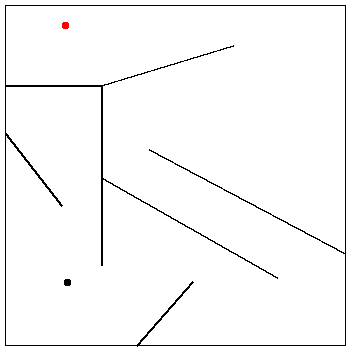

[1.5707106781186548, 2.2213203435596425, 4.929289321881348, 1.1727922061357852, 3.1036611652351667, 1.570710678118652, 0.0, 1.0, 0.0, 0.0]
Step 11:


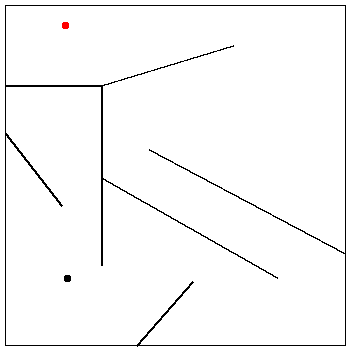

[1.5707106781186548, 2.221320343559642, 4.829289321881348, 1.1727922061357858, 6.929289321881345, 1.6707106781186516, 0.0, 1.0, 0.0, 0.0]
Step 12:


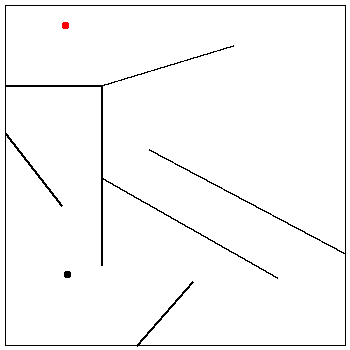

[1.5707106781186548, 2.221320343559642, 4.729289321881349, 1.1727922061357858, 5.104838528392519, 1.7707106781186512, 0.0, 1.0, 0.0, 0.0]
Step 13:


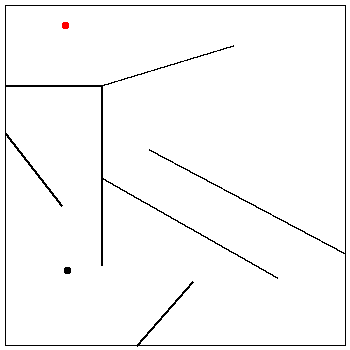

[1.5707106781186548, 2.221320343559642, 4.629289321881349, 1.1727922061357858, 4.92883852839252, 1.8707106781186509, 0.0, 1.0, 0.0, 0.0]
Step 14:


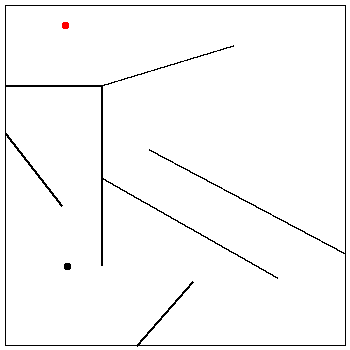

[1.5707106781186548, 2.221320343559642, 4.5292893218813495, 1.1727922061357858, 4.7528385283925205, 1.9707106781186505, 0.0, 1.0, 0.0, 0.0]
Step 15:


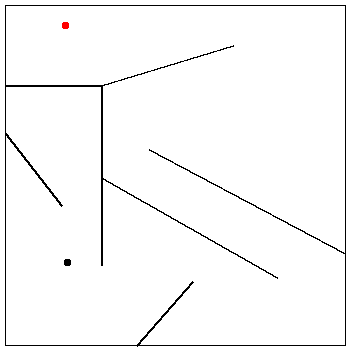

[1.5707106781186548, 2.2213203435596425, 4.42928932188135, 1.1727922061357858, 0.8292893218813451, 2.07071067811865, 0.0, 1.0, 0.0, 0.0]
Step 16:


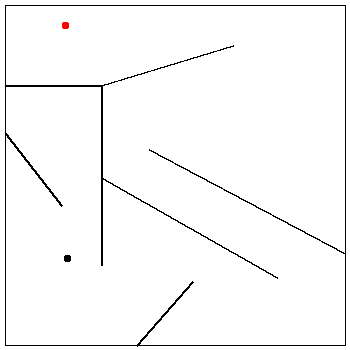

[1.5707106781186548, 2.221320343559642, 4.32928932188135, 1.1727922061357858, 0.8292893218813451, 2.17071067811865, 0.0, 1.0, 0.0, 0.0]
Step 17:


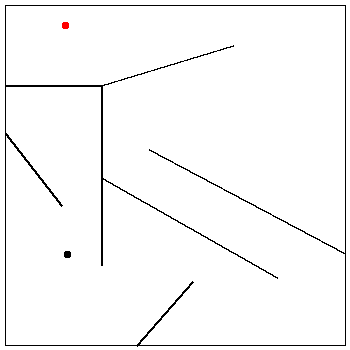

[1.5707106781186548, 2.221320343559642, 4.2292893218813505, 1.1727922061357858, 0.8292893218813451, 2.2707106781186495, 0.0, 1.0, 0.0, 0.0]
Step 18:


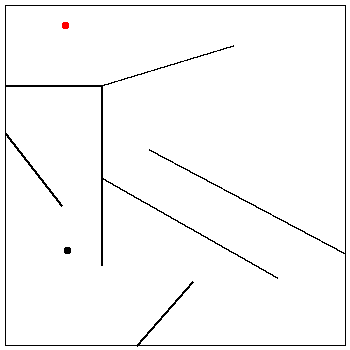

[1.5707106781186548, 2.221320343559642, 4.129289321881351, 1.1727922061357858, 0.8292893218813451, 2.370710678118649, 0.0, 1.0, 0.0, 0.0]
Step 19:


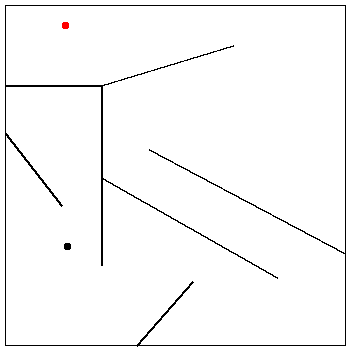

[1.5707106781186548, 2.221320343559642, 4.029289321881351, 1.1727922061357858, 0.8292893218813451, 2.4707106781186488, 0.0, 1.0, 0.0, 0.0]
Step 20:


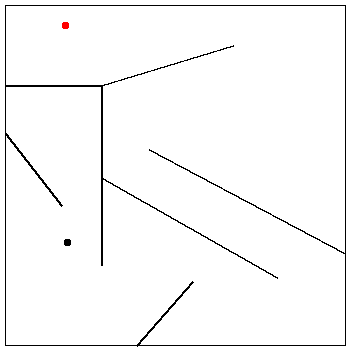

[1.5707106781186548, 2.221320343559642, 3.9292893218813516, 1.1727922061357858, 0.8292893218813451, 2.5707106781186484, 0.0, 1.0, 0.0, 0.0]
Step 21:


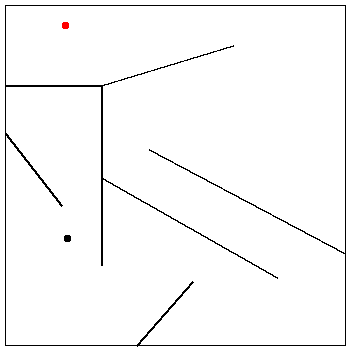

[1.5707106781186548, 2.221320343559642, 3.829289321881352, 1.1727922061357858, 0.8292893218813451, 2.670710678118648, 0.0, 1.0, 0.0, 0.0]
Step 22:


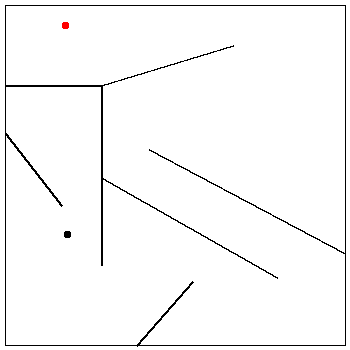

[1.5707106781186548, 2.221320343559642, 3.7292893218813523, 1.1727922061357858, 0.8292893218813451, 2.7707106781186477, 0.0, 1.0, 0.0, 0.0]
Step 23:


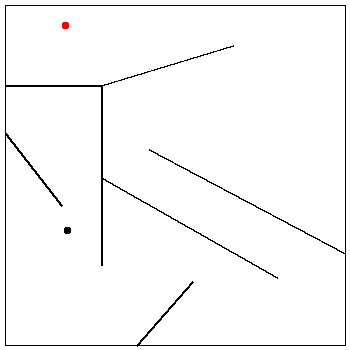

[1.5707106781186548, 2.221320343559642, 3.6292893218813527, 1.1727922061357858, 0.8292893218813451, 2.8707106781186473, 0.0, 1.0, 0.0, 0.0]
Step 24:


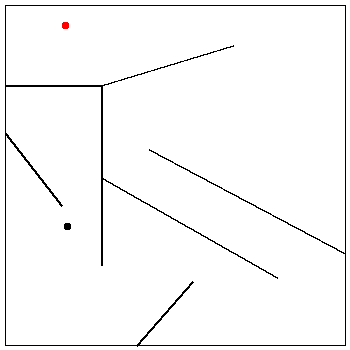

[1.5707106781186548, 2.2213203435596425, 3.529289321881353, 1.1727922061357858, 0.8292893218813451, 2.970710678118647, 0.0, 1.0, 0.0, 0.0]
Step 25:


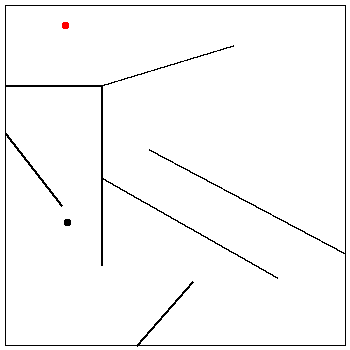

[1.5707106781186548, 2.2213203435596425, 3.4292893218813534, 1.1727922061357858, 0.8292893218813451, 3.0707106781186466, 0.0, 1.0, 0.0, 0.0]
Step 26:


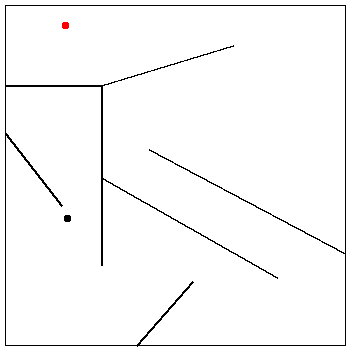

[1.5707106781186548, 2.221320343559642, 3.3292893218813537, 1.1727922061357858, 0.8292893218813451, 3.1707106781186463, 0.0, 1.0, 0.0, 0.0]
Step 27:


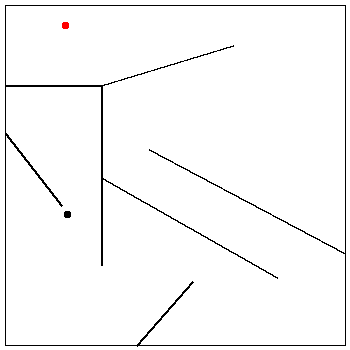

[1.5707106781186548, 2.221320343559642, 3.229289321881354, 1.1727922061357858, 0.8292893218813451, 3.270710678118646, 0.0, 1.0, 0.0, 0.0]
Step 28:


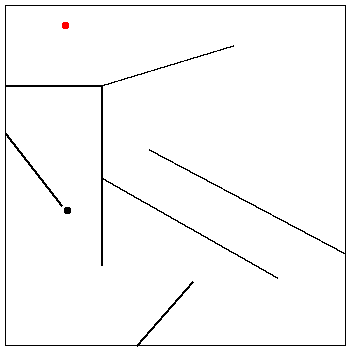

[1.5707106781186548, 0.446446609406681, 3.1292893218813544, 1.1727922061357858, 0.8292893218813451, 3.3707106781186456, 0.0, 1.0, 0.0, 0.0]
Step 29:


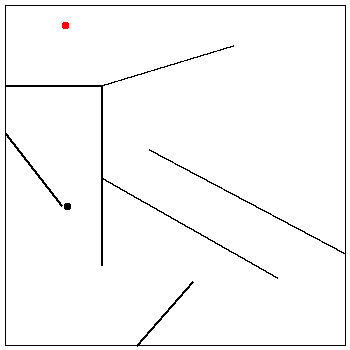

[1.5707106781186548, 0.9414213562372623, 3.029289321881355, 1.1727922061357858, 0.8292893218813451, 3.470710678118645, 0.0, 1.0, 0.0, 0.0]
Step 30:


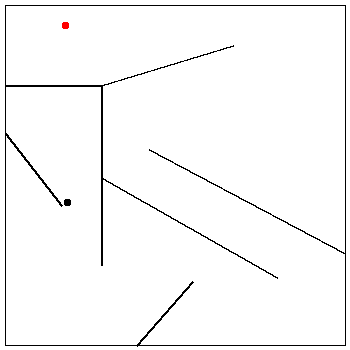

[0.22570787221093425, 1.4363961030678423, 2.929289321881355, 1.1727922061357858, 0.8292893218813451, 3.570710678118645, 0.0, 1.0, 0.0, 0.0]
Step 31:


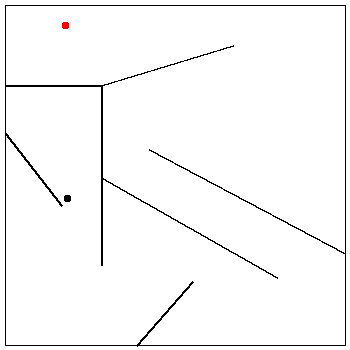

[0.30348564998871175, 1.9313708498984226, 2.8292893218813555, 1.1727922061357858, 0.8292893218813451, 3.6707106781186445, 0.0, 1.0, 0.0, 0.0]
Step 32:


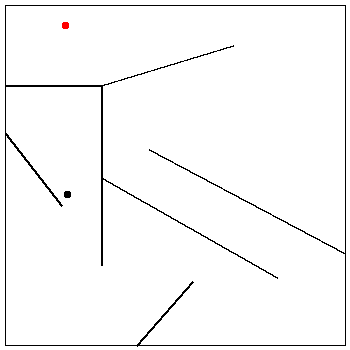

[0.38126342776648925, 2.221320343559642, 2.729289321881356, 1.1727922061357858, 0.8292893218813451, 3.770710678118644, 0.0, 1.0, 0.0, 0.0]
Step 33:


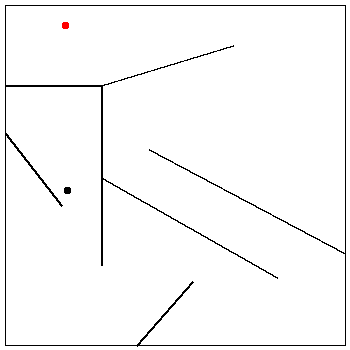

[0.45904120554426675, 2.2213203435596425, 2.6292893218813562, 1.1727922061357858, 0.8292893218813451, 3.8707106781186438, 0.0, 1.0, 0.0, 0.0]
Step 34:


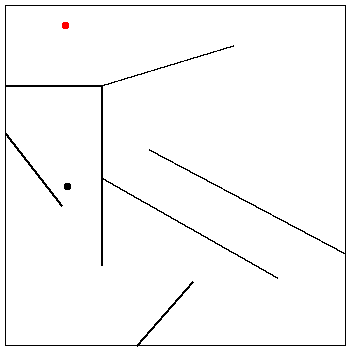

[0.5368189833220443, 2.221320343559642, 2.5292893218813566, 1.1727922061357854, 0.8292893218813451, 3.9707106781186434, 0.0, 1.0, 0.0, 0.0]
Step 35:


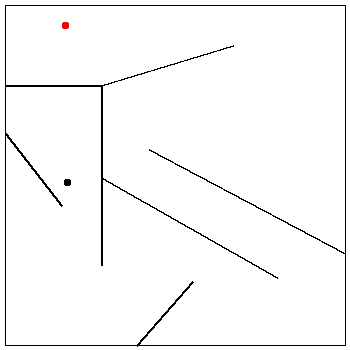

[0.6145967610998218, 2.2213203435596425, 2.429289321881357, 1.1727922061357858, 0.8292893218813451, 4.070710678118643, 0.0, 1.0, 0.0, 0.0]
Step 36:


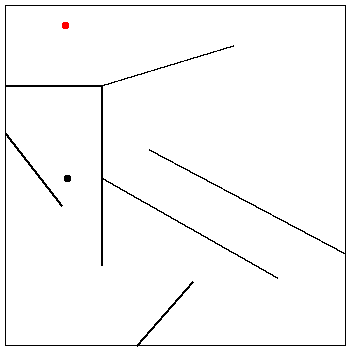

[0.6923745388775993, 2.2213203435596425, 2.3292893218813573, 1.1727922061357854, 0.8292893218813451, 4.170710678118643, 0.0, 1.0, 0.0, 0.0]
Step 37:


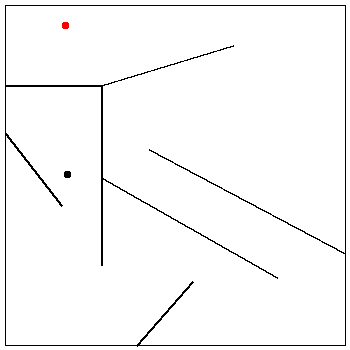

[0.7701523166553766, 2.2213203435596425, 2.2292893218813576, 1.1727922061357858, 0.8292893218813451, 4.270710678118642, 0.0, 1.0, 0.0, 0.0]
Step 38:


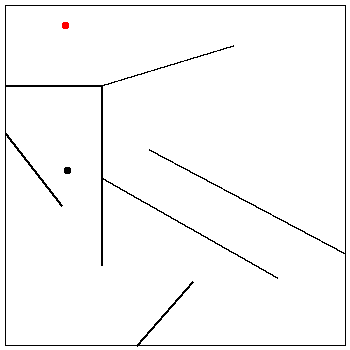

[0.8479300944331541, 2.2213203435596425, 2.129289321881358, 1.1727922061357854, 0.8292893218813451, 4.370710678118642, 0.0, 1.0, 0.0, 0.0]
Step 39:


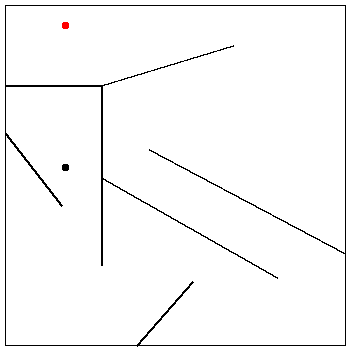

[0.6620242597140616, 0.8322166104067862, 2.121320343559642, 2.0585786437627034, 1.2727922061357857, 1.272792206135785, 0.0, 1.0, 0.0, 0.0]
Step 40:


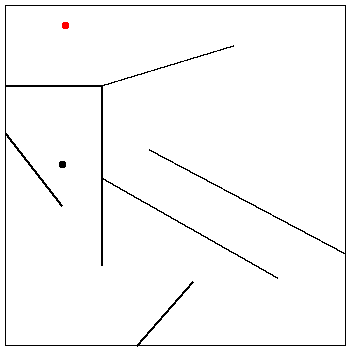

[0.6495242597140619, 0.8165031263804184, 2.021320343559642, 1.9878679656440488, 1.3727922061357856, 1.3727922061357856, 0.0, 0.0, 1.0, 0.0]
Step 41:


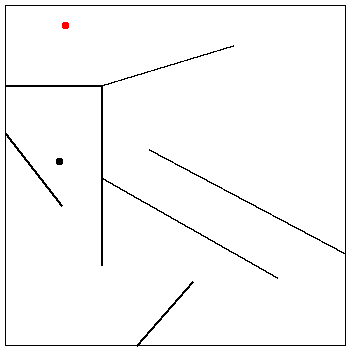

[0.6370242597140615, 0.8007896423540505, 1.921320343559642, 1.9171572875253942, 1.472792206135786, 1.4727922061357857, 0.0, 0.0, 1.0, 0.0]
Step 42:


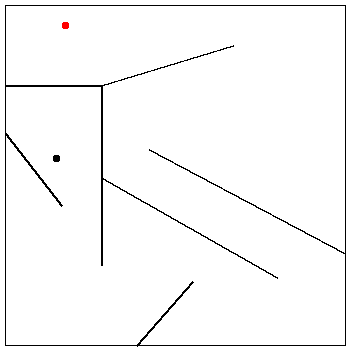

[0.6245242597140612, 0.7850761583276825, 1.8213203435596417, 1.8464466094067395, 1.572792206135786, 1.5727922061357855, 0.0, 0.0, 1.0, 0.0]
Step 43:


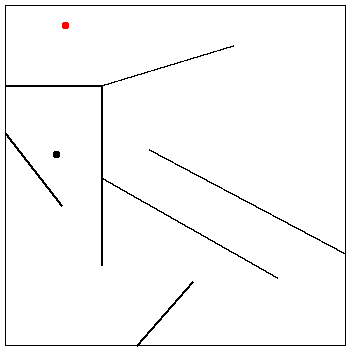

[0.8628539361054604, 1.8213203435596417, 1.7464466094067395, 1.572792206135786, 1.1121320343559644, 1.1093836321355925, 0.0, 1.0, 0.0, 0.0]
Step 44:


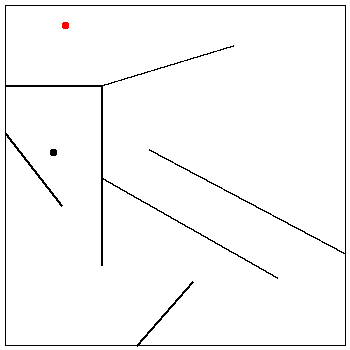

[0.6738961030678842, 0.8471404520790925, 1.7213203435596418, 1.6757359312880848, 1.6727922061357865, 1.6727922061357854, 0.0, 0.0, 1.0, 0.0]
Step 45:


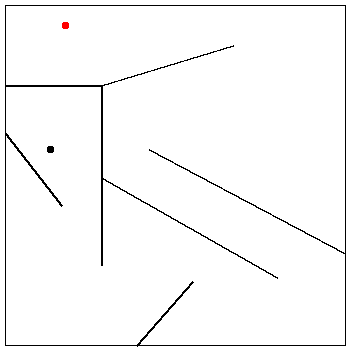

[0.6613961030678845, 0.8314269680527245, 1.6213203435596417, 1.6050252531694302, 1.7727922061357866, 1.772792206135786, 0.0, 0.0, 1.0, 0.0]
Step 46:


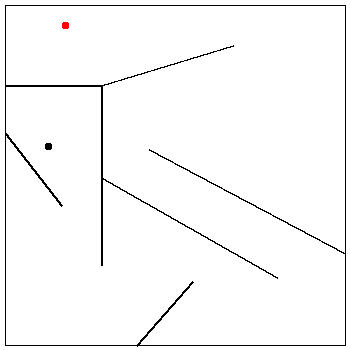

[0.648896103067884, 0.8157134840263567, 1.5213203435596412, 1.5343145750507756, 1.8727922061357867, 1.8727922061357858, 0.0, 0.0, 1.0, 0.0]
Step 47:


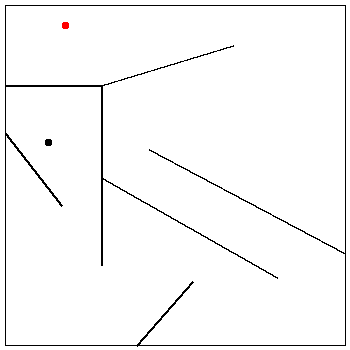

[0.8934912618041345, 1.5213203435596416, 1.4343145750507755, 1.8727922061357867, 1.324264068711929, 1.1487744794624586, 0.0, 1.0, 0.0, 0.0]
Step 48:


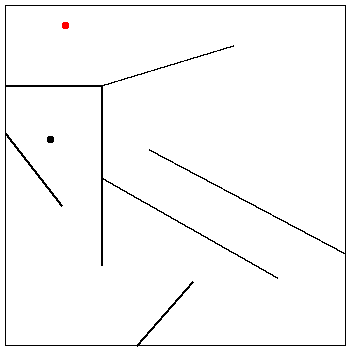

[1.6213203435596415, 1.363603896932121, 1.7727922061357866, 1.253553390593274, 1.7727922061357861, 0.810767946421707, 0.0, 1.0, 0.0, 0.0]
Step 49:


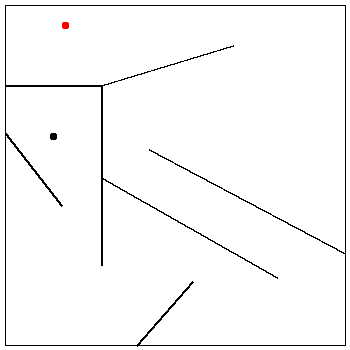

[1.7213203435596418, 1.2928932188134663, 1.6727922061357865, 1.1828427124746193, 1.6727922061357856, 0.9107679464217071, 0.0, 1.0, 0.0, 0.0]
Step 50:


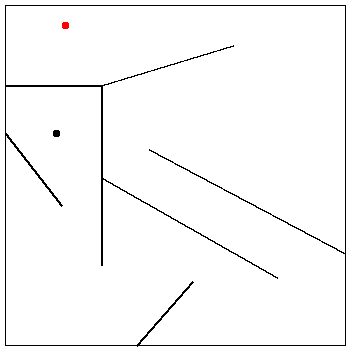

[1.7284271247462102, 1.2221825406948117, 1.5727922061357862, 1.1121320343559644, 1.5727922061357855, 1.010767946421707, 0.0, 1.0, 0.0, 0.0]
Step 51:


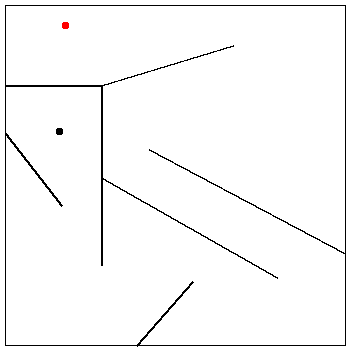

[1.6284271247462103, 1.151471862576157, 1.472792206135786, 1.0414213562373096, 1.4727922061357857, 1.1107679464217073, 0.0, 1.0, 0.0, 0.0]
Step 52:


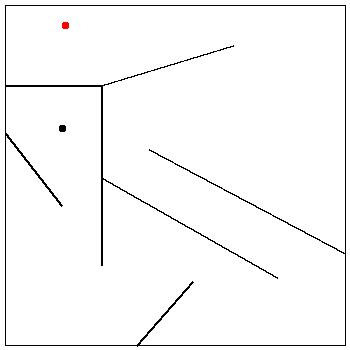

[1.5284271247462105, 1.0807611844575025, 1.3727922061357856, 0.9707106781186547, 1.3727922061357851, 1.210767946421707, 0.0, 1.0, 0.0, 0.0]
Step 53:


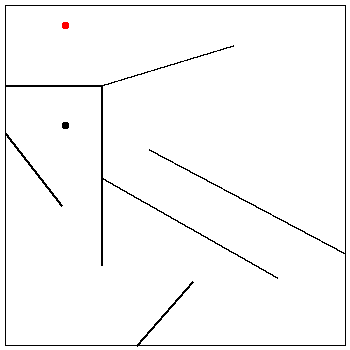

[1.4284271247462108, 1.0100505063388479, 1.2727922061357857, 0.8999999999999999, 1.2727922061357855, 1.3107679464217072, 1.0, 0.0, 0.0, 0.0]
Step 54:


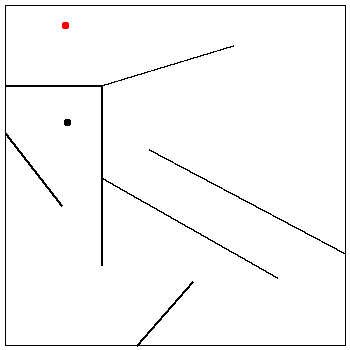

[1.328427124746211, 0.9393398282201932, 1.1727922061357854, 0.8292893218813451, 1.1727922061357854, 1.410767946421707, 1.0, 0.0, 0.0, 0.0]
Step 55:


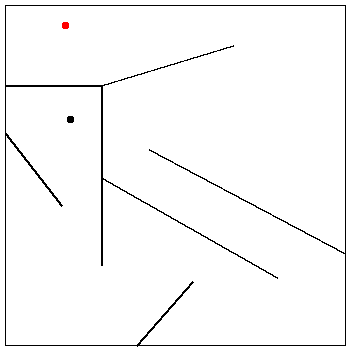

[1.228427124746211, 0.8686291501015386, 1.0727922061357855, 0.7585786437626902, 1.0727922061357853, 1.510767946421707, 1.0, 0.0, 0.0, 0.0]
Step 56:


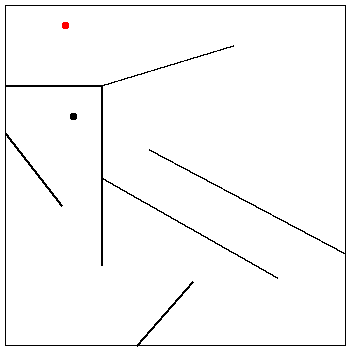

[1.1284271247462114, 0.797918471982884, 0.9727922061357852, 0.6878679656440354, 0.9727922061357852, 1.610767946421707, 1.0, 0.0, 0.0, 0.0]
Step 57:


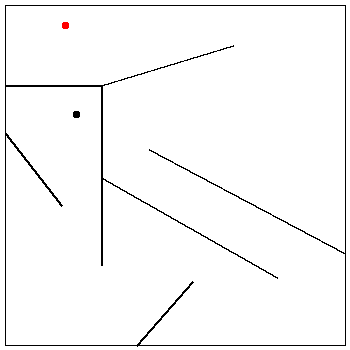

[1.0284271247462113, 0.7272077938642294, 0.8727922061357852, 0.6171572875253806, 0.872792206135785, 1.710767946421707, 1.0, 0.0, 0.0, 0.0]
Step 58:


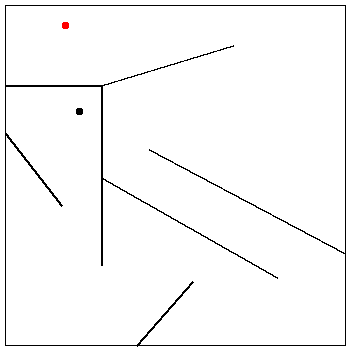

[0.9284271247462116, 0.6564971157455748, 0.772792206135785, 0.5464466094067257, 0.7727922061357847, 1.8107679464217072, 1.0, 0.0, 0.0, 0.0]
Step 59:


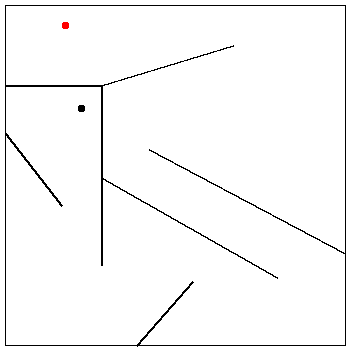

[0.8284271247462117, 0.5857864376269202, 0.672792206135785, 0.4757359312880709, 0.6727922061357847, 1.9107679464217073, 1.0, 0.0, 0.0, 0.0]
Step 60:


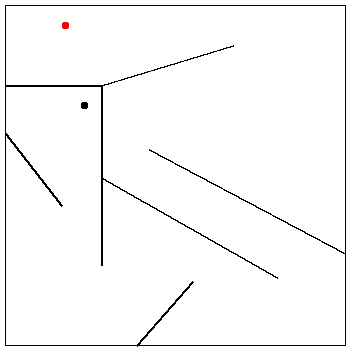

[0.728427124746212, 0.5150757595082656, 0.5727922061357847, 0.40502525316941607, 0.5727922061357847, 2.010767946421707, 1.0, 0.0, 0.0, 0.0]
Step 61:


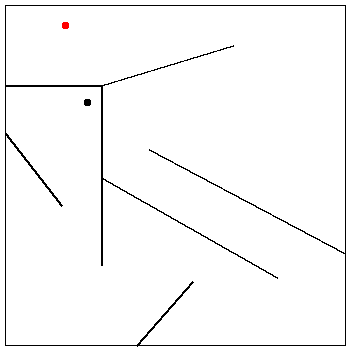

[0.6284271247462122, 0.44436508138961095, 0.4727922061357845, 0.33431457505076123, 0.47279220613578476, 2.110767946421707, 1.0, 0.0, 0.0, 0.0]
Step 62:


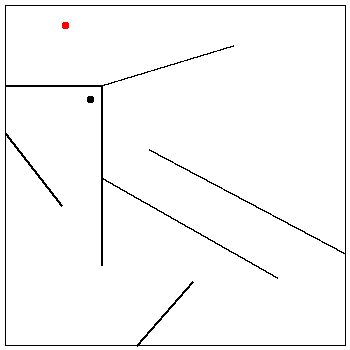

[0.5284271247462123, 0.37365440327095634, 0.3727922061357847, 0.2636038969321066, 0.3727922061357847, 2.2107679464217065, 1.0, 0.0, 0.0, 0.0]
Step 63:


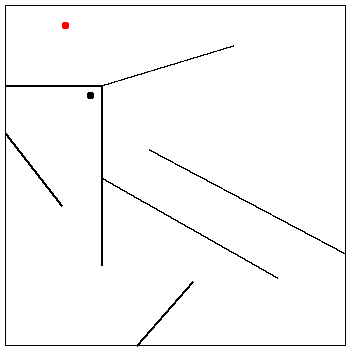

[2.1363961030678933, 0.3870057685089028, 0.27365440327095625, 0.3727922061357847, 0.2636038969321066, 6.226345596729043, 0.0, 1.0, 0.0, 0.0]
Step 64:


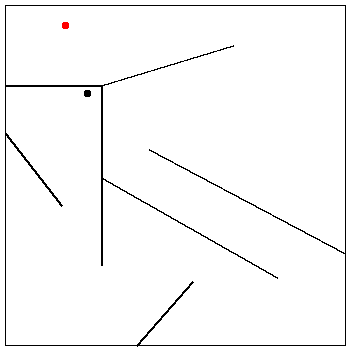

[2.2601397897755295, 2.0656854249492387, 0.2870057685089028, 0.20294372515230164, 0.2870057685089028, 0.4727922061357845, 0.0, 1.0, 0.0, 0.0]
Step 65:


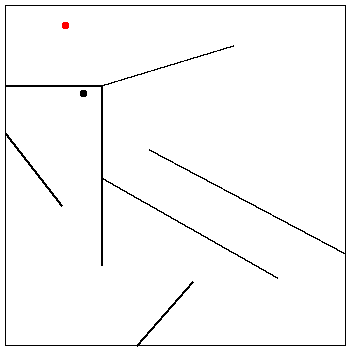

[6.297056274847698, 2.1805902768920427, 1.9656854249492386, 0.28700576850890297, 0.20294372515230164, 0.4343145750507613, 0.0, 0.0, 1.0, 0.0]
Step 66:


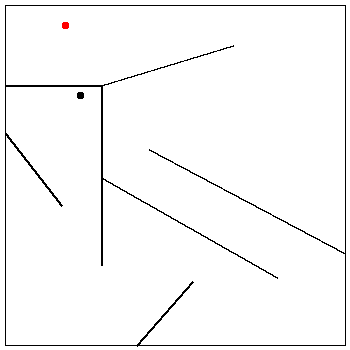

[0.7142135623730943, 6.226345596729043, 2.080590276892043, 1.8949747468305838, 0.3870057685089028, 0.38700576850890245, 0.0, 0.0, 1.0, 0.0]
Step 67:


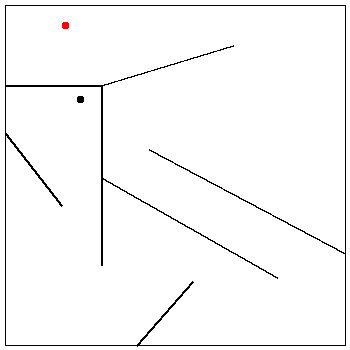

[0.5050252531694162, 0.7142135623730941, 6.126345596729044, 2.01871843353822, 1.8949747468305838, 0.37365440327095634, 0.0, 0.0, 0.0, 1.0]
Step 68:


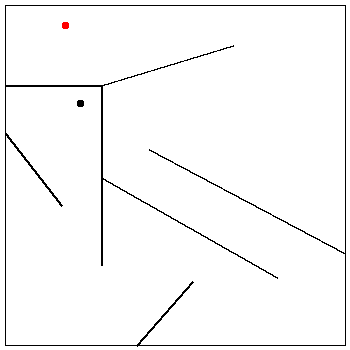

[0.5050252531694162, 0.7142135623730941, 6.026345596729044, 1.9568465901843972, 1.8949747468305838, 0.4736544032709564, 0.0, 0.0, 0.0, 1.0]
Step 69:


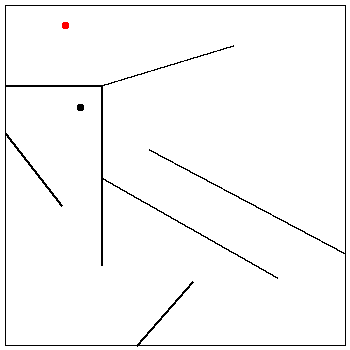

[0.5050252531694162, 0.7142135623730941, 5.9263455967290435, 1.894974746830574, 1.8949747468305838, 0.5736544032709565, 0.0, 0.0, 0.0, 1.0]
Step 70:


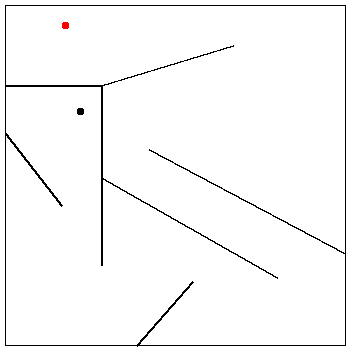

[0.5050252531694162, 0.7142135623730943, 5.826345596729043, 1.833102903476751, 1.8949747468305838, 0.6736544032709566, 0.0, 0.0, 0.0, 1.0]
Step 71:


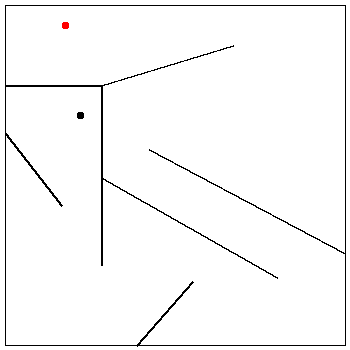

[0.5050252531694162, 0.7142135623730941, 5.726345596729043, 1.7712310601229284, 1.8949747468305838, 0.7736544032709567, 0.0, 0.0, 0.0, 1.0]
Step 72:


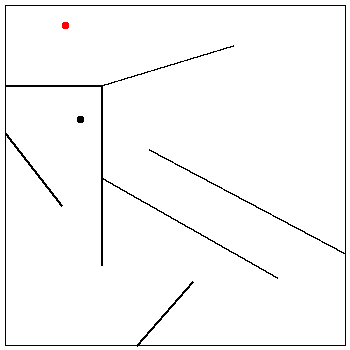

[0.5050252531694162, 0.7142135623730941, 5.626345596729044, 1.7093592167691047, 1.8949747468305838, 0.8736544032709568, 0.0, 0.0, 0.0, 1.0]
Step 73:


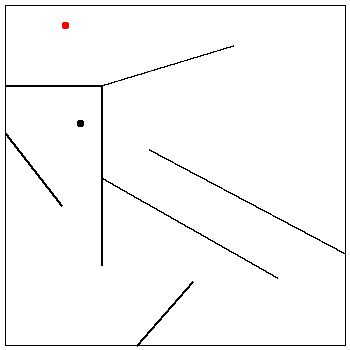

[0.5050252531694162, 0.7142135623730941, 5.526345596729043, 1.6474873734152824, 1.8949747468305838, 0.9736544032709569, 0.0, 0.0, 0.0, 1.0]
Step 74:


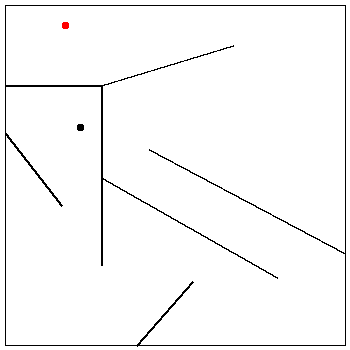

[0.5050252531694162, 0.7142135623730941, 5.426345596729043, 1.5856155300614596, 1.8949747468305838, 1.073654403270957, 0.0, 0.0, 0.0, 1.0]
Step 75:


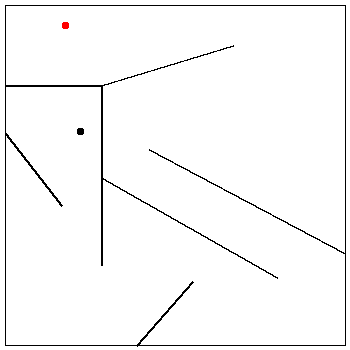

[0.5050252531694162, 0.7142135623730941, 5.326345596729043, 1.523743686707636, 1.8949747468305838, 1.173654403270957, 0.0, 0.0, 0.0, 1.0]
Step 76:


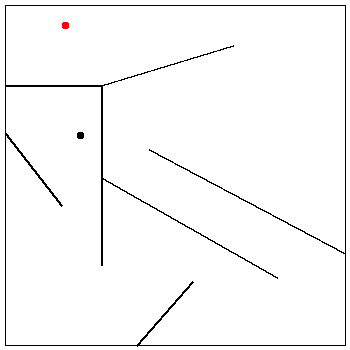

[0.5050252531694162, 0.7142135623730943, 5.226345596729043, 1.4618718433538134, 1.8376879887309503, 1.2736544032709571, 0.0, 0.0, 0.0, 1.0]
Step 77:


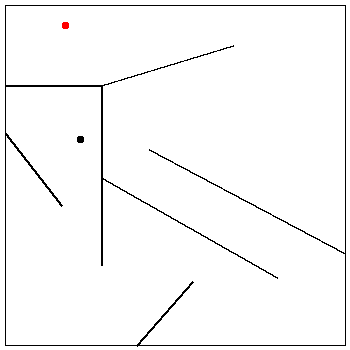

[0.5050252531694162, 0.7142135623730941, 5.126345596729043, 1.3999999999999904, 1.7599102109531726, 1.3736544032709572, 0.0, 0.0, 0.0, 1.0]
Step 78:


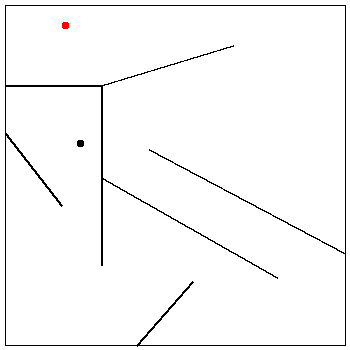

[0.5050252531694162, 0.7142135623730943, 5.026345596729042, 1.3381281566461671, 1.6821324331753946, 1.4736544032709573, 0.0, 0.0, 0.0, 1.0]
Step 79:


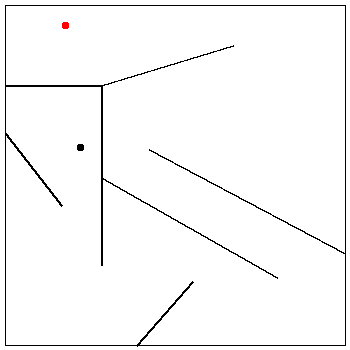

[0.5050252531694162, 0.7142135623730941, 4.926345596729043, 1.2762563132923446, 1.604354655397617, 1.5736544032709574, 0.0, 0.0, 0.0, 1.0]
Step 80:


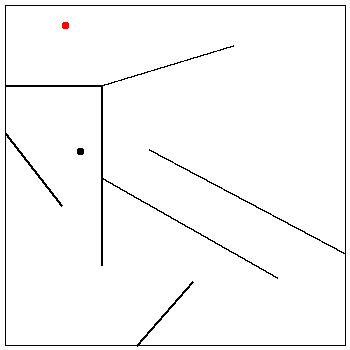

[0.5050252531694162, 0.7142135623730937, 4.826345596729043, 1.2143844699385211, 1.526576877619839, 1.6736544032709575, 0.0, 0.0, 0.0, 1.0]
Step 81:


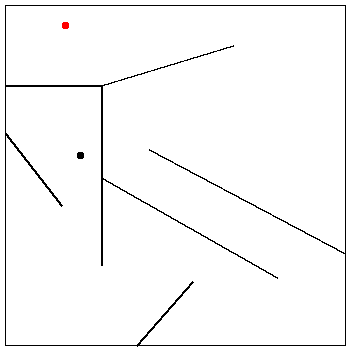

[0.5050252531694162, 0.7142135623730941, 4.726345596729042, 1.1525126265846986, 1.4487990998420612, 1.7736544032709576, 0.0, 0.0, 0.0, 1.0]
Step 82:


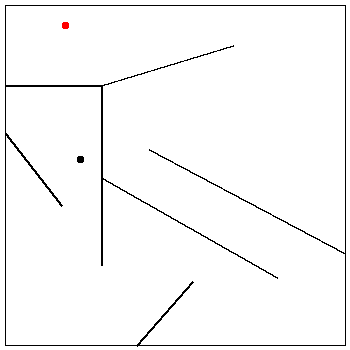

[0.5050252531694162, 0.7142135623730943, 4.626345596729042, 1.0906407832308755, 1.3710213220642833, 1.8736544032709577, 0.0, 0.0, 0.0, 1.0]
Step 83:


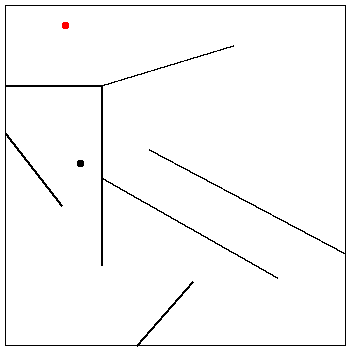

[0.5050252531694162, 0.7142135623730941, 4.526345596729042, 1.0287689398770523, 1.2932435442865056, 1.9736544032709578, 0.0, 0.0, 0.0, 1.0]
Step 84:


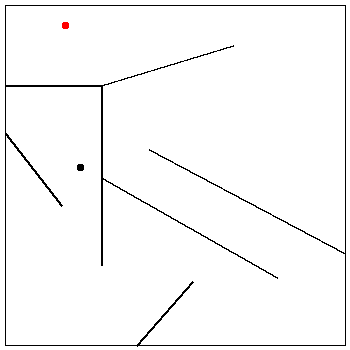

[0.5050252531694162, 0.7142135623730941, 4.426345596729043, 0.96689709652323, 1.215465766508728, 2.0736544032709574, 0.0, 0.0, 0.0, 1.0]
Step 85:


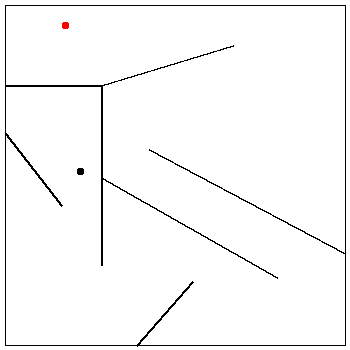

[0.5050252531694162, 0.7142135623730941, 4.326345596729043, 0.905025253169407, 1.1376879887309506, 2.173654403270957, 0.0, 0.0, 0.0, 1.0]
Step 86:


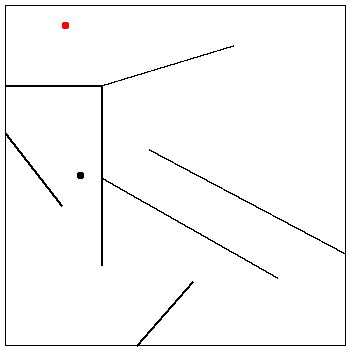

[0.5050252531694162, 0.7142135623730941, 4.226345596729043, 0.8431534098155847, 1.059910210953173, 2.2736544032709567, 0.0, 0.0, 0.0, 1.0]
Step 87:


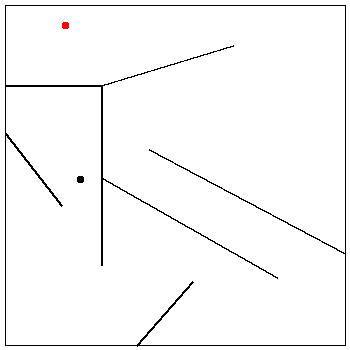

[0.5050252531694162, 0.7142135623730941, 4.126345596729044, 0.7812815664617617, 0.9821324331753956, 2.3736544032709563, 0.0, 0.0, 0.0, 1.0]
Step 88:


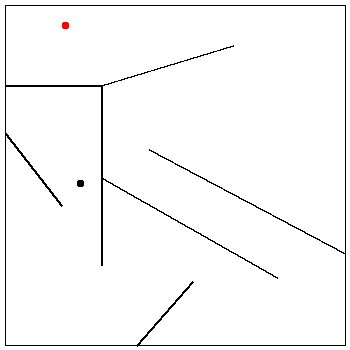

[0.5050252531694162, 0.7142135623730941, 4.026345596729044, 0.7194097231079388, 0.9043546553976181, 2.473654403270956, 0.0, 0.0, 0.0, 1.0]
Step 89:


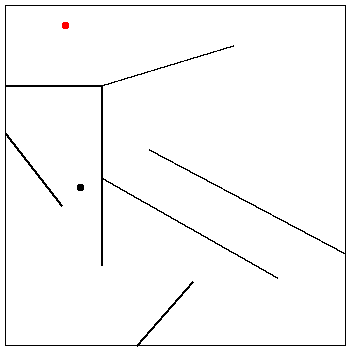

[0.5050252531694162, 0.7142135623730941, 3.9263455967290444, 2.6798989873223342, 0.8265768776198406, 2.5736544032709556, 0.0, 0.0, 0.0, 1.0]
Step 90:


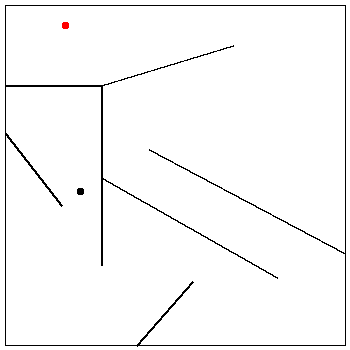

[0.5050252531694162, 0.7142135623730941, 3.8263455967290447, 2.6798989873223342, 0.748799099842063, 2.6736544032709553, 0.0, 0.0, 0.0, 1.0]
Step 91:


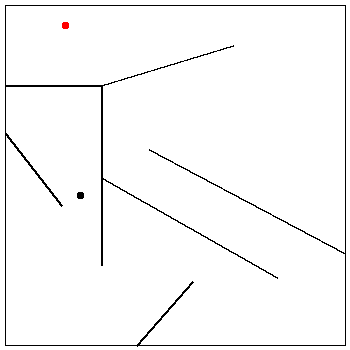

[0.5050252531694162, 0.7142135623730941, 3.726345596729045, 2.6798989873223342, 0.6710213220642856, 2.773654403270955, 0.0, 0.0, 0.0, 1.0]
Step 92:


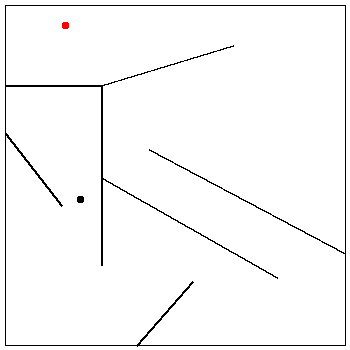

[0.5050252531694162, 0.7142135623730941, 3.6263455967290454, 2.6798989873223342, 0.5932435442865083, 2.8736544032709546, 0.0, 0.0, 0.0, 1.0]
Step 93:


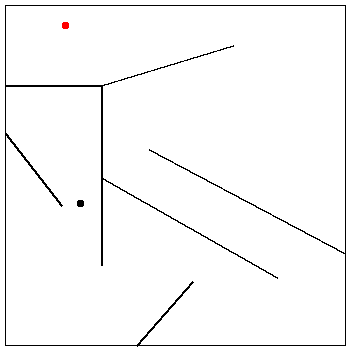

[0.5050252531694162, 0.7142135623730941, 3.526345596729046, 2.6798989873223342, 0.5154657665087305, 2.973654403270954, 0.0, 0.0, 0.0, 1.0]
Step 94:


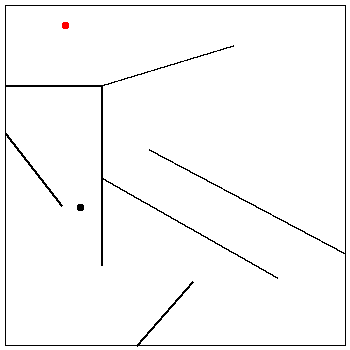

[0.5050252531694162, 0.7142135623730941, 3.426345596729046, 2.6798989873223342, 1.8949747468305838, 3.073654403270954, 0.0, 0.0, 0.0, 1.0]
Step 95:


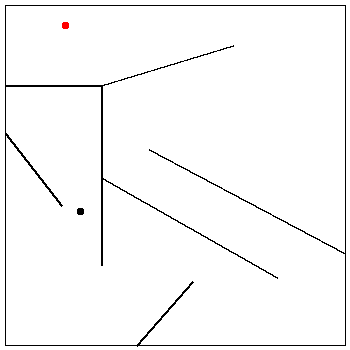

[0.5050252531694162, 0.7142135623730941, 3.3263455967290465, 2.6798989873223342, 1.8949747468305838, 3.1736544032709535, 0.0, 0.0, 0.0, 1.0]
Step 96:


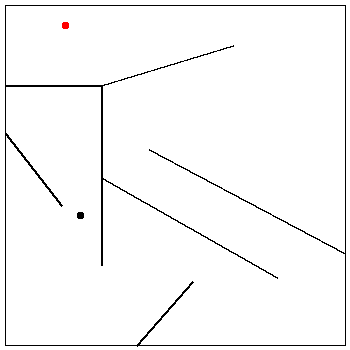

[0.5050252531694162, 0.7142135623730941, 3.226345596729047, 2.6798989873223342, 1.8949747468305838, 3.273654403270953, 0.0, 0.0, 0.0, 1.0]
Step 97:


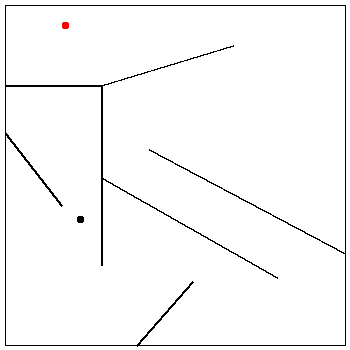

[0.5050252531694162, 0.7142135623730941, 3.126345596729047, 2.6798989873223342, 1.8949747468305838, 3.373654403270953, 0.0, 0.0, 0.0, 1.0]
Step 98:


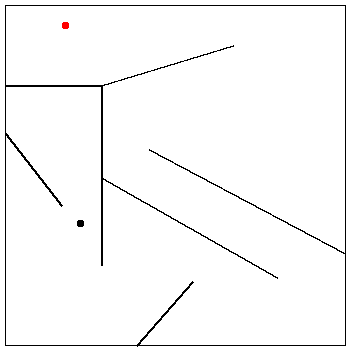

[0.5050252531694162, 0.7142135623730941, 3.0263455967290476, 2.6798989873223342, 1.8949747468305838, 3.4736544032709524, 0.0, 0.0, 0.0, 1.0]
Step 99:


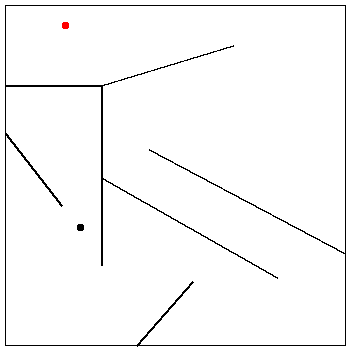

[0.5050252531694162, 0.7142135623730941, 2.926345596729048, 2.6798989873223342, 1.8949747468305838, 3.573654403270952, 0.0, 0.0, 0.0, 1.0]
Step 100:


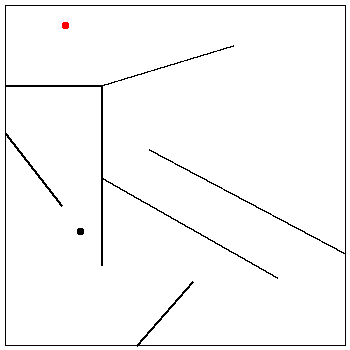

[0.5050252531694162, 0.7142135623730941, 2.8263455967290483, 2.6798989873223342, 1.8949747468305838, 3.6736544032709517, 0.0, 0.0, 0.0, 1.0]
Step 101:


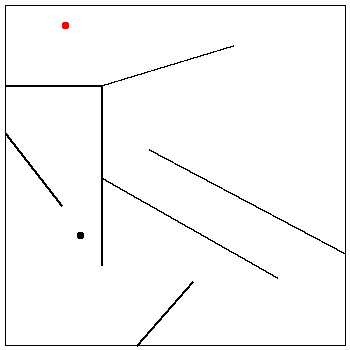

[0.5050252531694162, 0.7142135623730941, 2.7263455967290486, 2.6798989873223342, 1.8949747468305838, 3.7736544032709514, 0.0, 0.0, 0.0, 1.0]
Step 102:


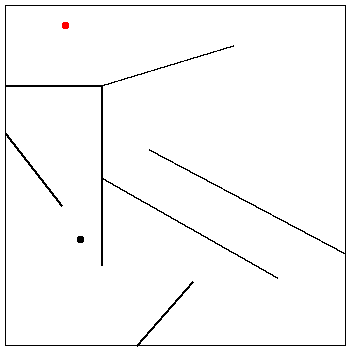

[0.5050252531694162, 0.7142135623730941, 2.626345596729049, 2.6798989873223342, 1.8949747468305838, 3.873654403270951, 0.0, 0.0, 0.0, 1.0]
Step 103:


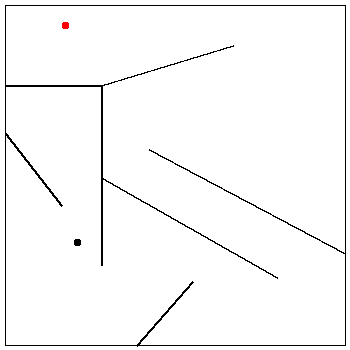

[2.7997027389788403, 2.5556349186103944, 2.579898987322334, 1.824264068711929, 2.5798989873223332, 0.8142135623730947, 0.0, 0.0, 1.0, 0.0]
Step 104:


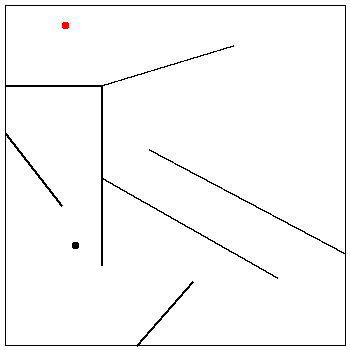

[2.806369405645507, 2.4849242404917398, 2.4798989873223336, 1.753553390593274, 2.479898987322333, 0.9142135623730946, 0.0, 0.0, 1.0, 0.0]
Step 105:


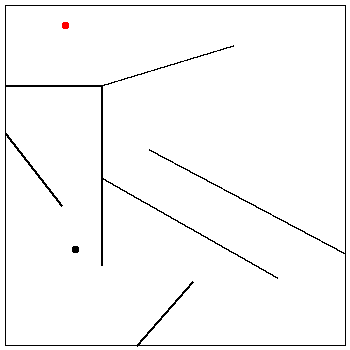

[0.6464466094067258, 2.7403727727347635, 2.38492424049174, 2.4798989873223336, 1.753553390593274, 4.11507575950826, 0.0, 0.0, 0.0, 1.0]
Step 106:


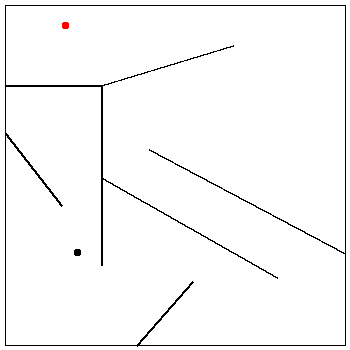

[0.8142135623730947, 0.575735931288071, 2.6403727727347635, 2.3142135623730855, 2.579898987322334, 2.5798989873223332, 0.0, 0.0, 0.0, 1.0]
Step 107:


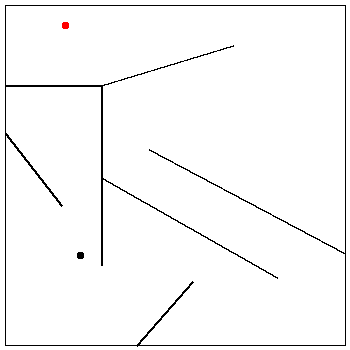

[0.7142135623730941, 0.5050252531694162, 2.5403727727347634, 2.243502884254431, 2.6798989873223342, 2.679898987322333, 0.0, 0.0, 0.0, 1.0]
Step 108:


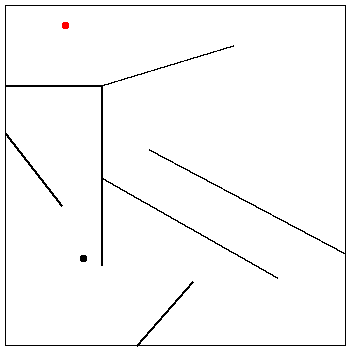

[0.6142135623730941, 0.4343145750507613, 2.4403727727347633, 2.1727922061357763, 2.7798989873223343, 2.7798989873223334, 0.0, 0.0, 0.0, 1.0]
Step 109:


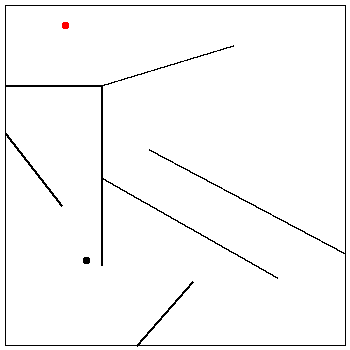

[0.5142135623730943, 0.3636038969321067, 2.3403727727347636, 2.1020815280171217, 2.879898987322334, 2.8798989873223326, 0.0, 0.0, 0.0, 1.0]
Step 110:


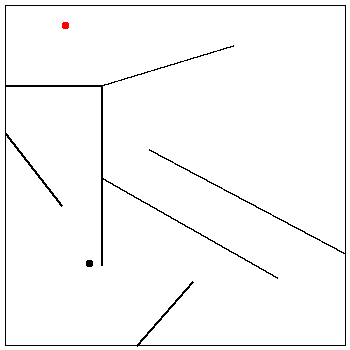

[0.41421356237309453, 0.2928932188134521, 2.2403727727347635, 2.031370849898467, 2.8727922061357725, 2.979898987322333, 0.0, 0.0, 0.0, 1.0]
Step 111:


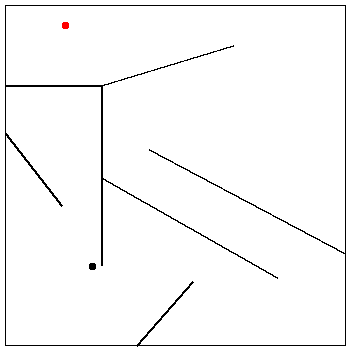

[0.3142135623730947, 4.163420638362329, 2.140372772734764, 1.9606601717798124, 2.772792206135773, 3.0798989873223324, 0.0, 0.0, 0.0, 1.0]
Step 112:


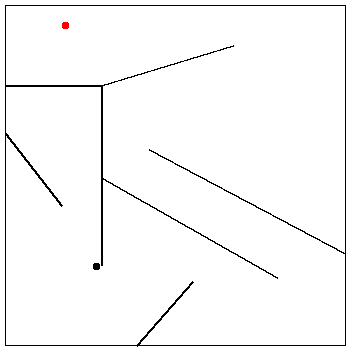

[4.539339828220188, 0.1727922061357854, 4.063420638362328, 2.064948049408198, 1.9606601717798124, 2.2778174593052025, 1.0, 0.0, 0.0, 0.0]
Step 113:


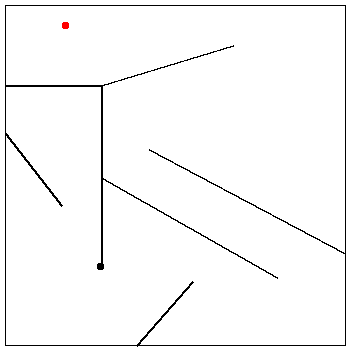

[4.539339828220188, 2.0308417464353026, 3.963420638362328, 1.9895233260816336, 1.9606601717798124, 2.3778174593052026, 1.0, 0.0, 0.0, 0.0]
Step 114:


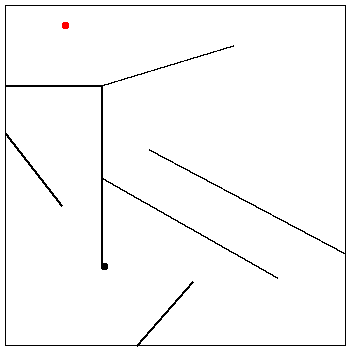

[2.195125362705868, 1.9796021246101898, 3.863420638362327, 1.9140986027550684, 1.9606601717798124, 2.4778174593052027, 1.0, 0.0, 0.0, 0.0]
Step 115:


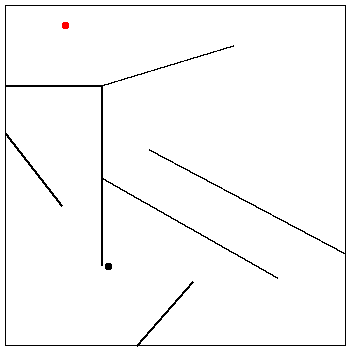

[2.1383071808876863, 1.9283625027850781, 3.763420638362327, 1.8386738794285034, 1.9606601717798124, 2.577817459305203, 1.0, 0.0, 0.0, 0.0]
Step 116:


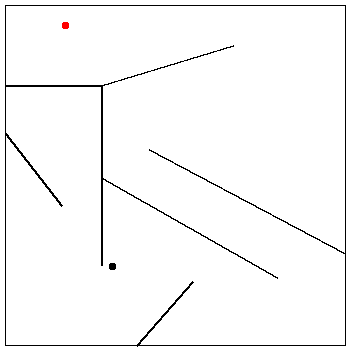

[2.0814889990695047, 1.8771228809599654, 3.663420638362328, 1.763249156101938, 1.9606601717798124, 2.677817459305203, 1.0, 0.0, 0.0, 0.0]
Step 117:


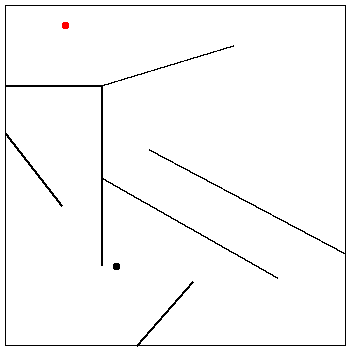

[2.024670817251322, 1.8258832591348533, 3.5634206383623277, 1.6878244327753724, 1.9606601717798124, 2.777817459305203, 1.0, 0.0, 0.0, 0.0]
Step 118:


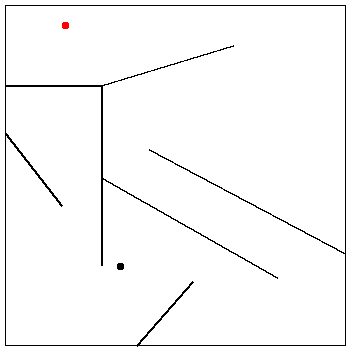

[1.9678526354331405, 1.7746436373097412, 3.4634206383623267, 1.6123997094488078, 1.9606601717798124, 2.877817459305203, 1.0, 0.0, 0.0, 0.0]
Step 119:


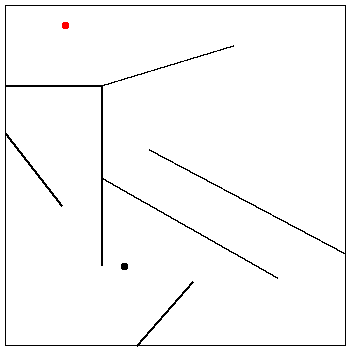

[1.9110344536149588, 1.7234040154846284, 3.3634206383623266, 1.5369749861222428, 1.9606601717798124, 2.977817459305203, 1.0, 0.0, 0.0, 0.0]
Step 120:


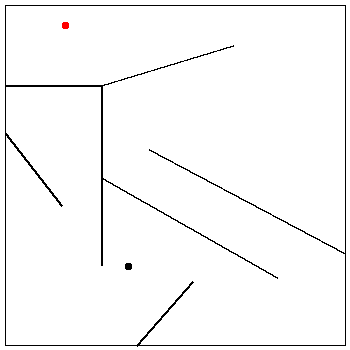

[1.8542162717967763, 1.6721643936595165, 3.2634206383623265, 1.4615502627956773, 1.9606601717798124, 3.0778174593052032, 1.0, 0.0, 0.0, 0.0]
Step 121:


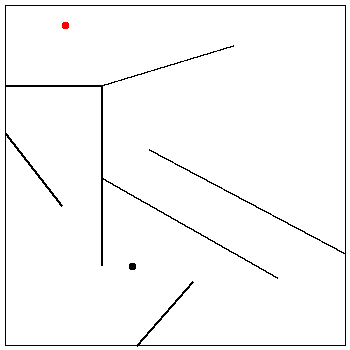

[1.7973980899785955, 1.6209247718344044, 3.1634206383623265, 1.3861255394691123, 1.9606601717798124, 3.1778174593052033, 1.0, 0.0, 0.0, 0.0]
Step 122:


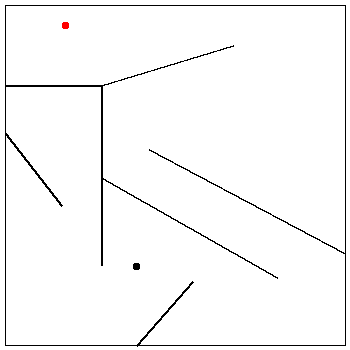

[1.740579908160413, 1.5696851500092923, 3.0634206383623264, 1.310700816142547, 1.9606601717798124, 3.2778174593052034, 1.0, 0.0, 0.0, 0.0]
Step 123:


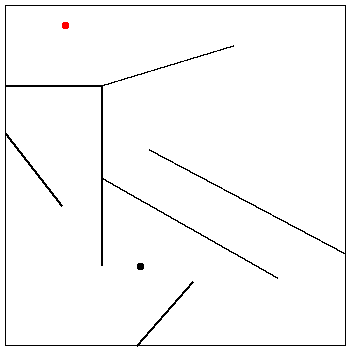

[1.6837617263422313, 1.5184455281841804, 2.963420638362327, 1.2352760928159825, 1.8717259325738649, 3.3778174593052035, 1.0, 0.0, 0.0, 0.0]
Step 124:


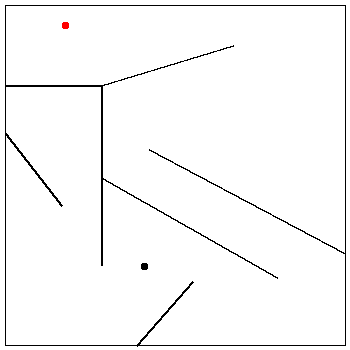

[1.6269435445240497, 1.4672059063590683, 2.863420638362326, 1.1598513694894172, 1.757440218288151, 3.4778174593052036, 1.0, 0.0, 0.0, 0.0]
Step 125:


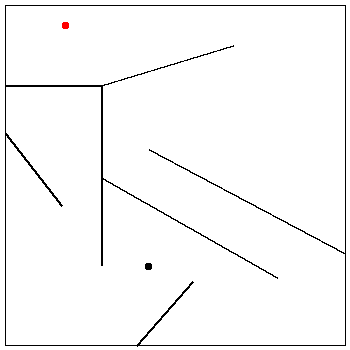

[1.570125362705868, 1.4159662845339556, 2.763420638362326, 1.0844266461628518, 1.6431545040024371, 3.5778174593052037, 1.0, 0.0, 0.0, 0.0]
Step 126:


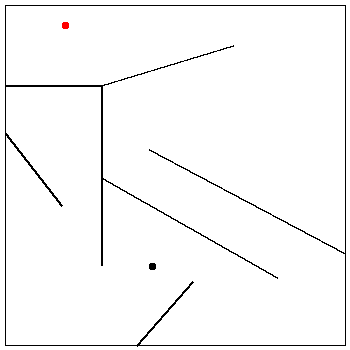

[1.5133071808876855, 1.3647266627088435, 2.663420638362326, 1.0090019228362872, 1.5288687897167215, 3.6778174593052038, 1.0, 0.0, 0.0, 0.0]
Step 127:


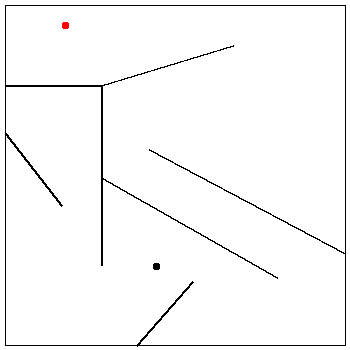

[1.4564889990695038, 1.3134870408837316, 2.563420638362326, 0.9335771995097214, 1.4145830754310076, 3.777817459305204, 1.0, 0.0, 0.0, 0.0]
Step 128:


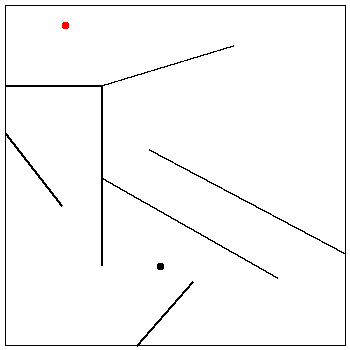

[1.3996708172513221, 1.2622474190586195, 2.463420638362326, 0.8581524761831562, 1.3002973611452937, 3.877817459305204, 1.0, 0.0, 0.0, 0.0]
Step 129:


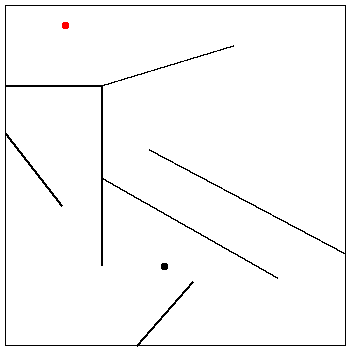

[1.3428526354331396, 1.2110077972335074, 2.3634206383623266, 0.7827277528565915, 1.186011646859579, 3.977817459305204, 1.0, 0.0, 0.0, 0.0]
Step 130:


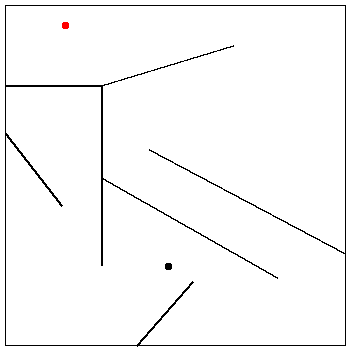

[1.286034453614958, 1.1597681754083948, 2.2634206383623257, 0.7073030295300263, 1.071725932573865, 4.077817459305204, 1.0, 0.0, 0.0, 0.0]
Step 131:


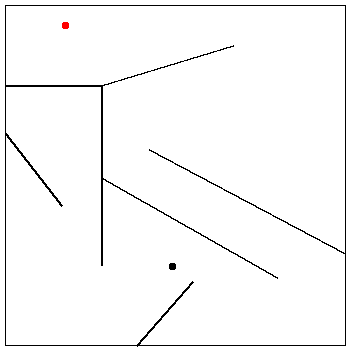

[1.2292162717967763, 1.108528553583283, 2.163420638362326, 0.6318783062034621, 0.9574402182881512, 4.177817459305204, 1.0, 0.0, 0.0, 0.0]
Step 132:


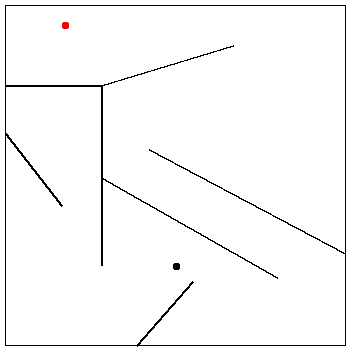

[1.1723980899785946, 1.0572889317581713, 2.0634206383623264, 0.5564535828768965, 0.8431545040024373, 4.277817459305203, 1.0, 0.0, 0.0, 0.0]
Step 133:


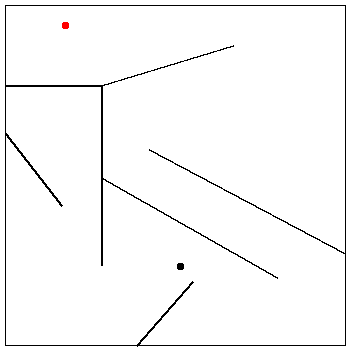

[1.115579908160413, 1.0060493099330594, 1.9634206383623276, 2.772792206135773, 0.7288687897167234, 4.377817459305203, 1.0, 0.0, 0.0, 0.0]
Step 134:


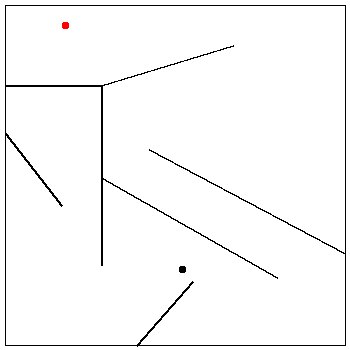

[1.0335855418171174, 2.0171607537325045, 2.672792206135773, 0.5773459080338927, 2.672792206135773, 2.897056274847715, 0.0, 0.0, 0.0, 1.0]
Step 135:


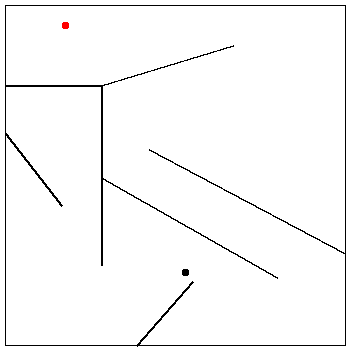

[1.061121773701175, 2.0709008691026822, 2.5727922061357735, 0.4258230263510612, 2.572792206135773, 2.9970562748477145, 0.0, 0.0, 0.0, 1.0]
Step 136:


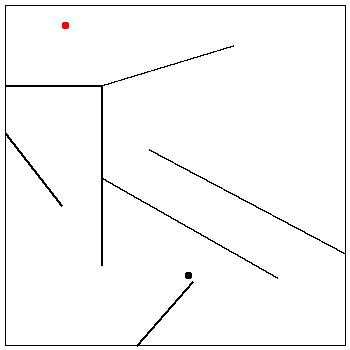

[1.088658005585233, 2.12464098447286, 2.4727922061357734, 0.2743001446682296, 2.4727922061357734, 3.0970562748477146, 0.0, 0.0, 0.0, 1.0]
Step 137:


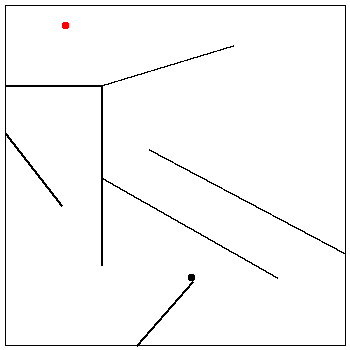

[1.1161942374692908, 3.8393398282201785, 2.372792206135774, 0.12277726298539804, 2.372792206135774, 3.1970562748477143, 0.0, 0.0, 0.0, 1.0]
Step 138:


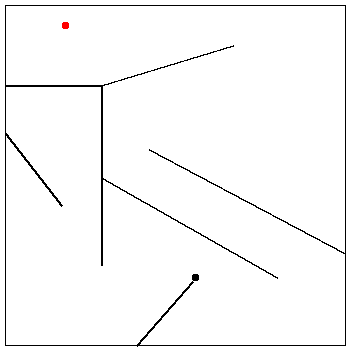

[1.1808983521835446, 1.0649546156441791, 3.739339828220179, 2.3727922061357742, 1.677817459305194, 4.760660171779821, 1.0, 0.0, 0.0, 0.0]
Step 139:


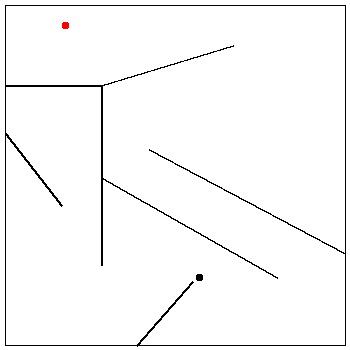

[1.124080170365363, 1.0137149938190673, 3.639339828220179, 2.372792206135774, 1.677817459305194, 4.860660171779821, 1.0, 0.0, 0.0, 0.0]
Step 140:


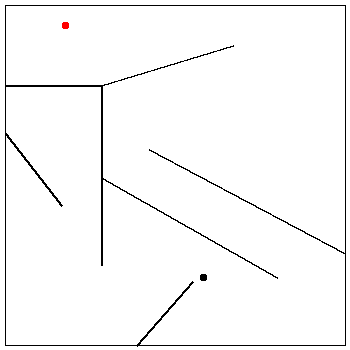

[1.0672619885471812, 0.9624753719939549, 3.5393398282201796, 2.372792206135774, 1.677817459305194, 4.96066017177982, 1.0, 0.0, 0.0, 0.0]
Step 141:


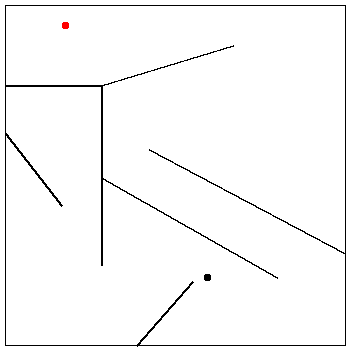

[1.0104438067289996, 0.9112357501688426, 3.43933982822018, 2.372792206135774, 1.677817459305194, 5.06066017177982, 1.0, 0.0, 0.0, 0.0]
Step 142:


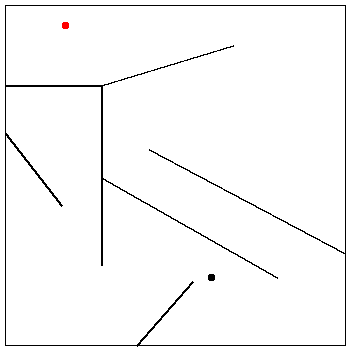

[0.9536256249108179, 0.8599961283437308, 3.3393398282201803, 2.3727922061357742, 1.677817459305194, 5.16066017177982, 1.0, 0.0, 0.0, 0.0]
Step 143:


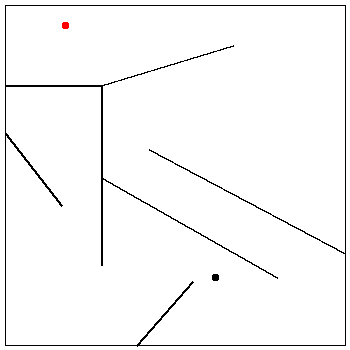

[0.8968074430926363, 0.8087565065186191, 3.2393398282201806, 2.372792206135774, 1.677817459305194, 5.260660171779819, 1.0, 0.0, 0.0, 0.0]
Step 144:


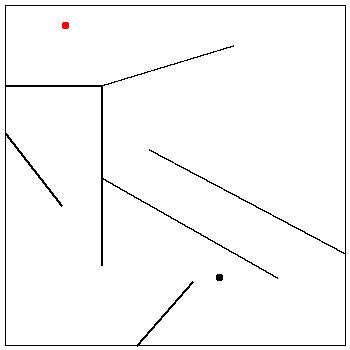

[0.8399892612744546, 0.7575168846935074, 3.139339828220181, 2.372792206135774, 1.677817459305194, 5.360660171779819, 1.0, 0.0, 0.0, 0.0]
Step 145:


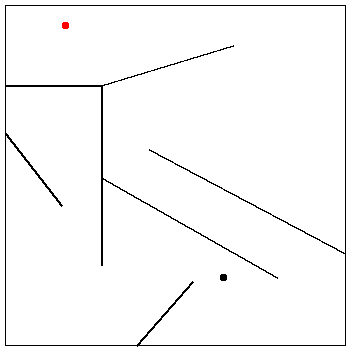

[0.783171079456273, 0.706277262868395, 3.0393398282201813, 2.372792206135774, 1.677817459305194, 5.460660171779819, 1.0, 0.0, 0.0, 0.0]
Step 146:


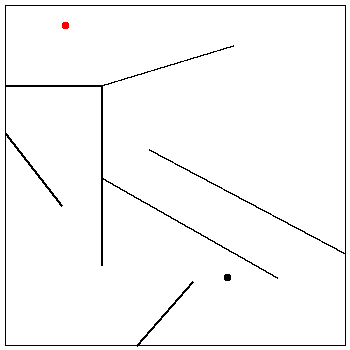

[0.7263528976380913, 0.6550376410432832, 2.9393398282201817, 2.3727922061357742, 1.677817459305194, 5.560660171779818, 1.0, 0.0, 0.0, 0.0]
Step 147:


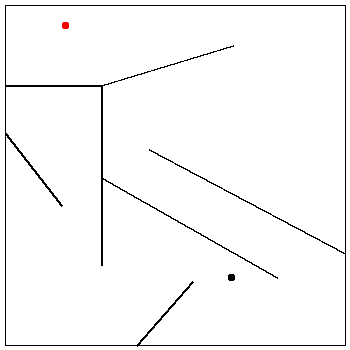

[0.6695347158199096, 0.6037980192181709, 2.839339828220182, 2.372792206135774, 1.677817459305194, 5.660660171779818, 1.0, 0.0, 0.0, 0.0]
Step 148:


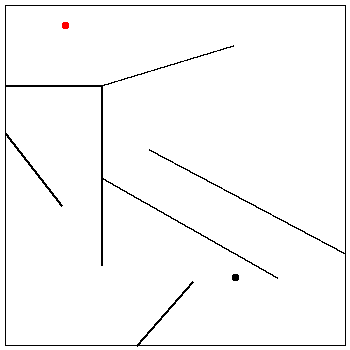

[0.612716534001728, 0.5525583973930591, 2.7393398282201824, 2.3727922061357742, 1.677817459305194, 5.760660171779818, 1.0, 0.0, 0.0, 0.0]
Step 149:


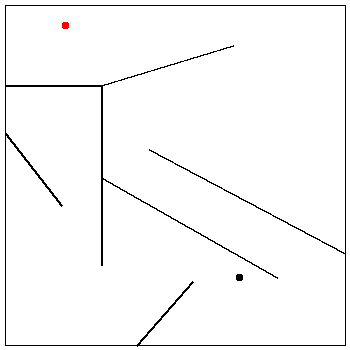

[0.5558983521835463, 0.5013187755679475, 2.6393398282201828, 2.372792206135774, 1.677817459305194, 5.860660171779817, 1.0, 0.0, 0.0, 0.0]
Step 150:


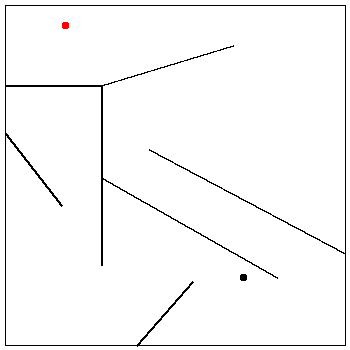

[0.4990801703653647, 0.4500791537428357, 2.539339828220183, 2.3727922061357742, 1.677817459305194, 5.960660171779817, 1.0, 0.0, 0.0, 0.0]
Step 151:


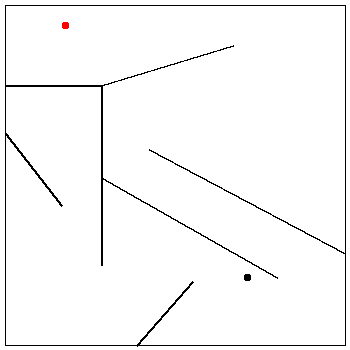

[0.442261988547183, 0.3988395319177233, 2.4393398282201835, 2.372792206135774, 1.677817459305194, 6.0606601717798165, 1.0, 0.0, 0.0, 0.0]
Step 152:


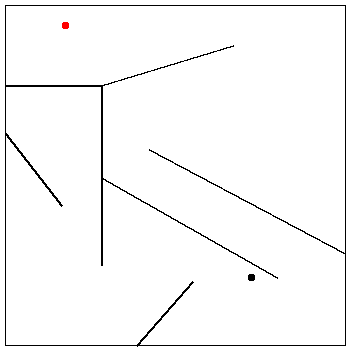

[0.38544380672900136, 0.34759991009261093, 2.339339828220184, 2.3727922061357742, 1.677817459305194, 6.160660171779816, 1.0, 0.0, 0.0, 0.0]
Step 153:


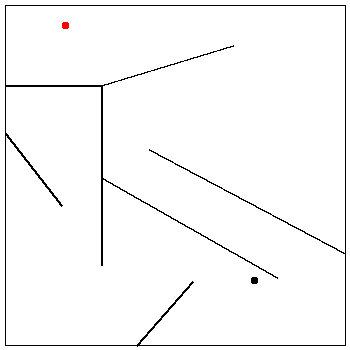

[0.37513614197666945, 2.268629150101529, 2.2727922061357746, 1.6071067811865394, 2.272792206135774, 1.3623365155994849, 0.0, 0.0, 0.0, 1.0]
Step 154:


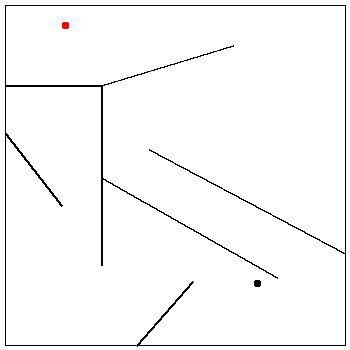

[0.40267237386072663, 2.1979184719828746, 2.172792206135774, 1.5363961030678848, 2.1727922061357736, 1.4623365155994847, 0.0, 0.0, 0.0, 1.0]
Step 155:


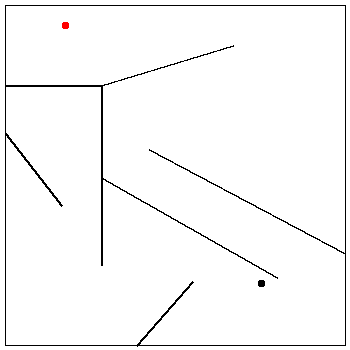

[0.3896939378314759, 0.35143275203561486, 2.097918471982875, 2.172792206135774, 1.5363961030678848, 1.7577349378327254, 1.0, 0.0, 0.0, 0.0]
Step 156:


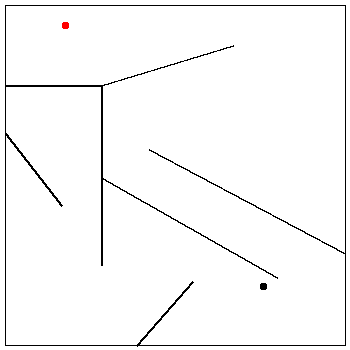

[0.3789689839196733, 2.0272077938642203, 2.0727922061357744, 1.4656854249492302, 2.0727922061357744, 1.376255783708288, 0.0, 0.0, 0.0, 1.0]
Step 157:


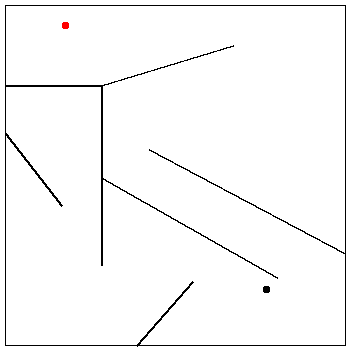

[1.795394320405421, 1.9564971157455657, 1.9727922061357746, 1.3949747468305755, 1.972792206135774, 1.4762557837082877, 0.0, 0.0, 0.0, 1.0]
Step 158:


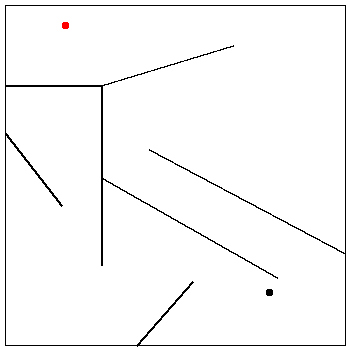

[1.8260609870720885, 1.8857864376269111, 1.872792206135775, 1.324264068711921, 1.872792206135775, 1.5762557837082876, 0.0, 0.0, 0.0, 1.0]
Step 159:


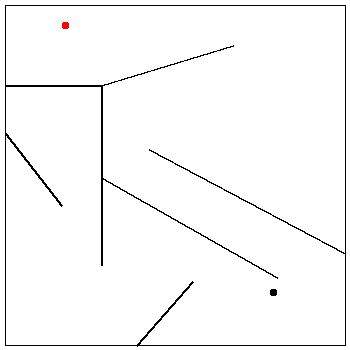

[0.42447822539427893, 1.777034916909821, 1.7857864376269115, 1.8727922061357754, 1.324264068711921, 2.2554825022501577, 1.0, 0.0, 0.0, 0.0]
Step 160:


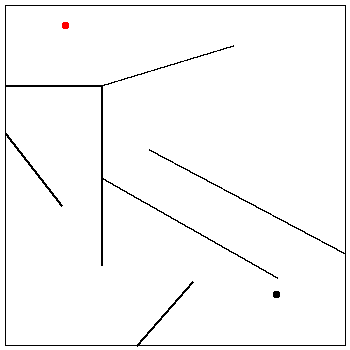

[1.8077015835764882, 1.7150757595082569, 1.7727922061357757, 1.2535533905932663, 1.772792206135775, 1.4901750518170918, 0.0, 0.0, 0.0, 1.0]
Step 161:


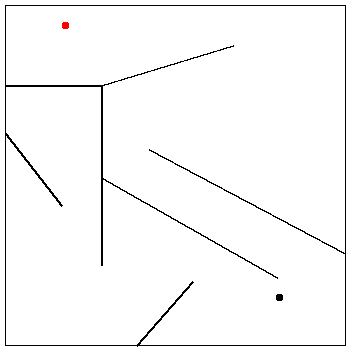

[1.8383682502431538, 1.6443650813896022, 1.6727922061357758, 1.1828427124746117, 1.6727922061357752, 1.5901750518170916, 0.0, 0.0, 0.0, 1.0]
Step 162:


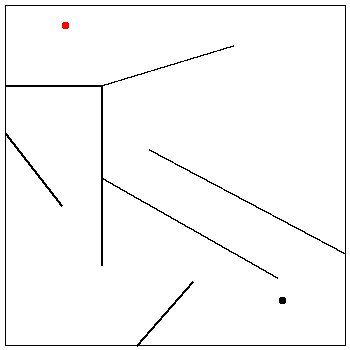

[1.869034916909821, 1.5736544032709476, 1.5727922061357762, 1.112132034355957, 1.5727922061357746, 1.6901750518170913, 0.0, 0.0, 0.0, 1.0]
Step 163:


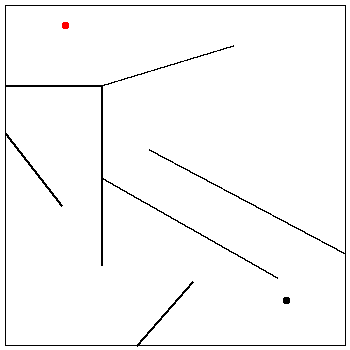

[1.9698070367674028, 1.8200088467475541, 1.473654403270948, 1.5727922061357762, 1.112132034355957, 2.75323006666759, 1.0, 0.0, 0.0, 0.0]
Step 164:


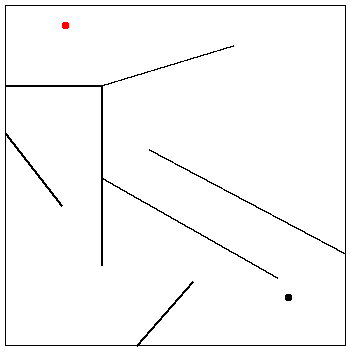

[1.1409364251890546, 1.8615764069939527, 1.7200088467475543, 1.4029437251522934, 1.6727922061357758, 1.6727922061357734, 1.0, 0.0, 0.0, 0.0]
Step 165:


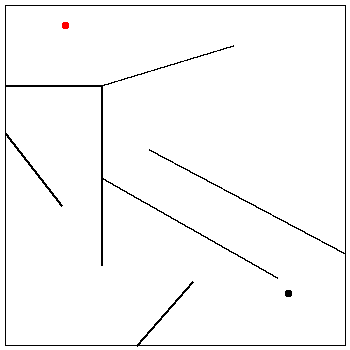

[2.674568901432422, 0.8134343370605492, 1.761576406993953, 1.6276135606725122, 1.4029437251522934, 1.2828427124746113, 0.0, 1.0, 0.0, 0.0]
Step 166:


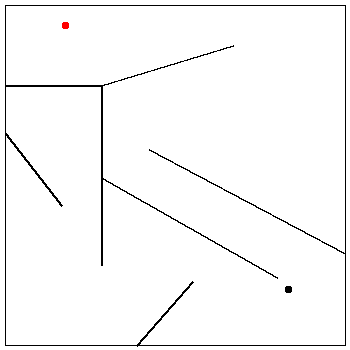

[2.5870689014324215, 0.48593224893204384, 1.6615764069939534, 1.53521827459747, 1.4029437251522934, 1.382842712474611, 0.0, 1.0, 0.0, 0.0]
Step 167:


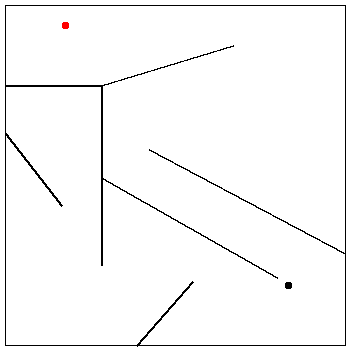

[2.499568901432422, 4.704857571268791, 1.5615764069939537, 1.4428229885224282, 1.4029437251522934, 1.4828427124746106, 0.0, 1.0, 0.0, 0.0]
Step 168:


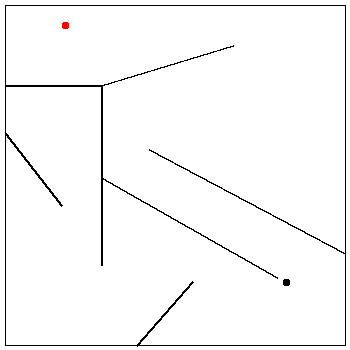

[2.197056274847702, 2.366986379959944, 4.604857571268791, 1.5283856805300946, 1.4121563218557613, 2.0840620433566044, 0.0, 1.0, 0.0, 0.0]
Step 169:


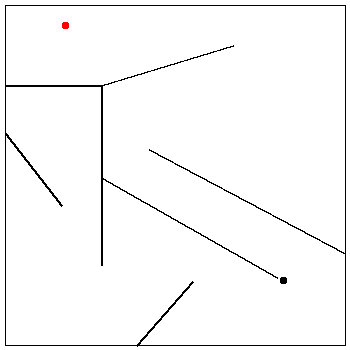

[2.2970562748477015, 6.955634918610397, 4.504857571268792, 1.4951949540662364, 1.3814896551890952, 2.184062043356604, 0.0, 1.0, 0.0, 0.0]
Step 170:


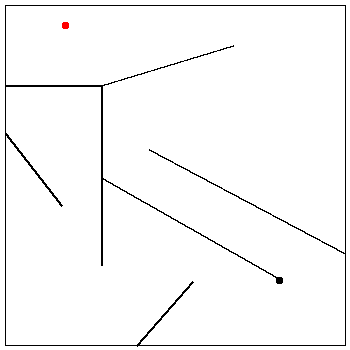

[1.6242640687119199, 2.2970562748477015, 6.855634918610398, 0.14451089269473463, 1.5482561785560325, 1.6443650813896022, 0.0, 0.0, 1.0, 0.0]
Step 171:


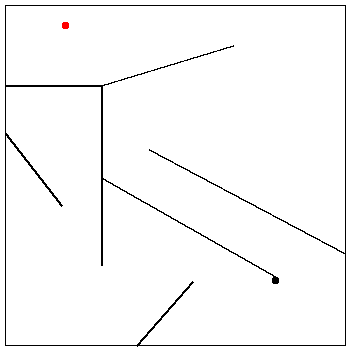

[1.6242640687119199, 2.297056274847702, 6.755634918610398, 0.33059162458593094, 0.1009433638958086, 1.744365081389602, 0.0, 0.0, 1.0, 0.0]
Step 172:


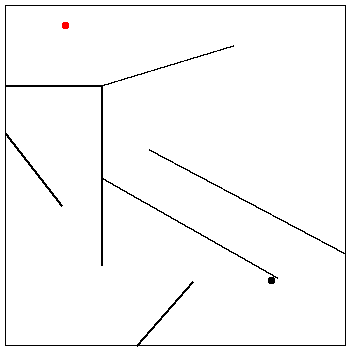

[1.6242640687119199, 2.2970562748477015, 6.6556349186103985, 0.5166723564771273, 0.15776154571399026, 1.8443650813896015, 0.0, 0.0, 1.0, 0.0]
Step 173:


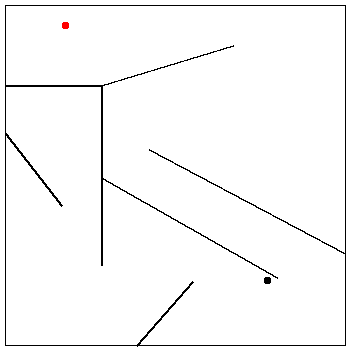

[1.6242640687119199, 2.297056274847702, 6.555634918610399, 0.7027530883683231, 0.21457972753217192, 1.9443650813896012, 0.0, 0.0, 1.0, 0.0]
Step 174:


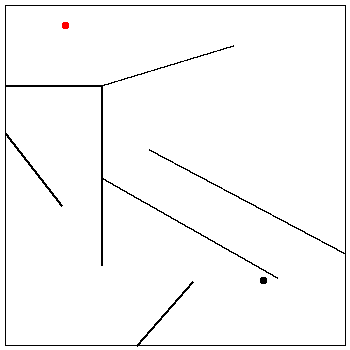

[1.6242640687119199, 2.2970562748477015, 6.455634918610399, 0.8888338202595194, 0.27139790935035357, 2.044365081389601, 0.0, 0.0, 1.0, 0.0]
Step 175:


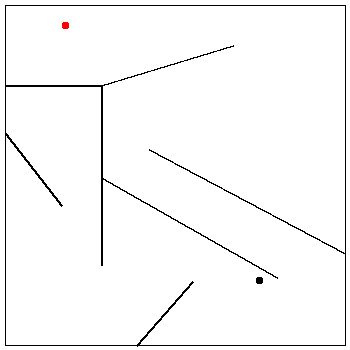

[1.6242640687119199, 2.297056274847702, 6.3556349186103995, 1.0749145521507157, 0.32821609116853523, 2.1443650813896005, 0.0, 0.0, 1.0, 0.0]
Step 176:


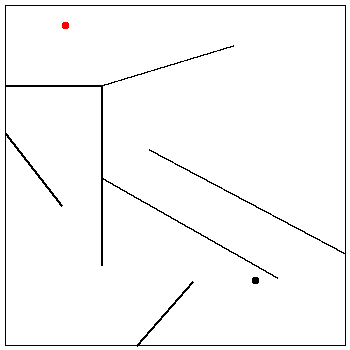

[1.6242640687119199, 2.2970562748477015, 6.2556349186104, 1.2609952840419107, 0.3850342729867169, 2.2443650813896, 0.0, 0.0, 1.0, 0.0]
Step 177:


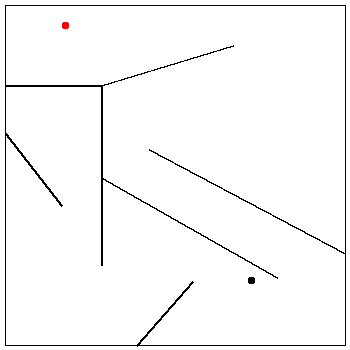

[1.6242640687119199, 2.297056274847702, 6.1556349186104, 1.4470760159331078, 0.44185245480489854, 2.3443650813895998, 0.0, 0.0, 1.0, 0.0]
Step 178:


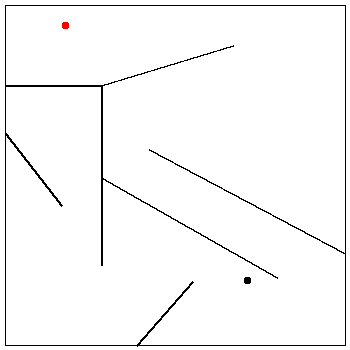

[1.6242640687119199, 2.2970562748477015, 6.055634918610401, 1.6331567478243036, 0.4986706366230802, 2.4443650813895994, 0.0, 0.0, 1.0, 0.0]
Step 179:


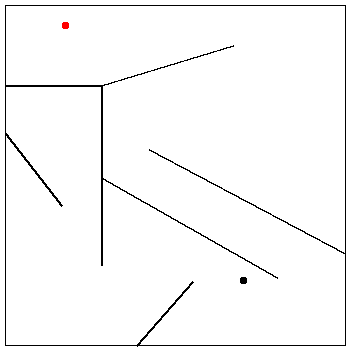

[1.6242640687119199, 2.297056274847702, 5.955634918610401, 1.8192374797154993, 0.5554888184412619, 2.544365081389599, 0.0, 0.0, 1.0, 0.0]
Step 180:


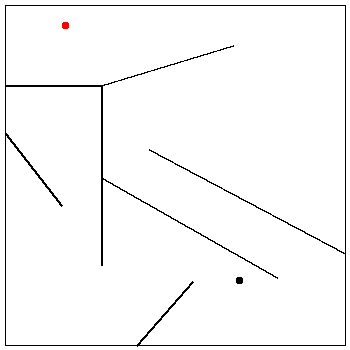

[1.6242640687119199, 2.2970562748477015, 5.855634918610401, 2.0053182116066957, 0.6123070002594435, 2.6443650813895987, 0.0, 0.0, 1.0, 0.0]
Step 181:


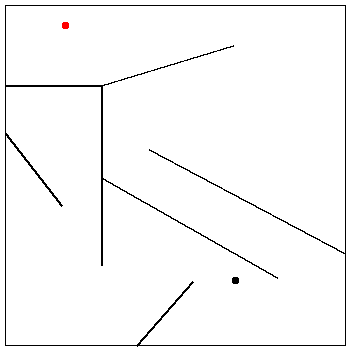

[1.6242640687119199, 2.297056274847702, 5.755634918610402, 2.1913989434978913, 0.6691251820776252, 2.7443650813895983, 0.0, 0.0, 1.0, 0.0]
Step 182:


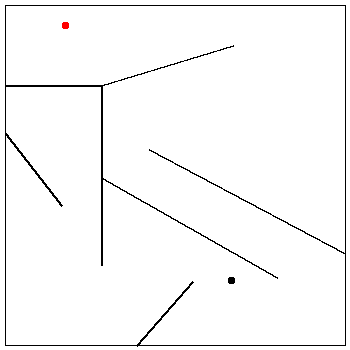

[1.6242640687119199, 2.2970562748477015, 5.655634918610402, 2.3774796753890888, 0.7259433638958068, 2.844365081389598, 0.0, 0.0, 1.0, 0.0]
Step 183:


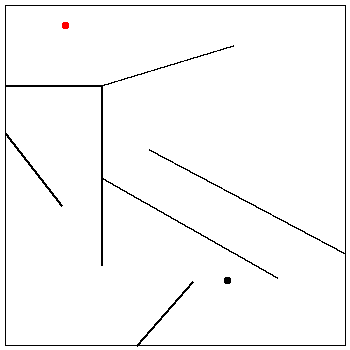

[1.6242640687119199, 2.297056274847702, 5.555634918610402, 2.5635604072802844, 0.7827615457139885, 2.9443650813895976, 0.0, 0.0, 1.0, 0.0]
Step 184:


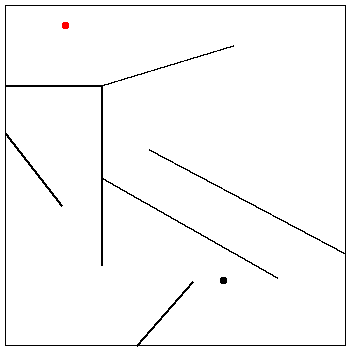

[1.6242640687119199, 2.2970562748477015, 5.455634918610403, 2.7496411391714806, 0.8395797275321701, 3.0443650813895973, 0.0, 0.0, 1.0, 0.0]
Step 185:


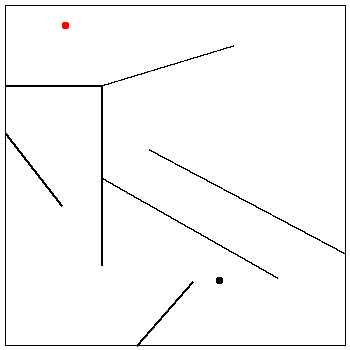

[1.6242640687119199, 2.297056274847702, 5.355634918610403, 2.9357218710626762, 0.8963979093503518, 3.144365081389597, 0.0, 0.0, 1.0, 0.0]
Step 186:


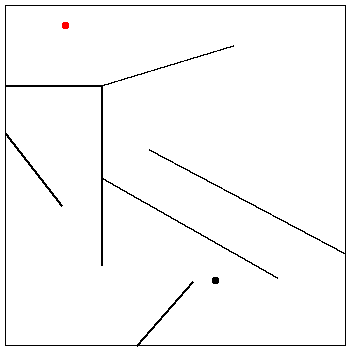

[1.6242640687119199, 2.297056274847702, 5.255634918610403, 3.121802602953873, 0.9532160911685326, 3.2443650813895966, 0.0, 0.0, 1.0, 0.0]
Step 187:


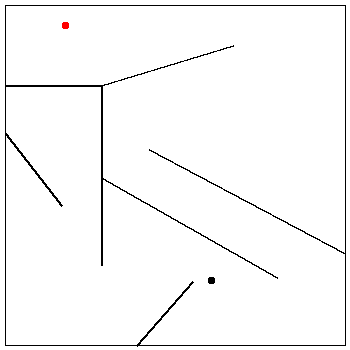

[1.6242640687119199, 2.297056274847702, 5.155634918610404, 3.3078833348450685, 1.010034272986715, 3.344365081389596, 0.0, 0.0, 1.0, 0.0]
Step 188:


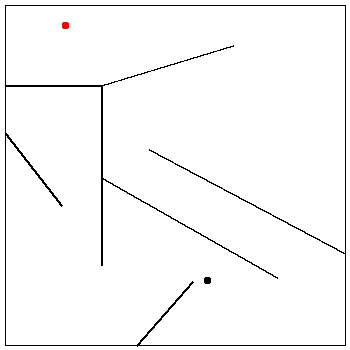

[1.6242640687119199, 2.2970562748477015, 5.055634918610404, 3.4939640667362646, 1.0668524548048959, 3.444365081389596, 0.0, 0.0, 1.0, 0.0]
Step 189:


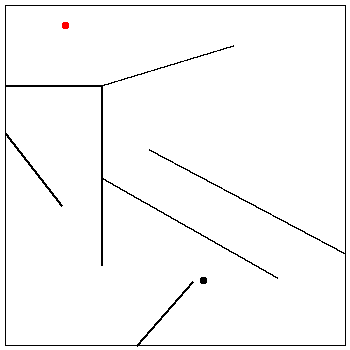

[1.6242640687119199, 2.2970562748477015, 4.9556349186104045, 3.6142135623730947, 1.1236706366230775, 3.5443650813895955, 0.0, 0.0, 1.0, 0.0]
Step 190:


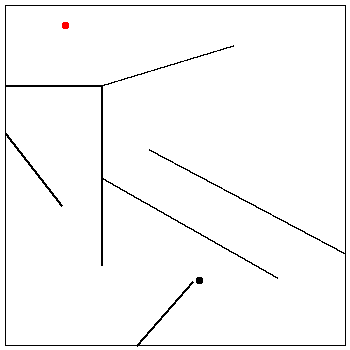

[1.6242640687119199, 1.5206060760660913, 4.855634918610405, 3.4727922061357854, 1.1804888184412592, 3.644365081389595, 0.0, 0.0, 1.0, 0.0]
Step 191:


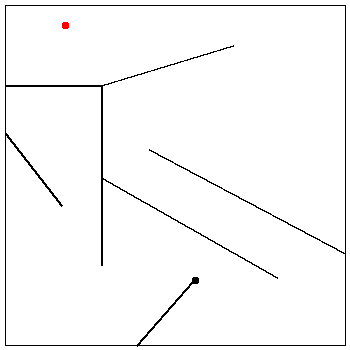

[1.6242640687119199, 0.3892352261676144, 4.755634918610405, 3.3313708498984766, 1.2373070002594408, 3.744365081389595, 0.0, 0.0, 1.0, 0.0]
Step 192:


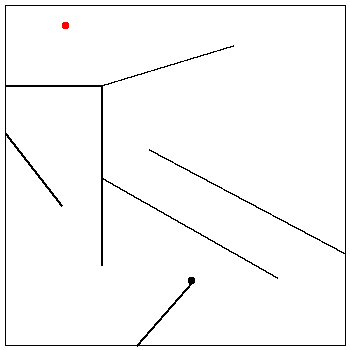

[0.0749670188714564, 2.2970562748477015, 4.655634918610406, 3.189949493661168, 1.2941251820776225, 3.8443650813895944, 0.0, 0.0, 1.0, 0.0]
Step 193:


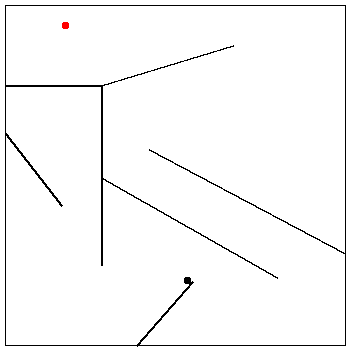

[0.18925273315717028, 2.297056274847702, 4.555634918610406, 3.048528137423858, 1.3509433638958042, 3.944365081389594, 0.0, 0.0, 1.0, 0.0]
Step 194:


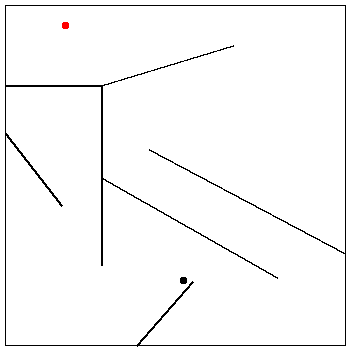

[0.30353844744288416, 2.2970562748477015, 4.455634918610406, 2.90710678118655, 1.4077615457139858, 4.044365081389594, 0.0, 0.0, 1.0, 0.0]
Step 195:


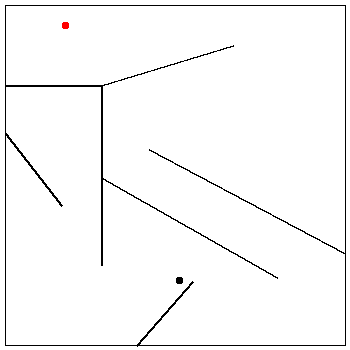

[0.41782416172859804, 2.297056274847702, 4.355634918610407, 2.7656854249492406, 1.4645797275321675, 4.144365081389593, 0.0, 0.0, 1.0, 0.0]
Step 196:


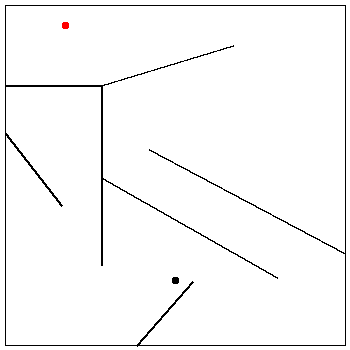

[0.5321098760143119, 2.2970562748477015, 4.255634918610407, 2.624264068711932, 1.5213979093503491, 4.244365081389593, 0.0, 0.0, 1.0, 0.0]
Step 197:


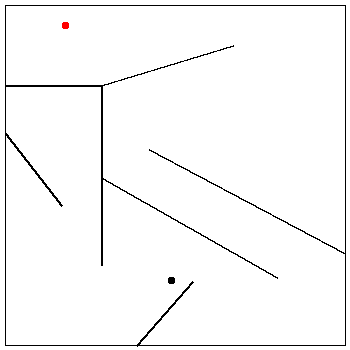

[0.6463955903000258, 2.2970562748477015, 4.155634918610407, 2.482842712474622, 1.5782160911685308, 4.344365081389593, 0.0, 0.0, 1.0, 0.0]
Step 198:


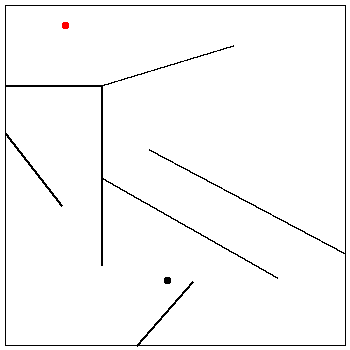

[0.7606813045857397, 2.2970562748477015, 4.055634918610408, 2.341421356237314, 1.6350342729867124, 4.444365081389592, 0.0, 0.0, 1.0, 0.0]
Step 199:


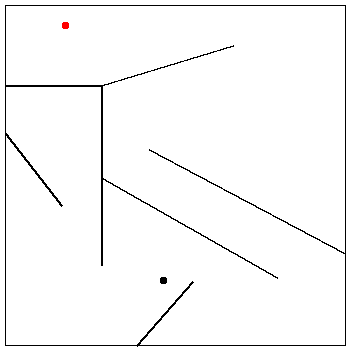

[0.8749670188714544, 2.2970562748477015, 3.9556349186104076, 2.2000000000000037, 1.691852454804894, 4.544365081389593, 0.0, 0.0, 1.0, 0.0]
Step 200:


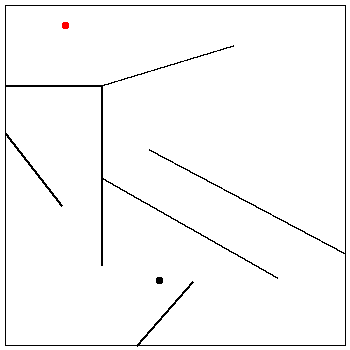

[0.9892527331571683, 2.2970562748477015, 3.8556349186104075, 2.0585786437626945, 1.7486706366230758, 4.6443650813895925, 0.0, 0.0, 1.0, 0.0]
Step 201:


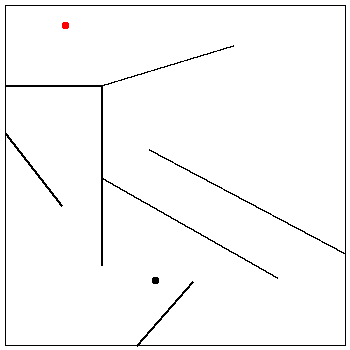

[1.103538447442883, 2.2970562748477015, 3.7556349186104074, 1.9171572875253846, 1.8054888184412583, 4.744365081389592, 0.0, 0.0, 1.0, 0.0]
Step 202:


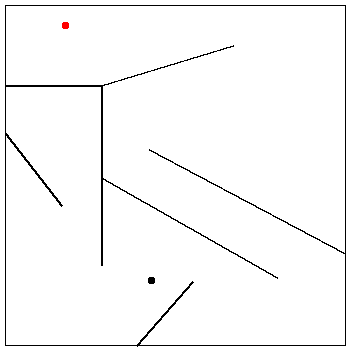

[1.217824161728597, 2.2970562748477015, 3.6556349186104073, 1.7757359312880754, 1.86230700025944, 4.844365081389593, 0.0, 0.0, 1.0, 0.0]
Step 203:


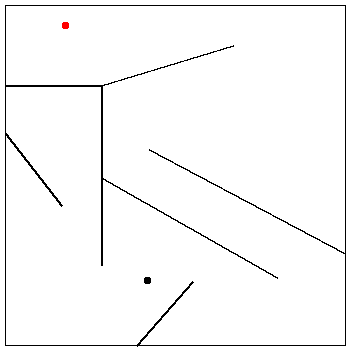

[1.3321098760143109, 2.297056274847702, 3.5556349186104073, 1.6343145750507653, 1.9191251820776216, 4.944365081389593, 0.0, 0.0, 1.0, 0.0]
Step 204:


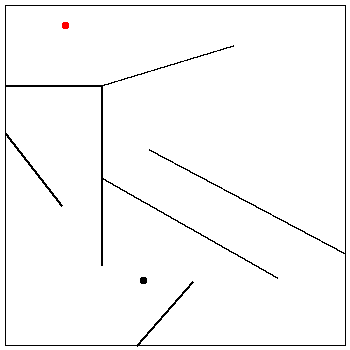

[1.4463955903000265, 2.2970562748477015, 3.455634918610407, 1.492893218813456, 1.9759433638958033, 5.044365081389593, 0.0, 0.0, 1.0, 0.0]
Step 205:


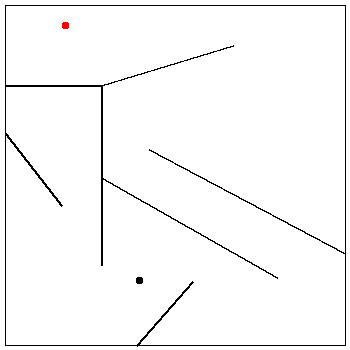

[1.5606813045857404, 2.2970562748477015, 3.355634918610407, 1.3514718625761466, 2.032761545713986, 5.1443650813895925, 0.0, 0.0, 1.0, 0.0]
Step 206:


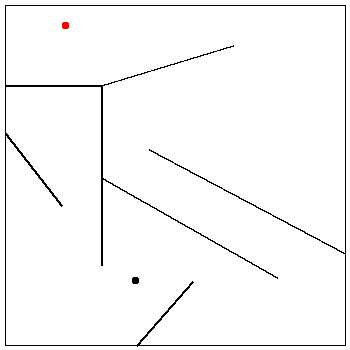

[1.6242640687119199, 2.2970562748477015, 3.255634918610407, 1.2100505063388367, 2.0895797275321675, 5.244365081389593, 0.0, 0.0, 1.0, 0.0]
Step 207:


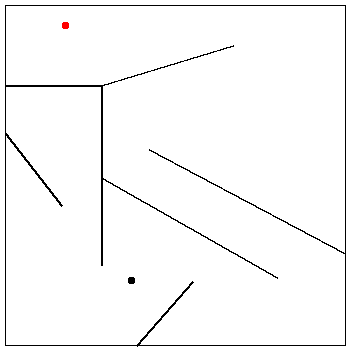

[1.6242640687119199, 2.297056274847702, 3.155634918610407, 1.0686291501015275, 2.146397909350349, 5.3443650813895935, 0.0, 0.0, 1.0, 0.0]
Step 208:


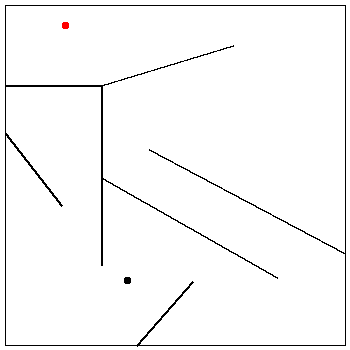

[1.6242640687119199, 2.2970562748477015, 3.055634918610407, 0.9272077938642175, 2.203216091168531, 5.444365081389593, 0.0, 0.0, 1.0, 0.0]
Step 209:


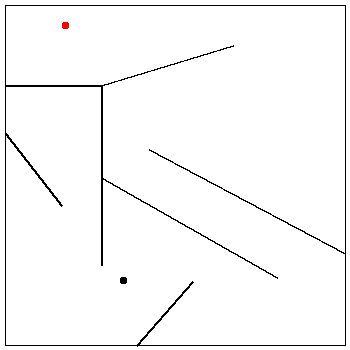

[1.6242640687119199, 2.297056274847702, 2.9556349186104067, 0.7857864376269081, 2.2600342729867124, 5.544365081389593, 0.0, 0.0, 1.0, 0.0]
Step 210:


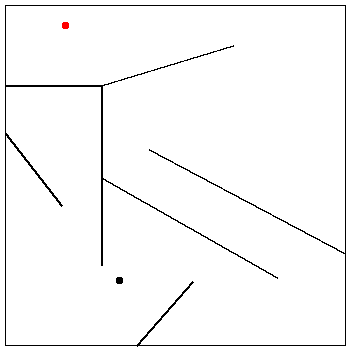

[1.6242640687119199, 2.297056274847702, 2.8556349186104066, 0.6443650813895988, 2.316852454804895, 5.644365081389593, 0.0, 0.0, 1.0, 0.0]
Step 211:


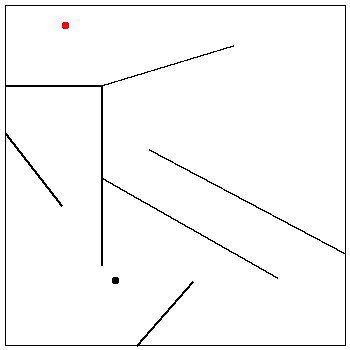

[1.6242640687119199, 2.297056274847702, 2.7556349186104065, 3.8970562748477158, 2.3736706366230766, 5.744365081389594, 0.0, 0.0, 1.0, 0.0]
Step 212:


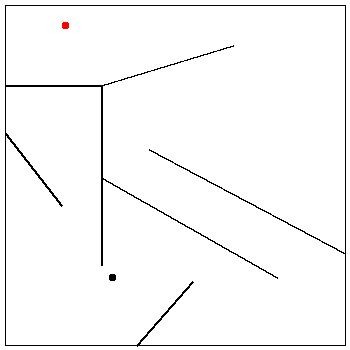

[2.397056274847701, 2.684924240491752, 3.797056274847716, 2.343136480162749, 2.113081117455679, 1.582545451453459, 0.0, 1.0, 0.0, 0.0]
Step 213:


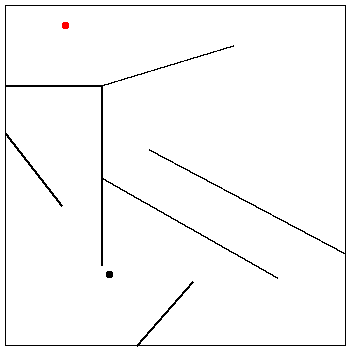

[2.497056274847701, 2.6142135623730973, 3.6970562748477165, 2.3126023237024205, 2.0855448855716214, 1.6825454514534586, 0.0, 1.0, 0.0, 0.0]
Step 214:


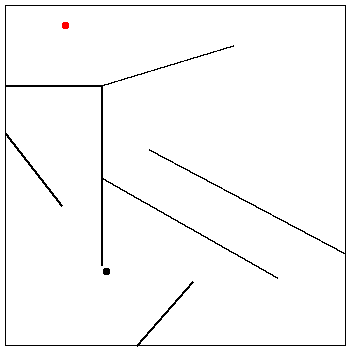

[2.5970562748477013, 2.5435028842544427, 3.5970562748477164, 2.282068167242092, 2.0580086536875637, 1.7825454514534587, 0.0, 1.0, 0.0, 0.0]
Step 215:


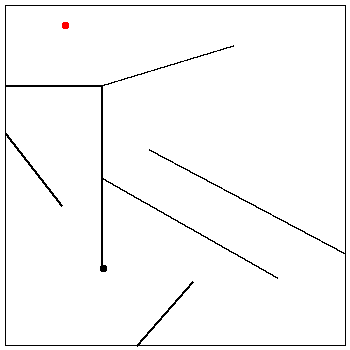

[2.697056274847701, 2.472792206135788, 3.4970562748477168, 2.2515340107817643, 2.0304724218035055, 1.8825454514534583, 0.0, 1.0, 0.0, 0.0]
Step 216:


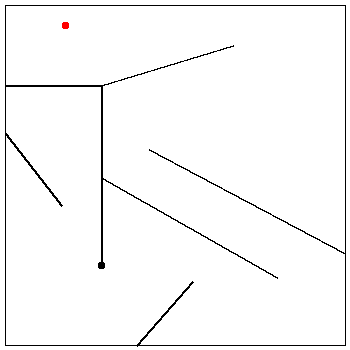

[2.7970562748477006, 2.4020815280171335, 3.397056274847717, 2.2209998543214358, 2.0029361899194473, 1.982545451453458, 0.0, 1.0, 0.0, 0.0]
Step 217:


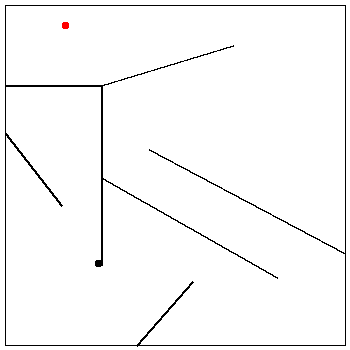

[2.8970562748477002, 2.331370849898479, 3.2970562748477175, 4.4514718625761525, 0.0970562748477093, 2.0825454514534583, 0.0, 1.0, 0.0, 0.0]
Step 218:


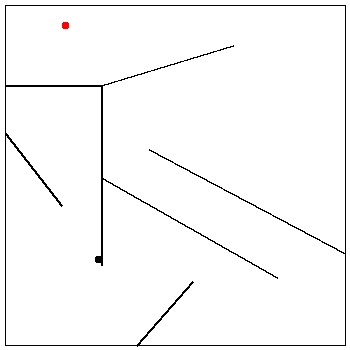

[2.331370849898479, 3.2970562748477175, 4.351471862576153, 0.09705627484770993, 0.06862915010152104, 2.148528137423847, 0.0, 1.0, 0.0, 0.0]
Step 219:


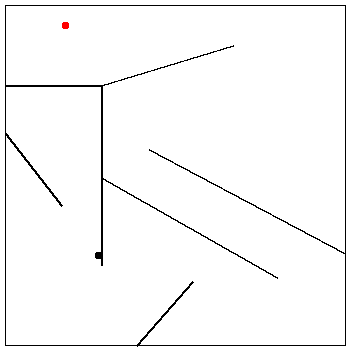

[2.331370849898479, 3.2970562748477175, 4.251471862576153, 0.0970562748477093, 0.06862915010152104, 2.248528137423847, 0.0, 1.0, 0.0, 0.0]
Step 220:


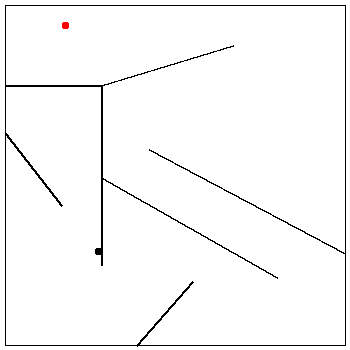

[2.331370849898479, 3.2970562748477175, 4.1514718625761535, 0.09705627484770993, 0.06862915010152104, 2.3485281374238465, 0.0, 1.0, 0.0, 0.0]
Step 221:


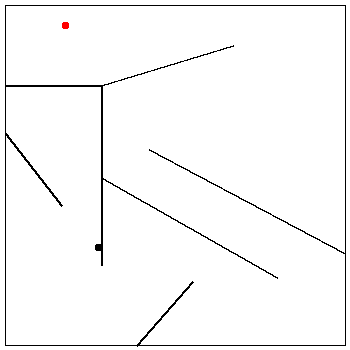

[2.331370849898479, 3.2970562748477175, 4.051471862576154, 0.09705627484770993, 0.06862915010152104, 2.448528137423846, 0.0, 1.0, 0.0, 0.0]
Step 222:


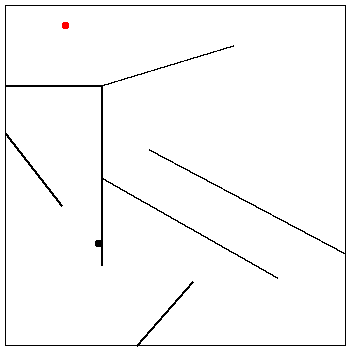

[2.331370849898479, 3.2970562748477175, 3.9514718625761542, 0.09705627484770993, 0.06862915010152104, 2.5485281374238458, 0.0, 1.0, 0.0, 0.0]
Step 223:


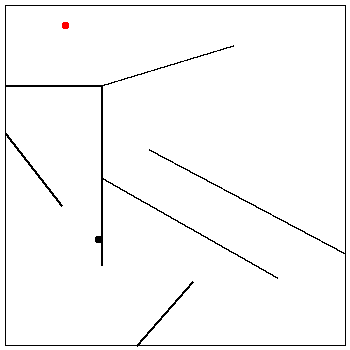

[2.331370849898479, 1.7126370977442553, 3.8514718625761546, 0.09705627484770993, 0.06862915010152104, 2.6485281374238454, 0.0, 1.0, 0.0, 0.0]
Step 224:


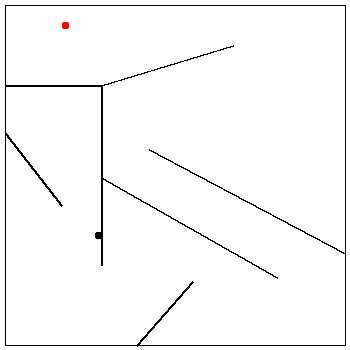

[2.331370849898479, 2.2076118445748376, 3.751471862576155, 0.09705627484770993, 0.06862915010152104, 2.748528137423845, 0.0, 1.0, 0.0, 0.0]
Step 225:


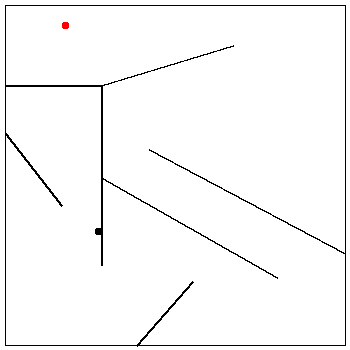

[2.331370849898479, 2.702586591405418, 3.6514718625761553, 0.09705627484770993, 0.06862915010152104, 2.8485281374238447, 0.0, 1.0, 0.0, 0.0]
Step 226:


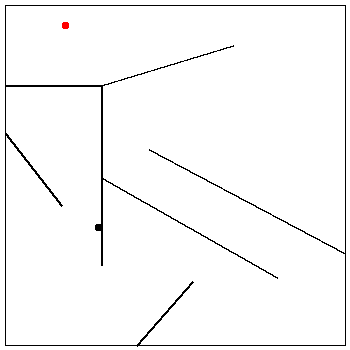

[2.331370849898479, 3.197561338235999, 3.5514718625761557, 0.09705627484770993, 0.06862915010152104, 2.9485281374238443, 0.0, 1.0, 0.0, 0.0]
Step 227:


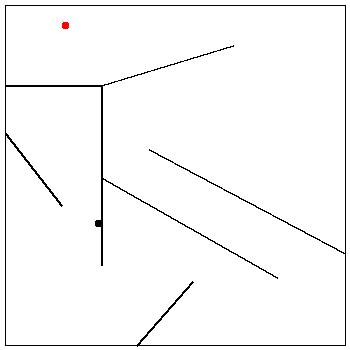

[2.331370849898479, 3.2970562748477175, 3.451471862576156, 0.09705627484770993, 0.06862915010152104, 3.048528137423844, 0.0, 1.0, 0.0, 0.0]
Step 228:


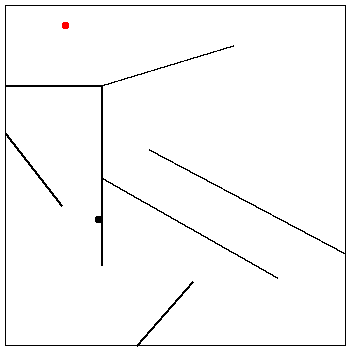

[2.331370849898479, 3.2970562748477175, 3.3514718625761564, 0.09705627484770993, 0.06862915010152104, 3.1485281374238436, 0.0, 1.0, 0.0, 0.0]
Step 229:


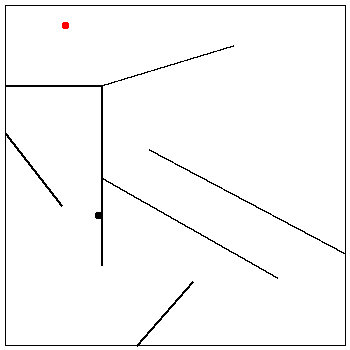

[2.331370849898479, 3.2970562748477175, 3.2514718625761567, 0.09705627484770993, 0.06862915010152104, 3.2485281374238433, 0.0, 1.0, 0.0, 0.0]
Step 230:


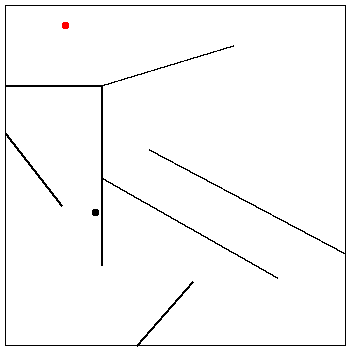

[3.1970562748477183, 2.2606601717798243, 3.1970562748477174, 3.180761184457502, 0.19705627484770974, 0.19705627484770974, 0.0, 1.0, 0.0, 0.0]
Step 231:


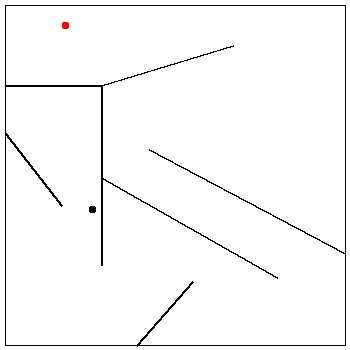

[3.0970562748477186, 2.1899494936611696, 3.0970562748477177, 3.1100505063388475, 0.2970562748477095, 0.2970562748477095, 0.0, 1.0, 0.0, 0.0]
Step 232:


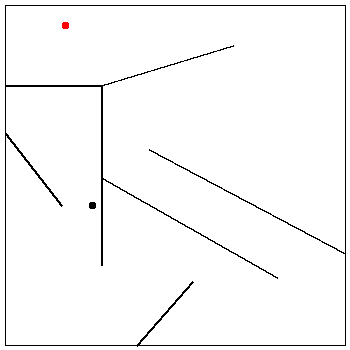

[2.1899494936611696, 3.0970562748477177, 3.010050506338848, 0.2970562748477095, 0.21005050633883027, 3.489949493661152, 0.0, 1.0, 0.0, 0.0]
Step 233:


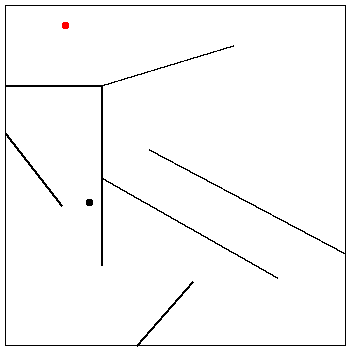

[2.997056274847719, 0.7664189491490314, 2.997056274847718, 2.9393398282201932, 0.39705627484770933, 0.39705627484770933, 0.0, 1.0, 0.0, 0.0]
Step 234:


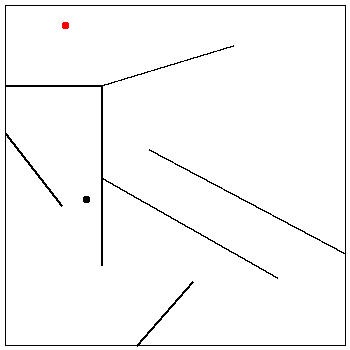

[2.8970562748477193, 0.7507054651226637, 2.8970562748477184, 2.8686291501015386, 0.49705627484770915, 0.49705627484770915, 0.0, 1.0, 0.0, 0.0]
Step 235:


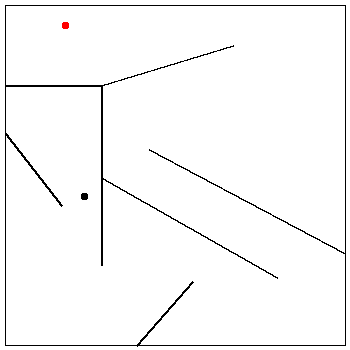

[2.7970562748477192, 0.7349919810962959, 2.797056274847718, 2.797918471982884, 0.5970562748477097, 0.5970562748477091, 0.0, 1.0, 0.0, 0.0]
Step 236:


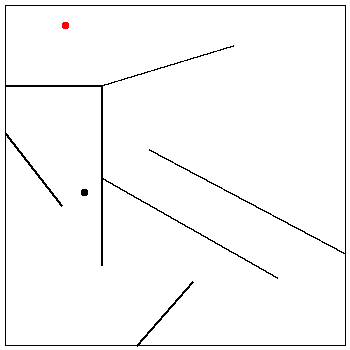

[0.8127697588740732, 2.797056274847718, 2.6979184719828844, 0.5970562748477097, 0.42218254069479433, 3.8020815280171156, 0.0, 1.0, 0.0, 0.0]
Step 237:


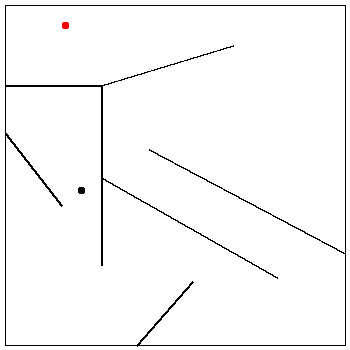

[2.6970562748477187, 0.7970562748477055, 2.697056274847718, 2.6272077938642298, 0.6970562748477097, 0.697056274847709, 0.0, 1.0, 0.0, 0.0]
Step 238:


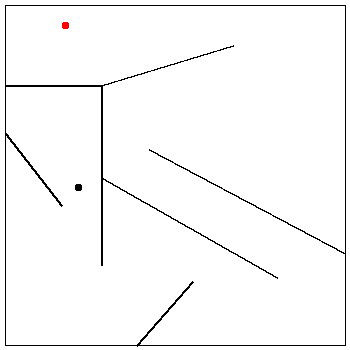

[0.621554384048614, 0.7813427908213375, 2.597056274847718, 2.556497115745575, 0.7970562748477097, 0.7970562748477097, 0.0, 1.0, 0.0, 0.0]
Step 239:


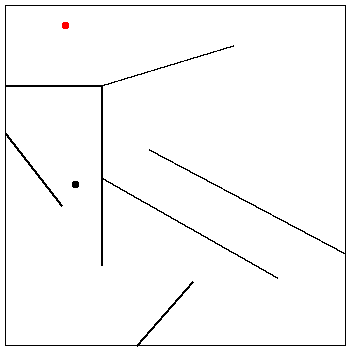

[0.6090543840486136, 0.7656293067949695, 2.497056274847718, 2.4857864376269205, 0.8970562748477099, 0.8970562748477096, 0.0, 1.0, 0.0, 0.0]
Step 240:


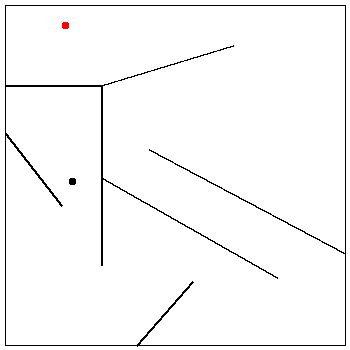

[0.596554384048613, 0.7499158227686017, 2.3970562748477175, 2.415075759508266, 0.9970562748477099, 0.9970562748477095, 0.0, 1.0, 0.0, 0.0]
Step 241:


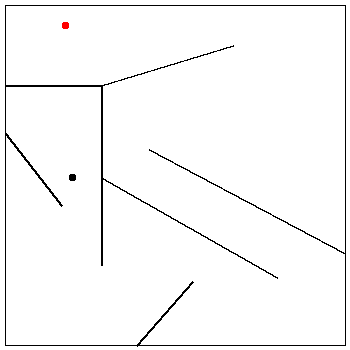

[0.8276936005463792, 2.397056274847718, 2.3150757595082663, 0.9970562748477099, 0.7050252531694137, 4.184924240491734, 0.0, 1.0, 0.0, 0.0]
Step 242:


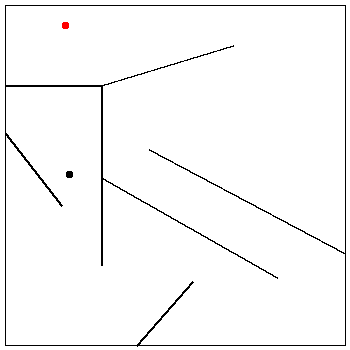

[0.6459262274024357, 0.8119801165200112, 2.2970562748477175, 2.2443650813896117, 1.0970562748477102, 1.0970562748477095, 0.0, 1.0, 0.0, 0.0]
Step 243:


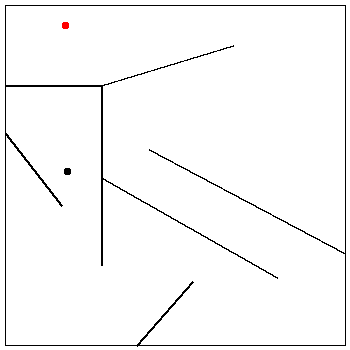

[0.6334262274024359, 0.7962666324936433, 2.1970562748477174, 2.173654403270957, 1.1970562748477105, 1.19705627484771, 0.0, 1.0, 0.0, 0.0]
Step 244:


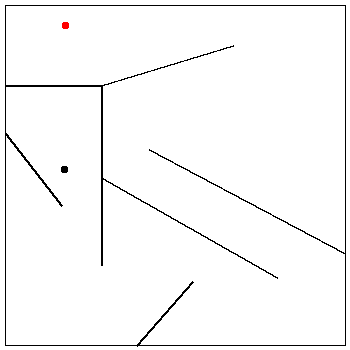

[0.6209262274024355, 0.7805531484672754, 2.0970562748477177, 2.1029437251523024, 1.2970562748477104, 1.2970562748477101, 0.0, 0.0, 1.0, 0.0]
Step 245:


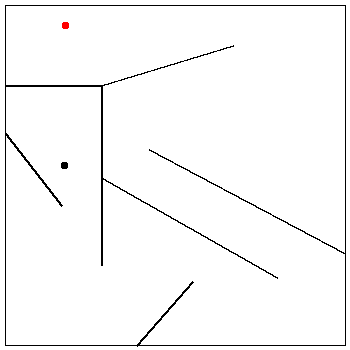

[0.8583309262450529, 2.0970562748477177, 2.002943725152303, 1.2970562748477104, 0.9171572875253782, 4.497056274847697, 0.0, 1.0, 0.0, 0.0]
Step 246:


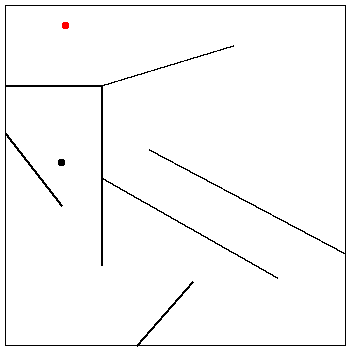

[0.670298070756258, 0.8426174422186851, 1.9970562748477174, 1.9322330470336482, 1.3970562748477107, 1.39705627484771, 0.0, 0.0, 1.0, 0.0]
Step 247:


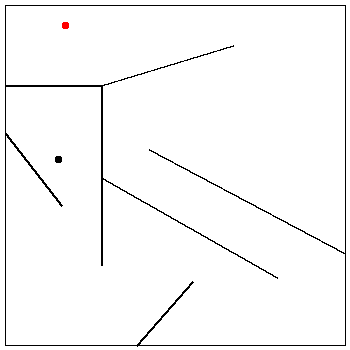

[0.6577980707562583, 0.8269039581923171, 1.897056274847717, 1.8615223689149936, 1.4970562748477108, 1.4970562748477099, 0.0, 0.0, 1.0, 0.0]
Step 248:


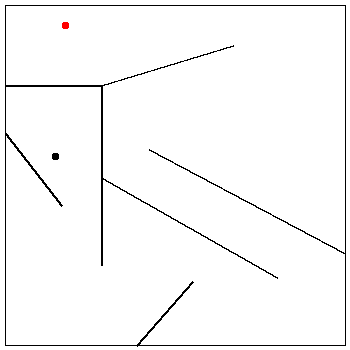

[0.645298070756258, 0.8111904741659491, 1.797056274847717, 1.790811690796339, 1.597056274847711, 1.5970562748477106, 0.0, 0.0, 1.0, 0.0]
Step 249:


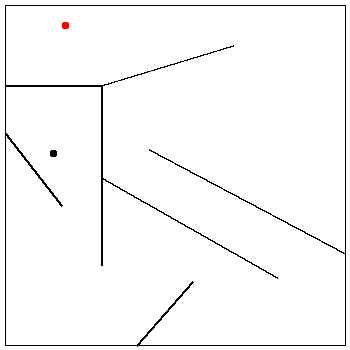

[0.6327980707562575, 0.7954769901395813, 1.6970562748477171, 1.7201010126776843, 1.697056274847711, 1.6970562748477105, 0.0, 0.0, 1.0, 0.0]
Step 250:


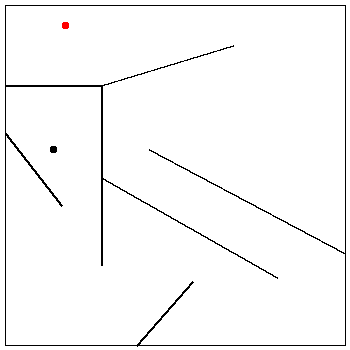

[0.8732547679173591, 1.6970562748477171, 1.6201010126776842, 1.697056274847711, 1.1999999999999975, 1.1227561301794622, 0.0, 1.0, 0.0, 0.0]
Step 251:


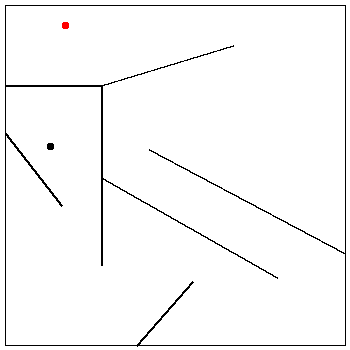

[0.6821699141100805, 0.8575412838909913, 1.5970562748477168, 1.5493903345590296, 1.7970562748477112, 1.7970562748477108, 0.0, 0.0, 1.0, 0.0]
Step 252:


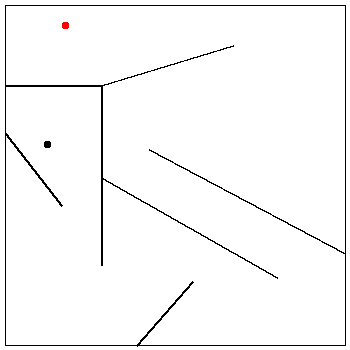

[0.6696699141100805, 0.8418277998646233, 1.497056274847717, 1.478679656440375, 1.8970562748477113, 1.8970562748477109, 0.0, 0.0, 1.0, 0.0]
Step 253:


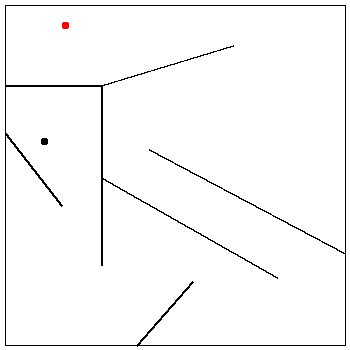

[0.6571699141100804, 0.8261143158382555, 1.397056274847717, 1.4079689783217204, 1.991168824543167, 1.9970562748477105, 0.0, 0.0, 1.0, 0.0]
Step 254:


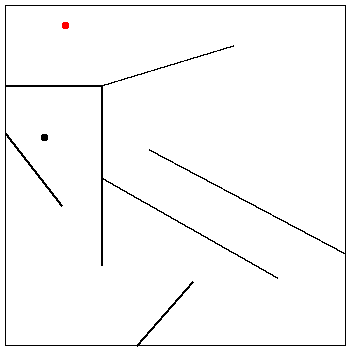

[0.9038920936160333, 1.397056274847717, 1.3079689783217203, 1.849747468305857, 1.4121320343559618, 1.1621469775063291, 0.0, 1.0, 0.0, 0.0]
Step 255:


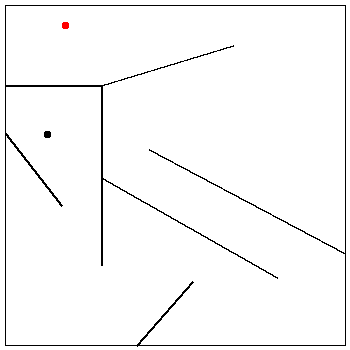

[1.497056274847717, 1.2372583002030657, 1.7497474683058571, 1.3414213562373072, 1.8970562748477104, 0.8190417574639034, 0.0, 1.0, 0.0, 0.0]
Step 256:


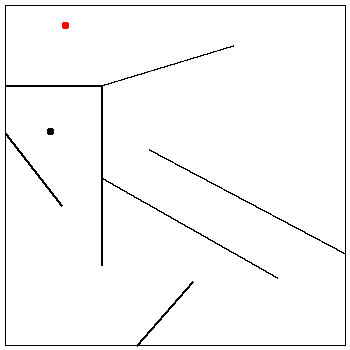

[1.5970562748477168, 1.166547622084411, 1.649747468305858, 1.2707106781186523, 1.7970562748477104, 0.9190417574639032, 0.0, 1.0, 0.0, 0.0]
Step 257:


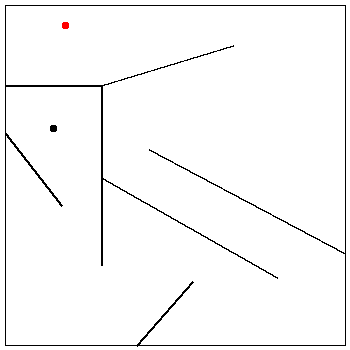

[1.5497474683058585, 1.0958369439657565, 1.549747468305858, 1.1999999999999975, 1.6970562748477105, 1.0190417574639035, 0.0, 1.0, 0.0, 0.0]
Step 258:


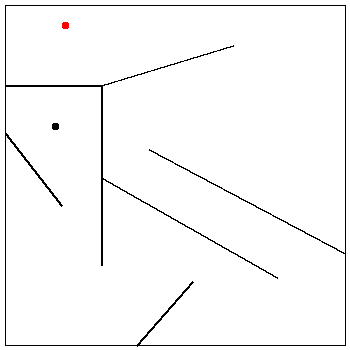

[1.4497474683058587, 1.0251262658471019, 1.4497474683058582, 1.1292893218813427, 1.59705627484771, 1.1190417574639033, 0.0, 1.0, 0.0, 0.0]
Step 259:


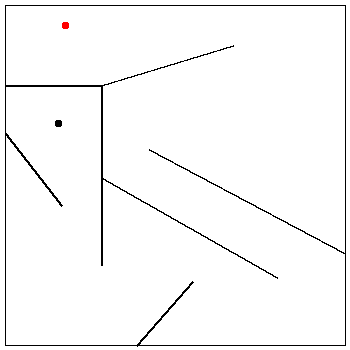

[1.349747468305859, 0.9544155877284473, 1.3497474683058583, 1.0585786437626878, 1.4970562748477099, 1.2190417574639034, 0.0, 1.0, 0.0, 0.0]
Step 260:


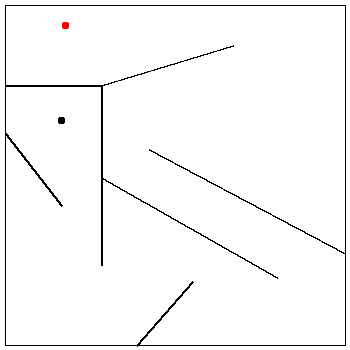

[1.2497474683058591, 0.8837049096097926, 1.2497474683058587, 0.987867965644033, 1.39705627484771, 1.3190417574639033, 0.0, 1.0, 0.0, 0.0]
Step 261:


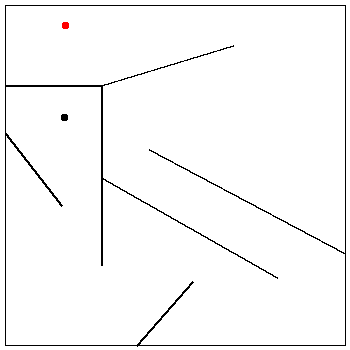

[1.1497474683058593, 0.812994231491138, 1.1497474683058588, 0.9171572875253782, 1.2970562748477101, 1.4190417574639032, 0.0, 1.0, 0.0, 0.0]
Step 262:


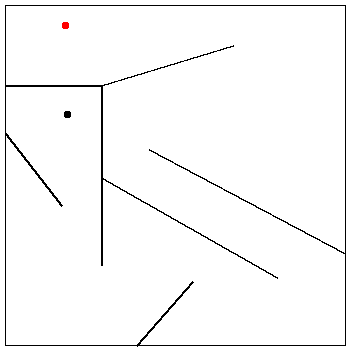

[1.0497474683058594, 0.7422835533724834, 1.049747468305859, 0.8464466094067233, 1.1970562748477098, 1.5190417574639032, 1.0, 0.0, 0.0, 0.0]
Step 263:


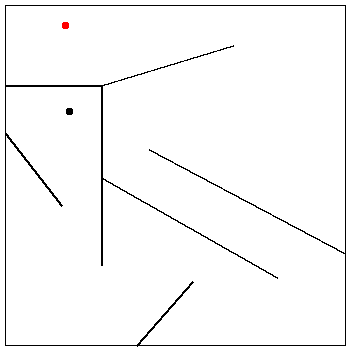

[0.9497474683058597, 0.6715728752538288, 0.9497474683058594, 0.7757359312880685, 1.0970562748477095, 1.619041757463903, 1.0, 0.0, 0.0, 0.0]
Step 264:


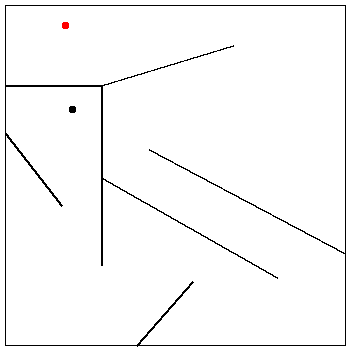

[0.8497474683058598, 0.6008621971351742, 0.8497474683058595, 0.7050252531694137, 0.9970562748477095, 1.7190417574639034, 1.0, 0.0, 0.0, 0.0]
Step 265:


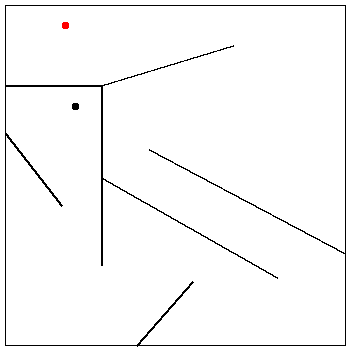

[0.7497474683058598, 0.5301515190165196, 0.7497474683058598, 0.6343145750507588, 0.8970562748477096, 1.819041757463903, 1.0, 0.0, 0.0, 0.0]
Step 266:


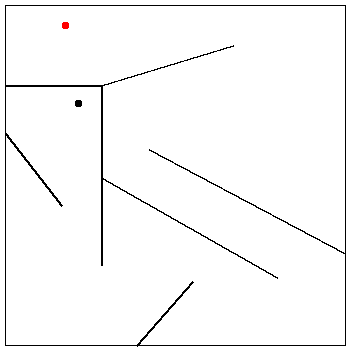

[0.6497474683058602, 0.45944084089786497, 0.6497474683058598, 0.563603896932104, 0.7970562748477094, 1.919041757463903, 1.0, 0.0, 0.0, 0.0]
Step 267:


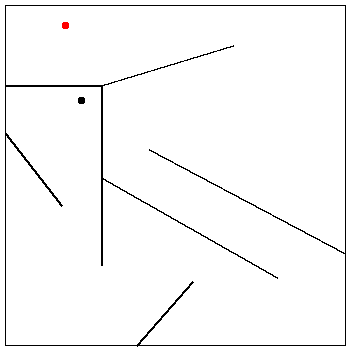

[0.5497474683058602, 0.38873016277921035, 0.5497474683058602, 0.49289321881344916, 0.6970562748477097, 2.0190417574639032, 1.0, 0.0, 0.0, 0.0]
Step 268:


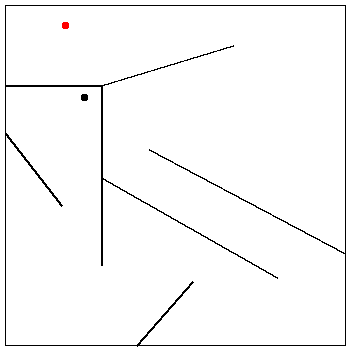

[0.44974746830586054, 0.31801948466055574, 0.4497474683058602, 0.42218254069479433, 0.5970562748477094, 2.1190417574639033, 1.0, 0.0, 0.0, 0.0]
Step 269:


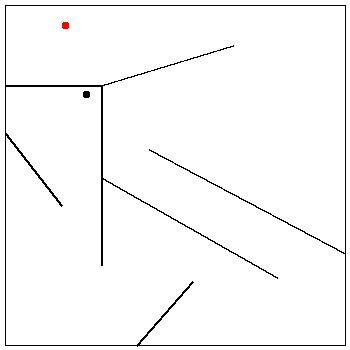

[0.3497474683058606, 0.24730880654190113, 0.3497474683058606, 0.3514718625761395, 0.49705627484770915, 2.219041757463903, 1.0, 0.0, 0.0, 0.0]
Step 270:


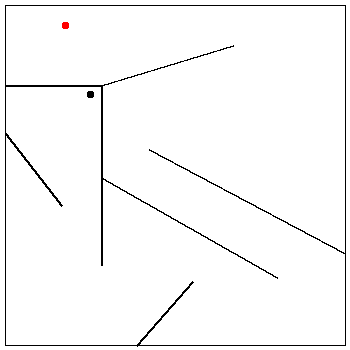

[0.24730880654190113, 0.3497474683058606, 0.2514718625761394, 0.3556349186103998, 6.252691193458099, 2.1485281374238605, 1.0, 0.0, 0.0, 0.0]
Step 271:


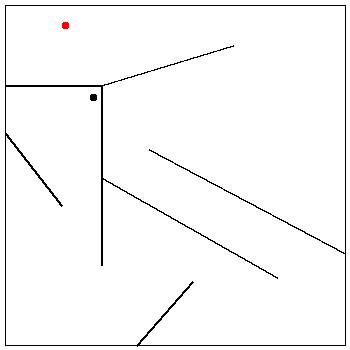

[0.2556349186103997, 0.1807611844574848, 0.2556349186103994, 6.181980515339444, 2.3110912703473896, 0.4497474683058604, 0.0, 0.0, 0.0, 1.0]
Step 272:


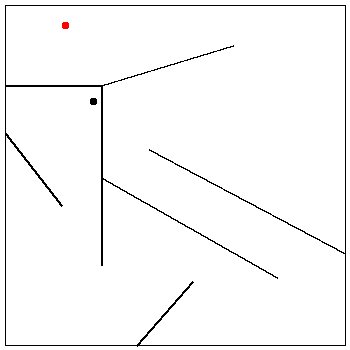

[0.1807611844574848, 0.2556349186103997, 6.081980515339444, 2.2492194269935664, 2.219238815542515, 0.41801948466055583, 0.0, 0.0, 0.0, 1.0]
Step 273:


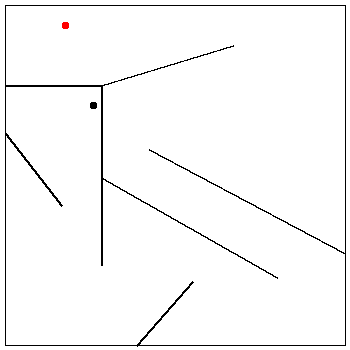

[0.1807611844574848, 0.2556349186103997, 5.981980515339444, 2.187347583639744, 2.219238815542515, 0.5180194846605559, 0.0, 0.0, 0.0, 1.0]
Step 274:


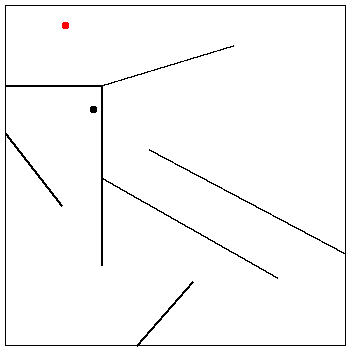

[0.1807611844574848, 0.2556349186103997, 5.881980515339444, 2.1254757402859203, 2.219238815542515, 0.618019484660556, 0.0, 0.0, 0.0, 1.0]
Step 275:


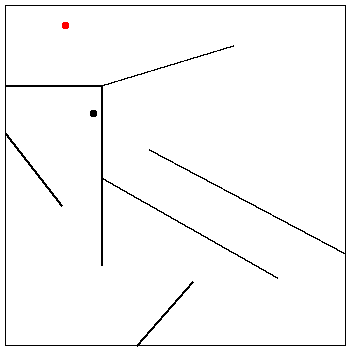

[0.1807611844574848, 0.2556349186103994, 5.781980515339444, 2.0636038969320976, 2.219238815542515, 0.7180194846605561, 0.0, 0.0, 0.0, 1.0]
Step 276:


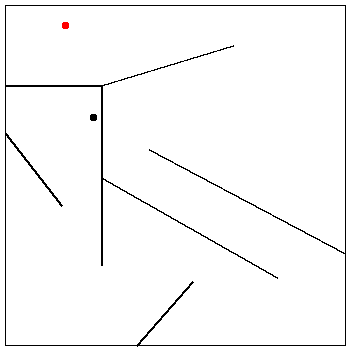

[0.1807611844574848, 0.2556349186103997, 5.681980515339443, 2.001732053578275, 2.219238815542515, 0.8180194846605562, 0.0, 0.0, 0.0, 1.0]
Step 277:


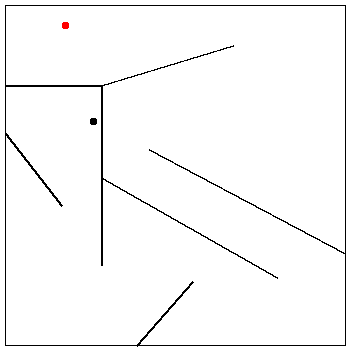

[0.1807611844574848, 0.2556349186103997, 5.581980515339444, 1.9398602102244515, 2.219238815542515, 0.9180194846605563, 0.0, 0.0, 0.0, 1.0]
Step 278:


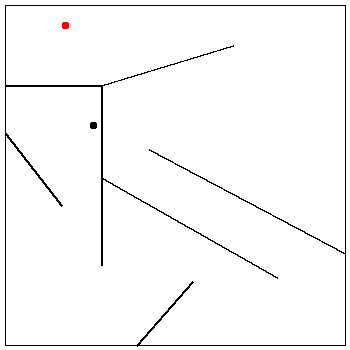

[0.1807611844574848, 0.2556349186103997, 5.481980515339444, 1.8779883668706285, 2.219238815542515, 1.0180194846605564, 0.0, 0.0, 0.0, 1.0]
Step 279:


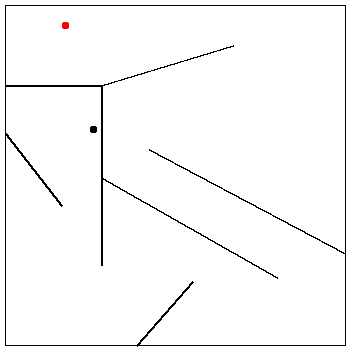

[0.1807611844574848, 0.2556349186103997, 5.3819805153394435, 1.816116523516806, 2.219238815542515, 1.1180194846605565, 0.0, 0.0, 0.0, 1.0]
Step 280:


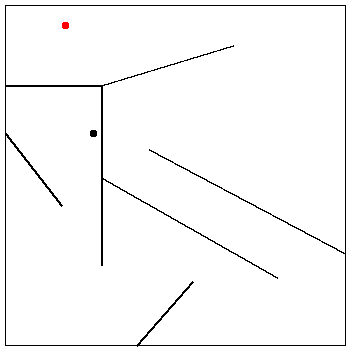

[0.1807611844574848, 0.2556349186103997, 5.281980515339443, 1.7542446801629827, 2.205223660806527, 1.2180194846605565, 0.0, 0.0, 0.0, 1.0]
Step 281:


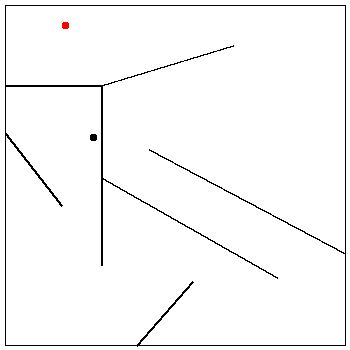

[0.1807611844574848, 0.2556349186103994, 5.181980515339443, 1.6923728368091597, 2.1274458830287486, 1.3180194846605566, 0.0, 0.0, 0.0, 1.0]
Step 282:


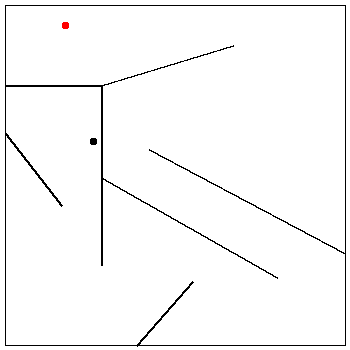

[0.1807611844574848, 0.2556349186103997, 5.081980515339444, 1.6305009934553365, 2.049668105250971, 1.4180194846605567, 0.0, 0.0, 0.0, 1.0]
Step 283:


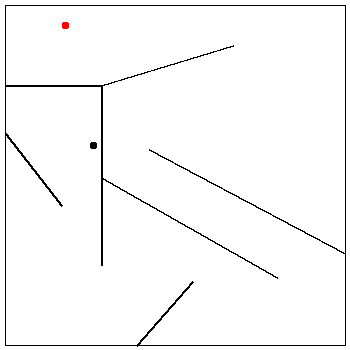

[0.1807611844574848, 0.2556349186103997, 4.981980515339443, 1.5686291501015137, 1.9718903274731931, 1.5180194846605568, 0.0, 0.0, 0.0, 1.0]
Step 284:


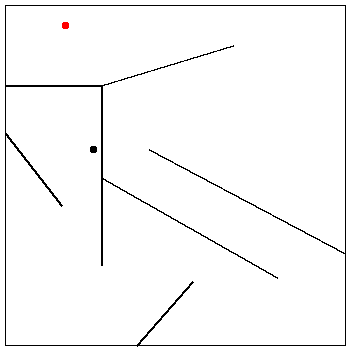

[0.1807611844574848, 0.2556349186103997, 4.881980515339443, 1.506757306747691, 1.8941125496954152, 1.618019484660557, 0.0, 0.0, 0.0, 1.0]
Step 285:


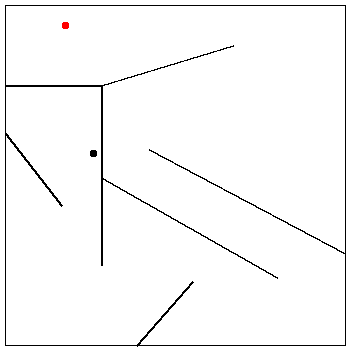

[0.1807611844574848, 0.2556349186103997, 4.781980515339443, 1.4448854633938677, 1.8163347719176375, 1.718019484660557, 0.0, 0.0, 0.0, 1.0]
Step 286:


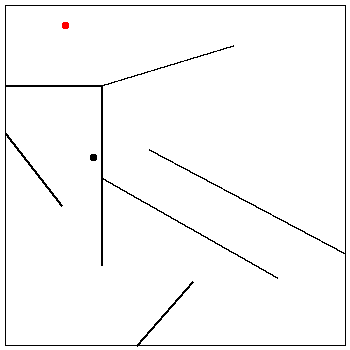

[0.1807611844574848, 0.2556349186103997, 4.681980515339443, 1.383013620040045, 1.7385569941398595, 1.818019484660557, 0.0, 0.0, 0.0, 1.0]
Step 287:


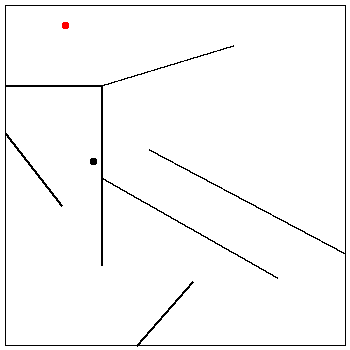

[0.1807611844574848, 0.2556349186103994, 4.581980515339443, 1.3211417766862221, 1.6607792163620818, 1.9180194846605572, 0.0, 0.0, 0.0, 1.0]
Step 288:


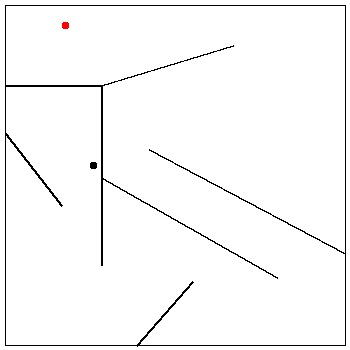

[0.1807611844574848, 0.25563491861040005, 4.481980515339443, 1.2592699333323993, 1.5830014385843043, 2.018019484660557, 0.0, 0.0, 0.0, 1.0]
Step 289:


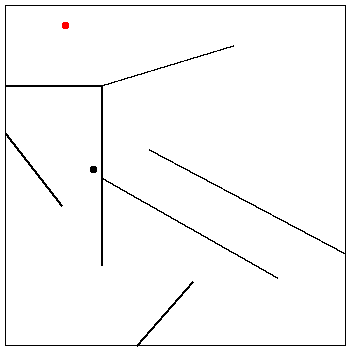

[0.1807611844574848, 0.2556349186103994, 4.3819805153394435, 1.1973980899785768, 1.5052236608065268, 2.1180194846605565, 0.0, 0.0, 0.0, 1.0]
Step 290:


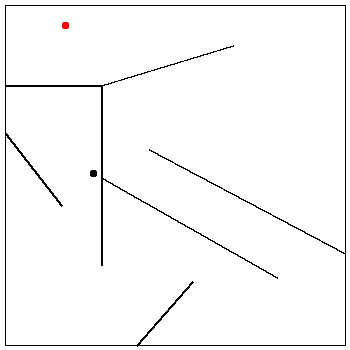

[0.1807611844574848, 0.25563491861040005, 4.281980515339444, 3.138477631085028, 1.4274458830287493, 2.218019484660556, 0.0, 0.0, 0.0, 1.0]
Step 291:


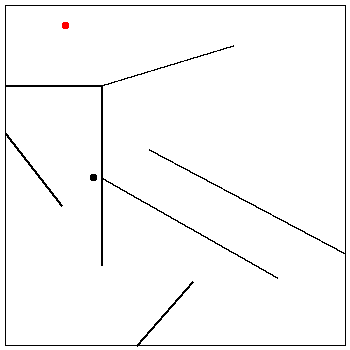

[0.1807611844574848, 0.25563491861040005, 4.181980515339444, 3.138477631085029, 1.3496681052509718, 2.3180194846605557, 0.0, 0.0, 0.0, 1.0]
Step 292:


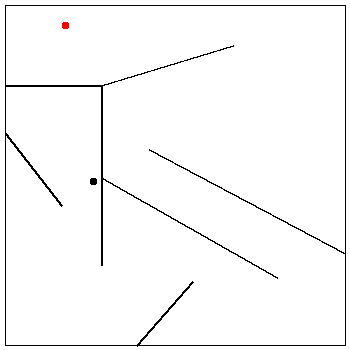

[0.1807611844574848, 0.2556349186103994, 4.081980515339445, 3.138477631085028, 1.2718903274731943, 2.4180194846605554, 0.0, 0.0, 0.0, 1.0]
Step 293:


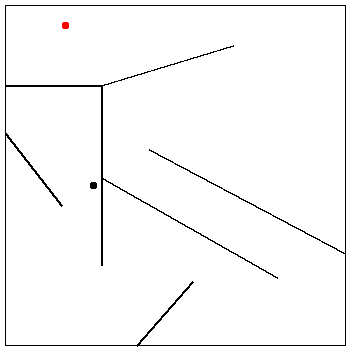

[0.1807611844574848, 0.25563491861040005, 3.981980515339445, 3.138477631085029, 1.1941125496954168, 2.518019484660555, 0.0, 0.0, 0.0, 1.0]
Step 294:


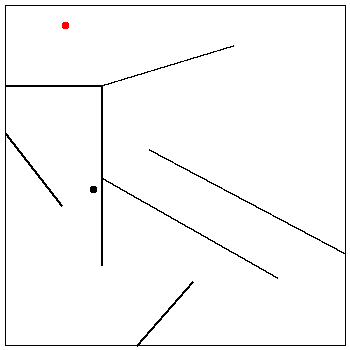

[0.1807611844574848, 0.25563491861040005, 3.8819805153394453, 3.138477631085028, 1.1163347719176393, 2.6180194846605547, 0.0, 0.0, 0.0, 1.0]
Step 295:


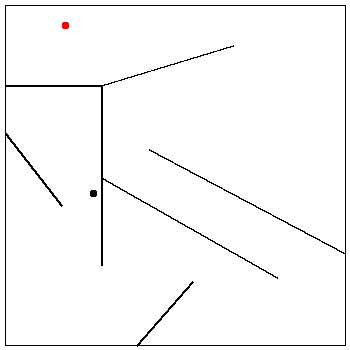

[0.1807611844574848, 0.25563491861040005, 3.7819805153394457, 3.138477631085029, 1.0385569941398618, 2.7180194846605543, 0.0, 0.0, 0.0, 1.0]
Step 296:


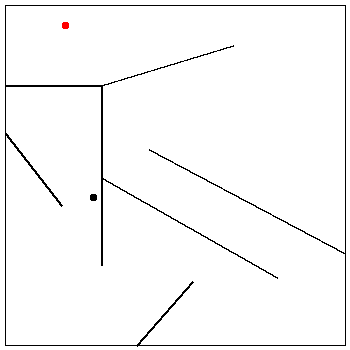

[0.1807611844574848, 0.25563491861040005, 3.681980515339446, 3.138477631085028, 0.9607792163620843, 2.818019484660554, 0.0, 0.0, 0.0, 1.0]
Step 297:


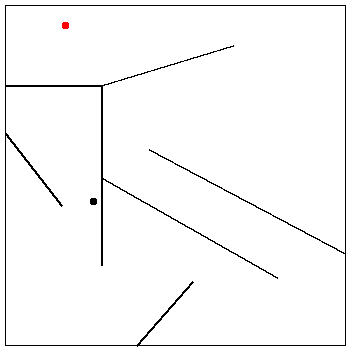

[0.1807611844574848, 0.25563491861040005, 3.5819805153394464, 3.138477631085029, 0.8830014385843068, 2.9180194846605536, 0.0, 0.0, 0.0, 1.0]
Step 298:


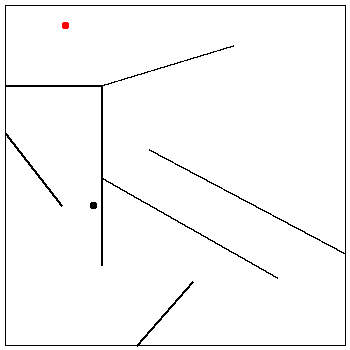

[0.1807611844574848, 0.25563491861040005, 3.4819805153394467, 3.138477631085028, 2.219238815542515, 3.0180194846605533, 0.0, 0.0, 0.0, 1.0]
Step 299:


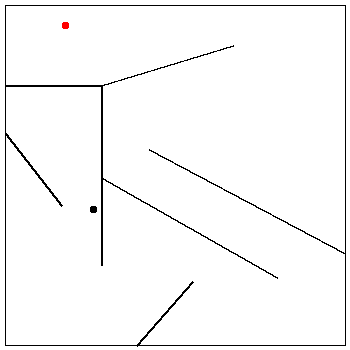

[0.1807611844574848, 0.2556349186103994, 3.381980515339447, 3.138477631085029, 2.219238815542515, 3.118019484660553, 0.0, 0.0, 0.0, 1.0]
Step 300:


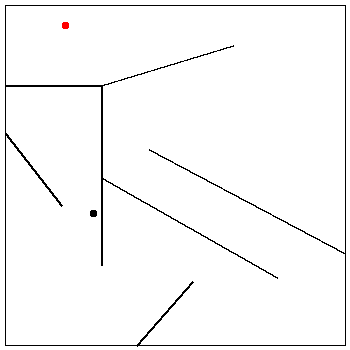

[0.1807611844574848, 0.25563491861040005, 3.2819805153394475, 3.138477631085028, 2.219238815542515, 3.2180194846605525, 0.0, 0.0, 0.0, 1.0]
Step 301:


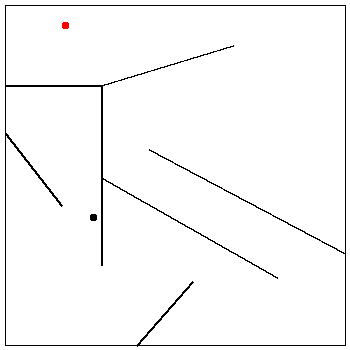

[0.1807611844574848, 0.2556349186103994, 3.181980515339448, 3.138477631085029, 2.219238815542515, 3.318019484660552, 0.0, 0.0, 0.0, 1.0]
Step 302:


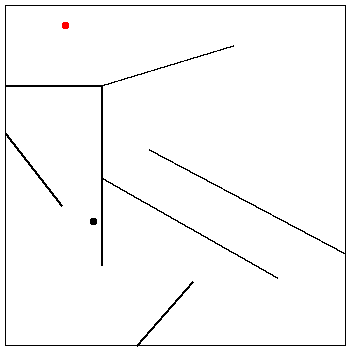

[0.1807611844574848, 0.2556349186103994, 3.081980515339448, 3.138477631085028, 2.219238815542515, 3.418019484660552, 0.0, 0.0, 0.0, 1.0]
Step 303:


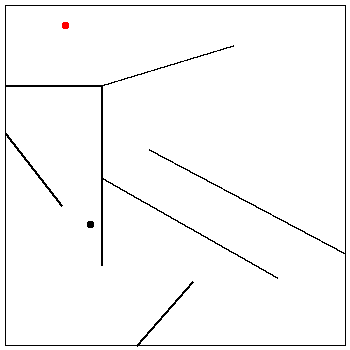

[0.3556349186103998, 3.0112698372207936, 3.0384776310850286, 2.1485281374238605, 2.3445130110310513, 0.3556349186103998, 0.0, 0.0, 1.0, 0.0]
Step 304:


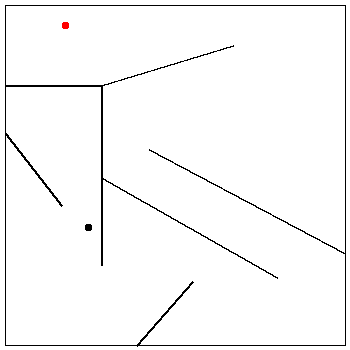

[0.4556349186103997, 2.940559159102139, 2.938477631085029, 2.077817459305206, 1.544513011031054, 0.4556349186103997, 0.0, 0.0, 1.0, 0.0]
Step 305:


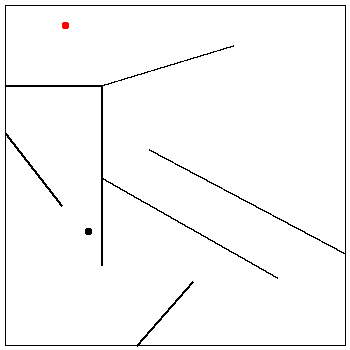

[0.322182540694794, 0.45563491861039895, 2.8405591591021393, 2.9384776310850294, 2.077817459305206, 3.6594408408978607, 0.0, 0.0, 0.0, 1.0]
Step 306:


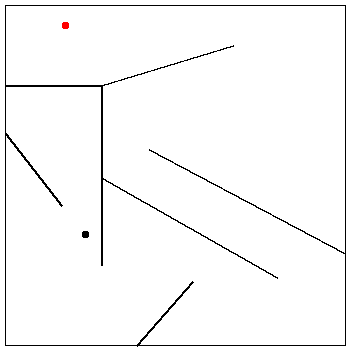

[0.5556349186103988, 2.7698484809834847, 2.8384776310850297, 2.0071067811865513, 2.8384776310850284, 0.5556349186103994, 0.0, 0.0, 1.0, 0.0]
Step 307:


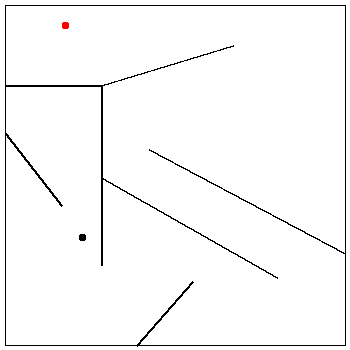

[0.6556349186103994, 2.69913780286483, 2.7384776310850287, 1.9363961030678964, 2.7384776310850283, 0.6556349186103994, 0.0, 0.0, 1.0, 0.0]
Step 308:


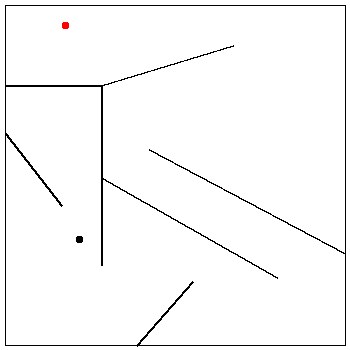

[0.7556349186103993, 2.6284271247461755, 2.638477631085029, 1.8656854249492416, 2.6384776310850278, 0.7556349186103993, 0.0, 0.0, 1.0, 0.0]
Step 309:


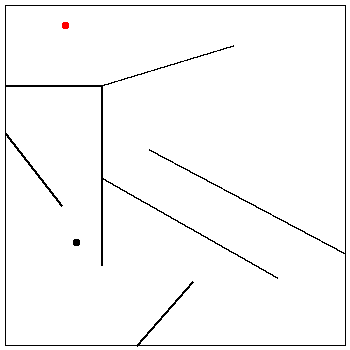

[2.823167867376467, 2.557716446627521, 2.538477631085029, 1.7949747468305868, 2.5384776310850277, 0.8556349186104, 0.0, 0.0, 1.0, 0.0]
Step 310:


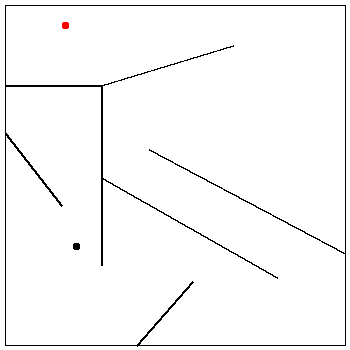

[0.6050252531694131, 2.7571712344657233, 2.457716446627521, 2.5384776310850286, 1.7949747468305868, 4.042283553372479, 0.0, 0.0, 0.0, 1.0]
Step 311:


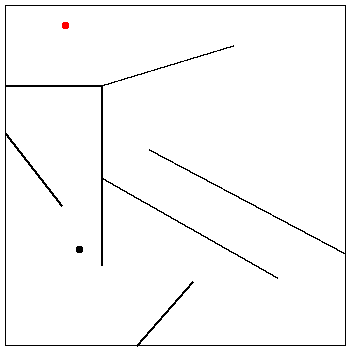

[0.7556349186103993, 0.5343145750507583, 2.657171234465723, 2.3870057685088666, 2.638477631085029, 2.6384776310850278, 0.0, 0.0, 0.0, 1.0]
Step 312:


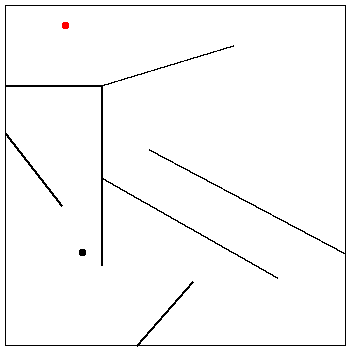

[0.6556349186103994, 0.46360389693210347, 2.5571712344657227, 2.316295090390212, 2.7384776310850287, 2.7384776310850283, 0.0, 0.0, 0.0, 1.0]
Step 313:


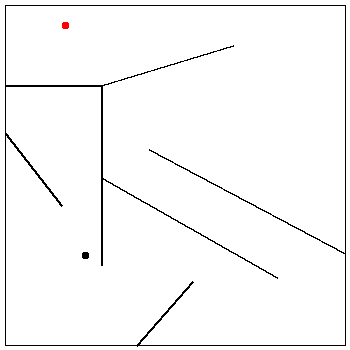

[0.5556349186103994, 0.39289321881344863, 2.4571712344657226, 2.2455844122715574, 2.838477631085029, 2.8384776310850284, 0.0, 0.0, 0.0, 1.0]
Step 314:


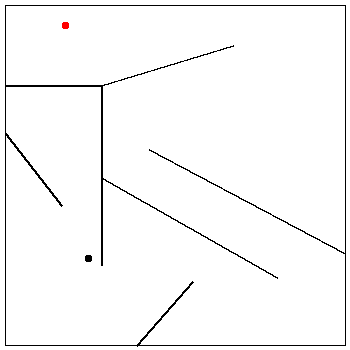

[0.4556349186103997, 0.322182540694794, 2.357171234465723, 2.1748737341529027, 2.938477631085029, 2.938477631085028, 0.0, 0.0, 0.0, 1.0]
Step 315:


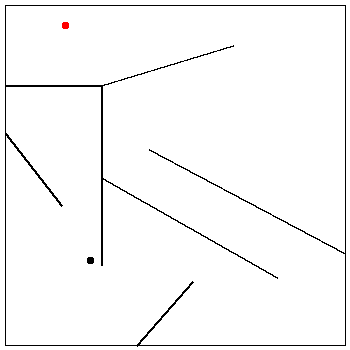

[0.3556349186103992, 0.2514718625761394, 2.2571712344657233, 2.104163056034248, 2.9757359312880522, 3.038477631085028, 0.0, 0.0, 0.0, 1.0]
Step 316:


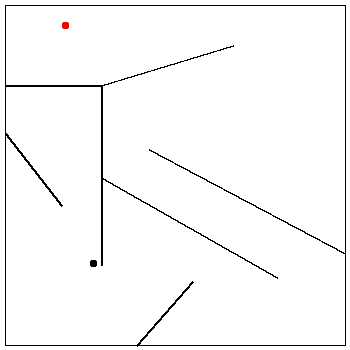

[0.25563491861040005, 0.1807611844574848, 2.1571712344657232, 2.0334523779155935, 2.8757359312880526, 3.1384776310850278, 0.0, 0.0, 0.0, 1.0]
Step 317:


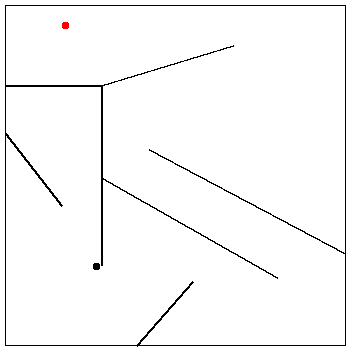

[0.1556349186104002, 4.047625114696218, 2.0571712344657236, 1.962741699796939, 2.775735931288053, 3.2384776310850274, 0.0, 0.0, 0.0, 1.0]
Step 318:


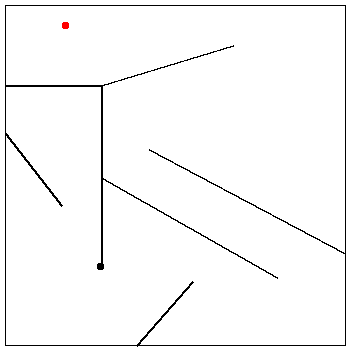

[4.537258300203061, 2.022748179843491, 3.947625114696218, 1.9817465111391581, 1.962741699796939, 2.38994949366117, 1.0, 0.0, 0.0, 0.0]
Step 319:


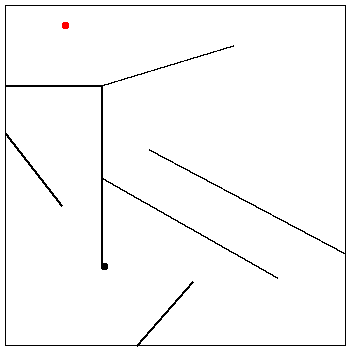

[2.186150633350124, 1.9715085580183789, 3.8476251146962177, 1.9063217878125935, 1.962741699796939, 2.48994949366117, 1.0, 0.0, 0.0, 0.0]
Step 320:


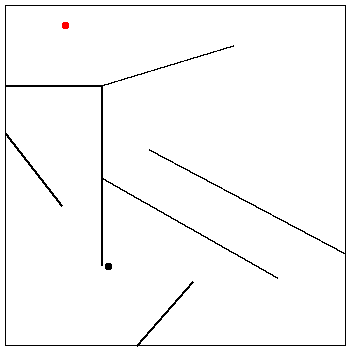

[2.1293324515319414, 1.9202689361932668, 3.7476251146962176, 1.830897064486028, 1.962741699796939, 2.58994949366117, 1.0, 0.0, 0.0, 0.0]
Step 321:


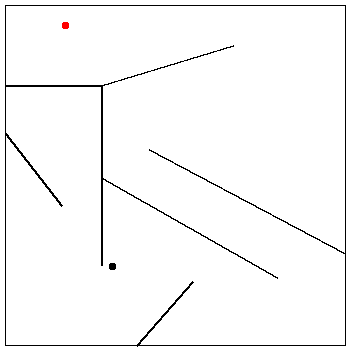

[2.0725142697137597, 1.8690293143681551, 3.6476251146962175, 1.7554723411594628, 1.962741699796939, 2.68994949366117, 1.0, 0.0, 0.0, 0.0]
Step 322:


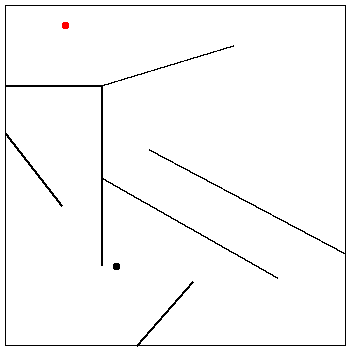

[2.015696087895578, 1.8177896925430423, 3.5476251146962174, 1.680047617832898, 1.962741699796939, 2.78994949366117, 1.0, 0.0, 0.0, 0.0]
Step 323:


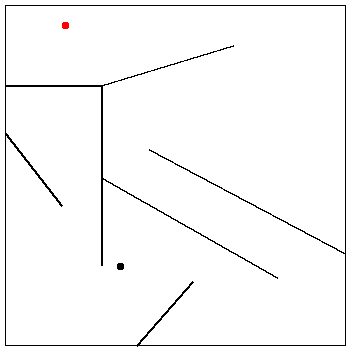

[1.9588779060773964, 1.7665500707179302, 3.4476251146962174, 1.6046228945063326, 1.962741699796939, 2.8899494936611703, 1.0, 0.0, 0.0, 0.0]
Step 324:


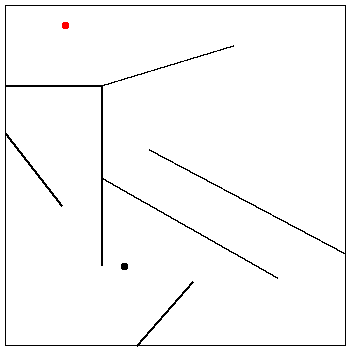

[1.9020597242592148, 1.7153104488928177, 3.3476251146962173, 1.529198171179768, 1.962741699796939, 2.9899494936611704, 1.0, 0.0, 0.0, 0.0]
Step 325:


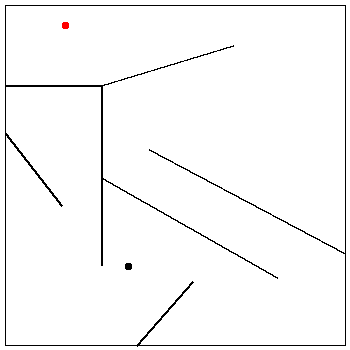

[1.8452415424410322, 1.6640708270677063, 3.247625114696217, 1.4537734478532027, 1.962741699796939, 3.0899494936611704, 1.0, 0.0, 0.0, 0.0]
Step 326:


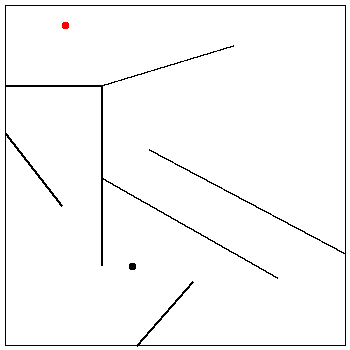

[1.7884233606228506, 1.6128312052425942, 3.147625114696217, 1.3783487245266375, 1.962741699796939, 3.1899494936611705, 1.0, 0.0, 0.0, 0.0]
Step 327:


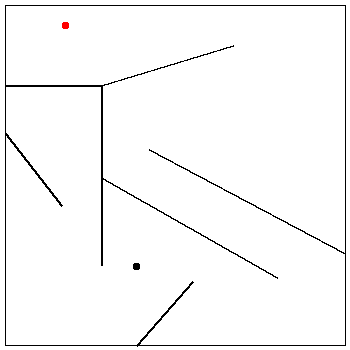

[1.731605178804669, 1.5615915834174816, 3.047625114696217, 1.302924001200073, 1.962741699796939, 3.2899494936611706, 1.0, 0.0, 0.0, 0.0]
Step 328:


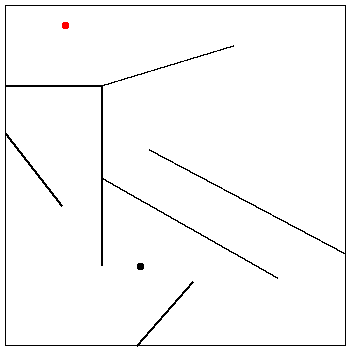

[1.6747869969864873, 1.5103519615923695, 2.947625114696217, 1.227499277873507, 1.8599422784698865, 3.3899494936611707, 1.0, 0.0, 0.0, 0.0]
Step 329:


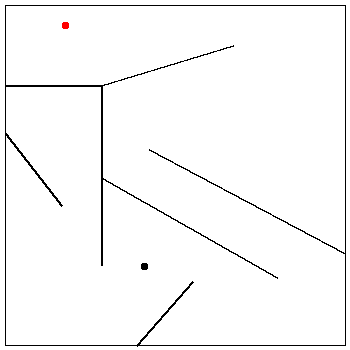

[1.6179688151683047, 1.4591123397672574, 2.847625114696217, 1.1520745545469417, 1.7456565641841726, 3.489949493661171, 1.0, 0.0, 0.0, 0.0]
Step 330:


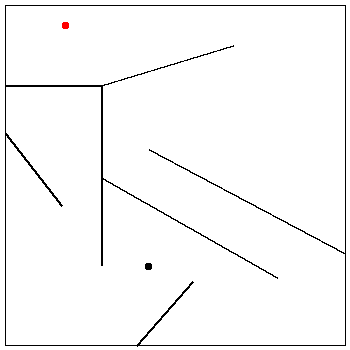

[1.561150633350123, 1.4078727179421446, 2.7476251146962167, 1.0766498312203772, 1.631370849898457, 3.589949493661171, 1.0, 0.0, 0.0, 0.0]
Step 331:


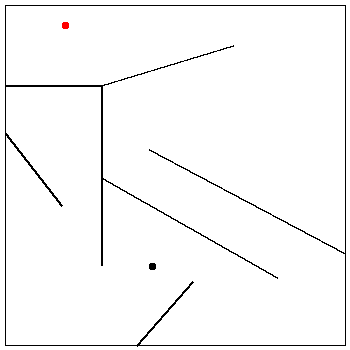

[1.5043324515319414, 1.3566330961170332, 2.6476251146962166, 1.001225107893812, 1.517085135612743, 3.689949493661171, 1.0, 0.0, 0.0, 0.0]
Step 332:


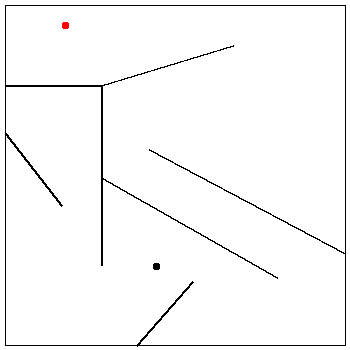

[1.4475142697137597, 1.3053934742919207, 2.5476251146962166, 0.9258003845672473, 1.4027994213270292, 3.789949493661171, 1.0, 0.0, 0.0, 0.0]
Step 333:


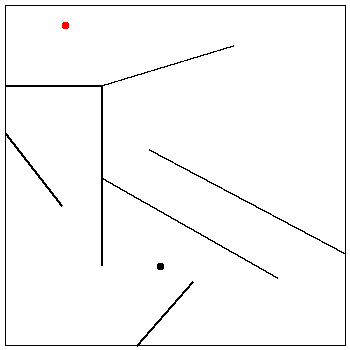

[1.390696087895578, 1.2541538524668085, 2.4476251146962165, 0.8503756612406821, 1.2885137070413144, 3.889949493661171, 1.0, 0.0, 0.0, 0.0]
Step 334:


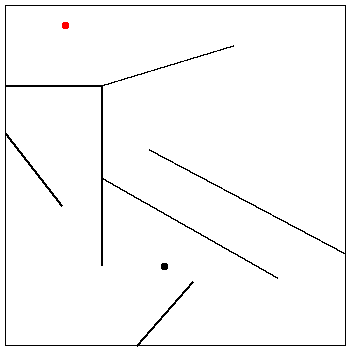

[1.3338779060773955, 1.2029142306416964, 2.3476251146962164, 0.7749509379141168, 1.1742279927556005, 3.9899494936611712, 1.0, 0.0, 0.0, 0.0]
Step 335:


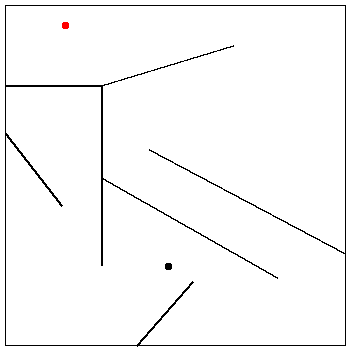

[1.2770597242592139, 1.1516746088165837, 2.2476251146962163, 0.6995262145875509, 1.0599422784698858, 4.089949493661171, 1.0, 0.0, 0.0, 0.0]
Step 336:


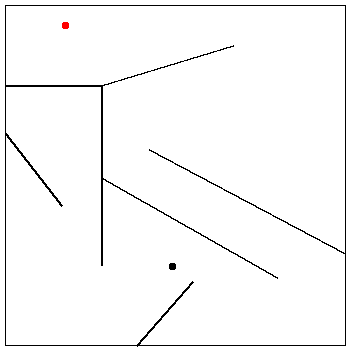

[1.2202415424410322, 1.100434986991472, 2.1476251146962166, 0.6241014912609867, 0.9456565641841719, 4.189949493661171, 1.0, 0.0, 0.0, 0.0]
Step 337:


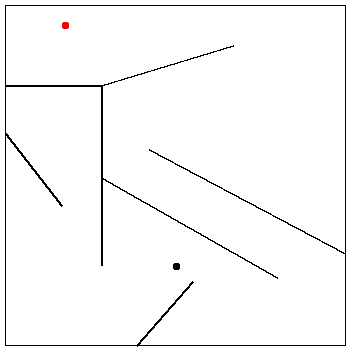

[1.1634233606228506, 1.0491953651663604, 2.047625114696217, 0.5486767679344223, 0.8313708498984589, 4.289949493661171, 1.0, 0.0, 0.0, 0.0]
Step 338:


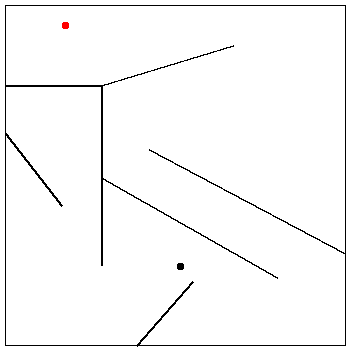

[1.106605178804669, 0.9979557433412486, 1.9476251146962174, 2.775735931288053, 0.7170851356127441, 4.38994949366117, 1.0, 0.0, 0.0, 0.0]
Step 339:


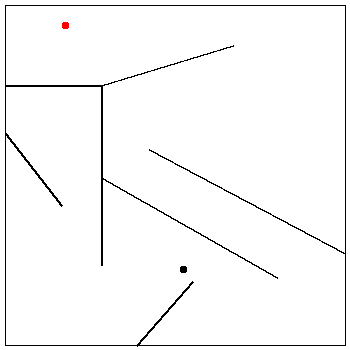

[1.0254919752253064, 2.001365230066395, 2.6757359312880533, 0.5655622539299134, 2.6757359312880533, 2.9142135623730994, 0.0, 0.0, 0.0, 1.0]
Step 340:


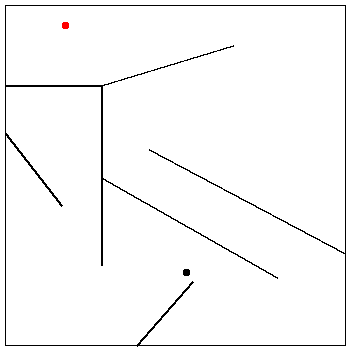

[1.0530282071093642, 2.055105345436573, 2.5757359312880532, 0.41403937224708187, 2.5757359312880532, 3.0142135623730995, 0.0, 0.0, 0.0, 1.0]
Step 341:


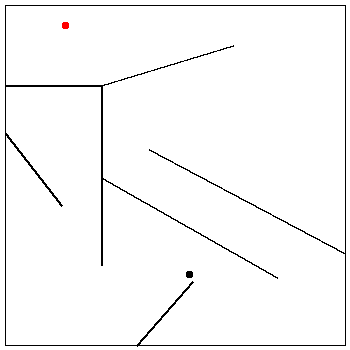

[1.0805644389934221, 2.1088454608067497, 2.4757359312880536, 0.2625164905642512, 2.4757359312880536, 3.1142135623730987, 0.0, 0.0, 0.0, 1.0]
Step 342:


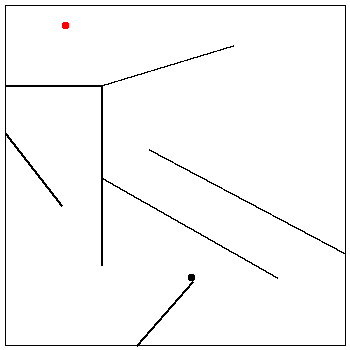

[1.1081006708774799, 3.8272077938642113, 2.375735931288054, 0.11099360888141963, 2.375735931288054, 3.214213562373099, 0.0, 0.0, 0.0, 1.0]
Step 343:


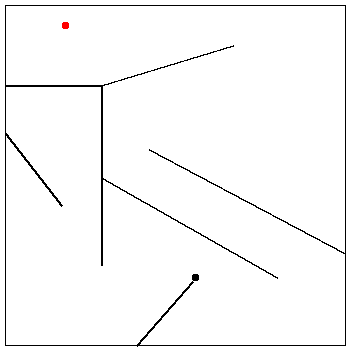

[1.1719236228277996, 1.0568610490523682, 3.7272077938642116, 2.375735931288054, 1.6798989873223205, 4.772792206135788, 1.0, 0.0, 0.0, 0.0]
Step 344:


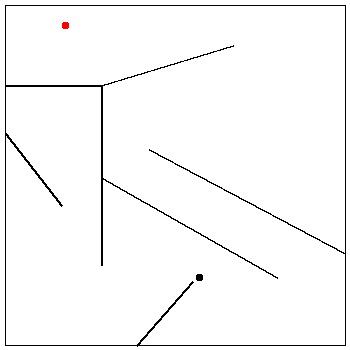

[1.115105441009618, 1.0056214272272563, 3.627207793864212, 2.375735931288054, 1.6798989873223205, 4.872792206135788, 1.0, 0.0, 0.0, 0.0]
Step 345:


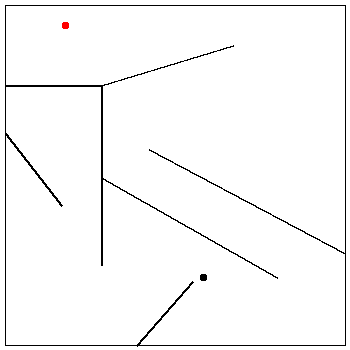

[1.0582872591914372, 0.954381805402144, 3.5272077938642123, 2.375735931288054, 1.6798989873223205, 4.972792206135788, 1.0, 0.0, 0.0, 0.0]
Step 346:


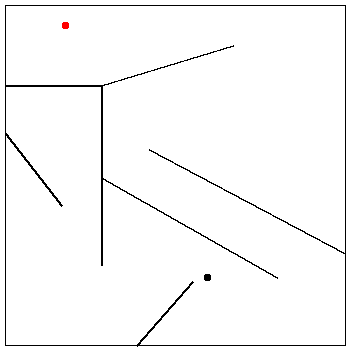

[1.0014690773732555, 0.9031421835770324, 3.4272077938642127, 2.375735931288054, 1.6798989873223205, 5.072792206135787, 1.0, 0.0, 0.0, 0.0]
Step 347:


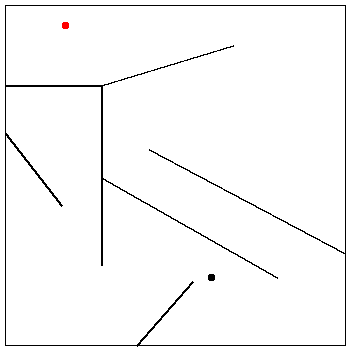

[0.9446508955550739, 0.8519025617519199, 3.327207793864213, 2.375735931288054, 1.6798989873223205, 5.172792206135787, 1.0, 0.0, 0.0, 0.0]
Step 348:


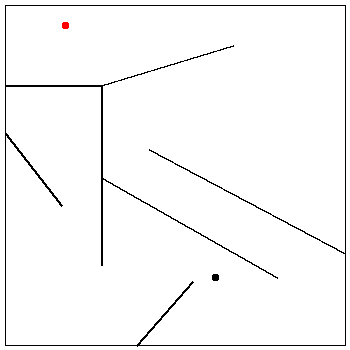

[0.8878327137368922, 0.8006629399268083, 3.2272077938642134, 2.375735931288054, 1.6798989873223205, 5.272792206135787, 1.0, 0.0, 0.0, 0.0]
Step 349:


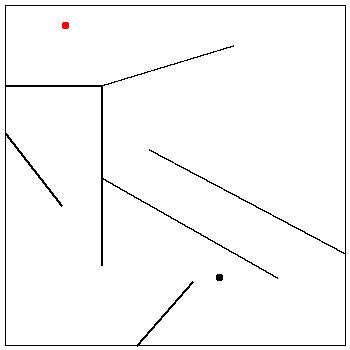

[0.8310145319187106, 0.7494233181016965, 3.1272077938642138, 2.375735931288054, 1.6798989873223205, 5.372792206135786, 1.0, 0.0, 0.0, 0.0]
Step 350:


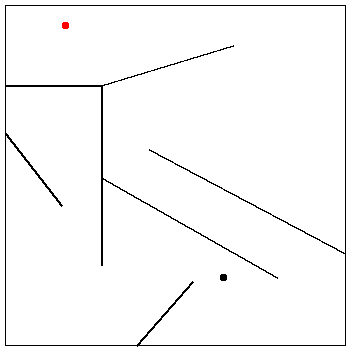

[0.7741963501005289, 0.6981836962765847, 3.027207793864214, 2.375735931288054, 1.6798989873223205, 5.472792206135786, 1.0, 0.0, 0.0, 0.0]
Step 351:


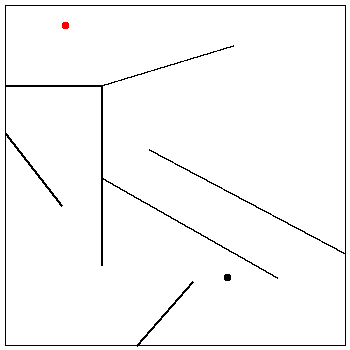

[0.7173781682823472, 0.646944074451473, 2.9272077938642145, 2.375735931288054, 1.6798989873223205, 5.5727922061357855, 1.0, 0.0, 0.0, 0.0]
Step 352:


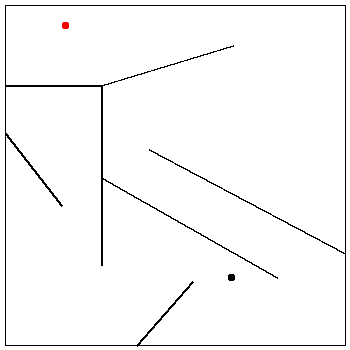

[0.6605599864641656, 0.5957044526263601, 2.827207793864215, 2.375735931288054, 1.6798989873223205, 5.672792206135785, 1.0, 0.0, 0.0, 0.0]
Step 353:


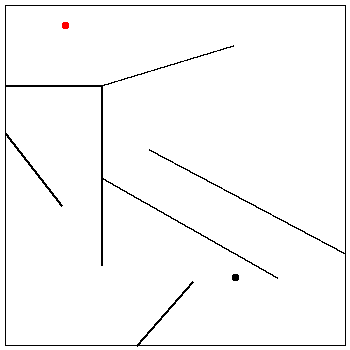

[0.6037418046459839, 0.5444648308012483, 2.727207793864215, 2.375735931288054, 1.6798989873223205, 5.772792206135785, 1.0, 0.0, 0.0, 0.0]
Step 354:


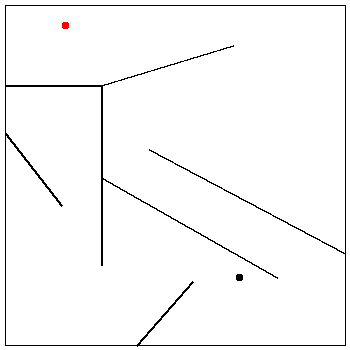

[0.5469236228278023, 0.49322520897613653, 2.6272077938642155, 2.375735931288054, 1.6798989873223205, 5.8727922061357845, 1.0, 0.0, 0.0, 0.0]
Step 355:


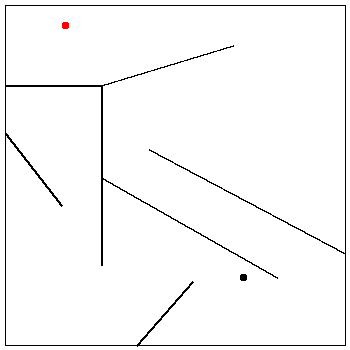

[0.4901054410096206, 0.4419855871510248, 2.527207793864216, 2.375735931288054, 1.6798989873223205, 5.972792206135784, 1.0, 0.0, 0.0, 0.0]
Step 356:


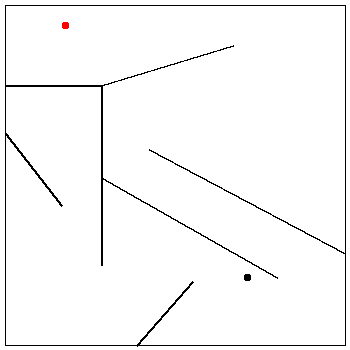

[0.43328725919143896, 0.39074596532591305, 2.4272077938642163, 2.375735931288054, 1.6798989873223205, 6.072792206135784, 1.0, 0.0, 0.0, 0.0]
Step 357:


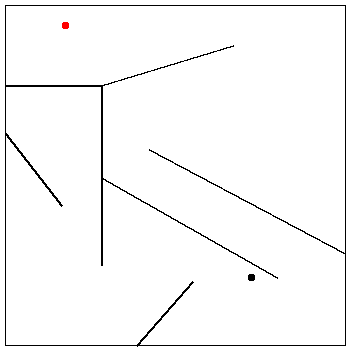

[0.3764690773732573, 0.33950634350080067, 2.3272077938642166, 2.375735931288054, 1.6798989873223205, 6.172792206135783, 1.0, 0.0, 0.0, 0.0]
Step 358:


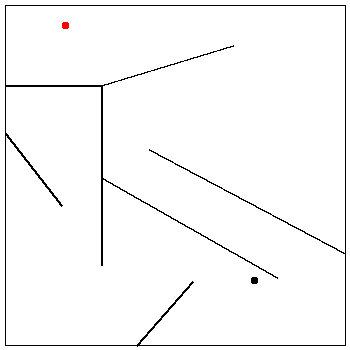

[0.3670425753848591, 2.256497115745562, 2.275735931288054, 1.6091883092036658, 2.275735931288054, 1.332944089555541, 0.0, 0.0, 0.0, 1.0]
Step 359:


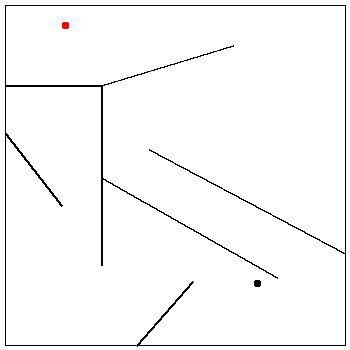

[0.394578807268917, 2.1857864376269074, 2.175735931288054, 1.5384776310850112, 2.175735931288054, 1.4329440895555399, 0.0, 0.0, 0.0, 1.0]
Step 360:


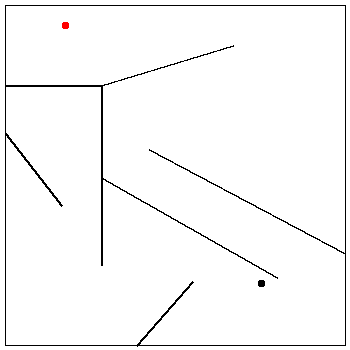

[0.3807192084757318, 0.3433391854438046, 2.0857864376269077, 2.175735931288054, 1.5384776310850112, 1.7680456351737073, 1.0, 0.0, 0.0, 0.0]
Step 361:


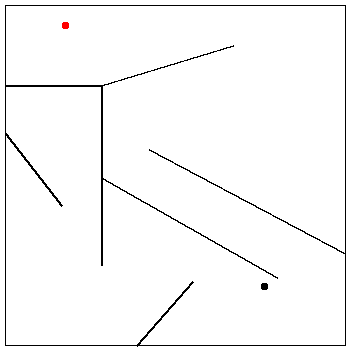

[0.37087541732786244, 2.015075759508253, 2.075735931288054, 1.4677669529663566, 2.075735931288054, 1.3468633576643447, 0.0, 0.0, 0.0, 1.0]
Step 362:


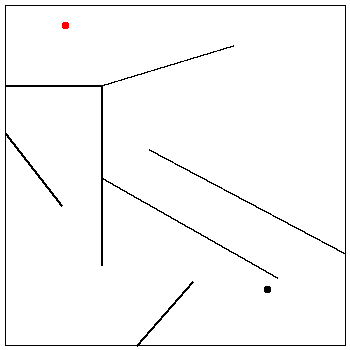

[1.7875232269637986, 1.9443650813895985, 1.9757359312880545, 1.397056274847702, 1.9757359312880545, 1.4468633576643437, 0.0, 0.0, 0.0, 1.0]
Step 363:


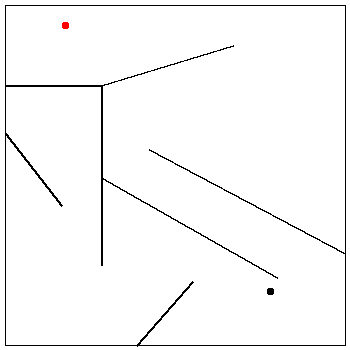

[1.8181898936304655, 1.873654403270944, 1.8757359312880546, 1.3263455967290474, 1.8757359312880546, 1.5468633576643442, 0.0, 0.0, 0.0, 1.0]
Step 364:


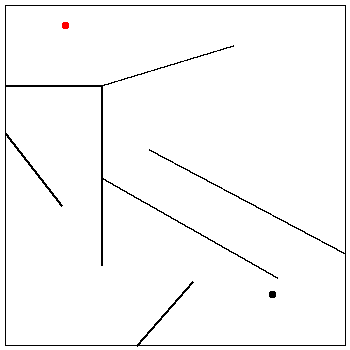

[1.8488565602971316, 1.8029437251522893, 1.7757359312880547, 1.2556349186103928, 1.7757359312880547, 1.6468633576643439, 0.0, 0.0, 0.0, 1.0]
Step 365:


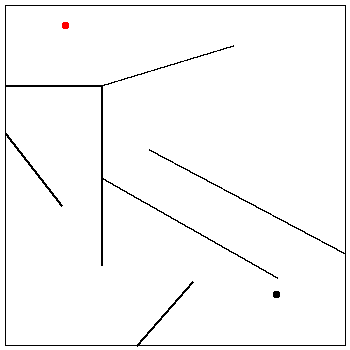

[0.4460376524988625, 1.7998304901348645, 1.7029437251522896, 1.7757359312880554, 1.2556349186103928, 2.3983757210636165, 1.0, 0.0, 0.0, 0.0]
Step 366:


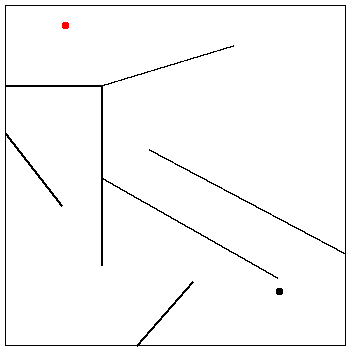

[1.0976247310363059, 1.8397372445541063, 1.6998304901348646, 1.632233047033635, 1.875735931288054, 1.8757359312880528, 1.0, 0.0, 0.0, 0.0]
Step 367:


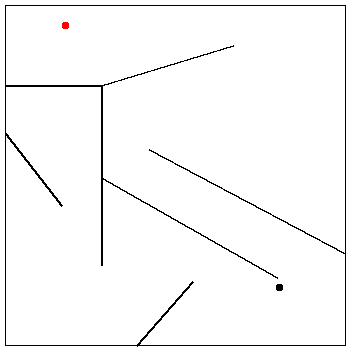

[2.3197145558284484, 0.7701226429078006, 1.7397372445541066, 1.6074352040598225, 1.632233047033635, 1.426345596729047, 0.0, 1.0, 0.0, 0.0]
Step 368:


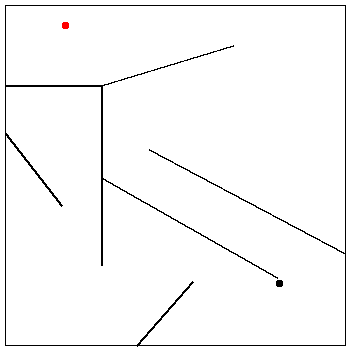

[2.232214555828449, 0.4426205547792959, 1.639737244554107, 1.515039917984781, 1.632233047033635, 1.5263455967290467, 0.0, 1.0, 0.0, 0.0]
Step 369:


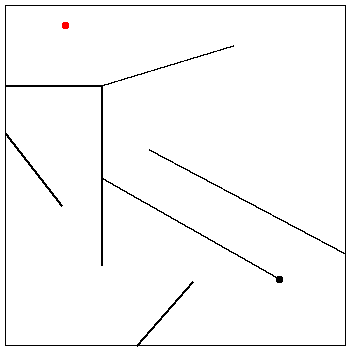

[6.867766952966365, 0.11511846665079181, 1.5397372445541073, 1.4226446319097392, 1.632233047033635, 1.6263455967290463, 0.0, 1.0, 0.0, 0.0]
Step 370:


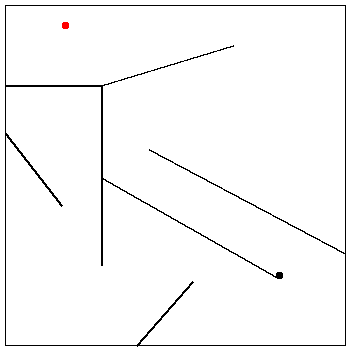

[0.11413520320948578, 4.337769605982712, 1.4397372445541077, 1.330249345834697, 1.632233047033635, 1.726345596729046, 0.0, 1.0, 0.0, 0.0]
Step 371:


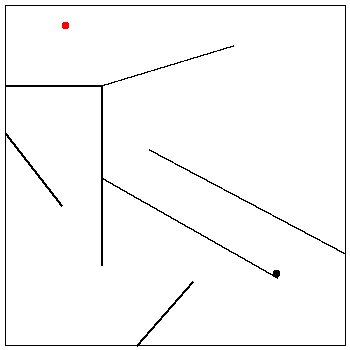

[0.0860186783779219, 0.16787531857966265, 4.237769605982712, 1.4065465180902486, 1.2995826791680303, 2.408326112068528, 0.0, 1.0, 0.0, 0.0]
Step 372:


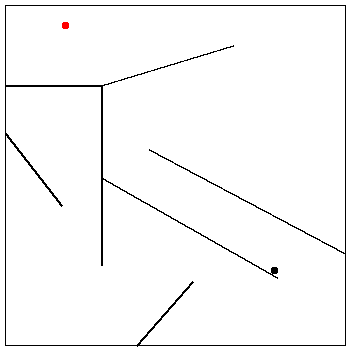

[0.11355491026197972, 0.2216154339498404, 4.1377696059827125, 1.3733557916263903, 1.2689160125013643, 2.508326112068529, 0.0, 1.0, 0.0, 0.0]
Step 373:


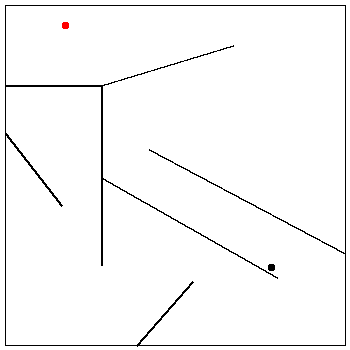

[0.14109114214603755, 0.27535554932001816, 4.037769605982712, 1.340165065162532, 1.2382493458346975, 2.6083261120685273, 0.0, 1.0, 0.0, 0.0]
Step 374:


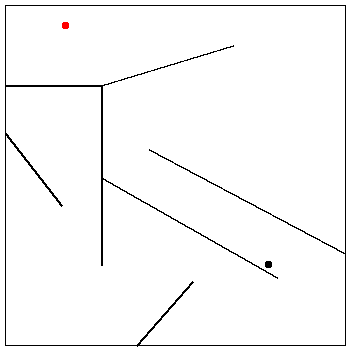

[0.16862737403009537, 0.3290956646901959, 3.9377696059827128, 1.3069743386986739, 1.2075826791680313, 2.7083261120685274, 0.0, 1.0, 0.0, 0.0]
Step 375:


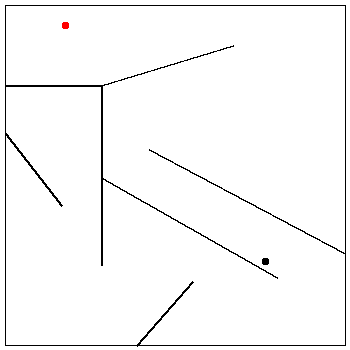

[0.19616360591415322, 0.3828357800603728, 3.8377696059827127, 1.2737836122348156, 1.176916012501364, 2.8083261120685283, 0.0, 1.0, 0.0, 0.0]
Step 376:


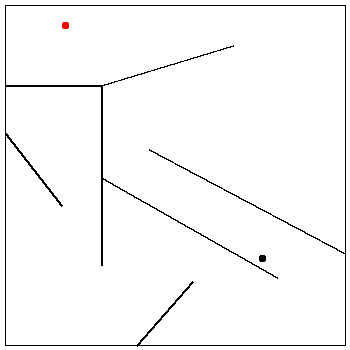

[0.22369983779821165, 0.43657589543055053, 3.737769605982713, 1.2405928857709574, 1.146249345834698, 2.9083261120685266, 0.0, 1.0, 0.0, 0.0]
Step 377:


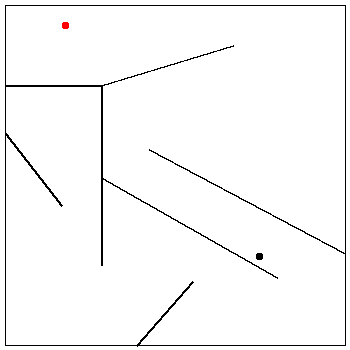

[0.25123606968226886, 0.4903160108007274, 3.637769605982713, 1.2074021593070992, 1.1155826791680312, 3.0083261120685267, 0.0, 1.0, 0.0, 0.0]
Step 378:


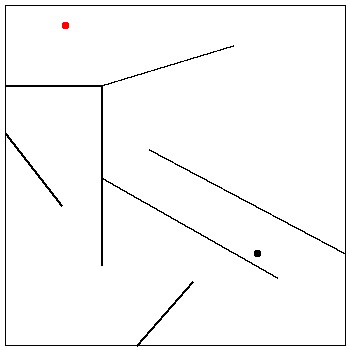

[0.2787723015663273, 0.544056126170906, 3.537769605982713, 1.174211432843241, 1.0849160125013646, 3.1083261120685264, 0.0, 1.0, 0.0, 0.0]
Step 379:


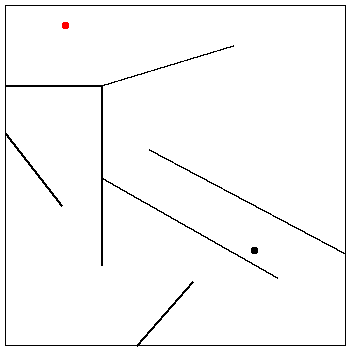

[0.30630853345038517, 0.5977962415410829, 3.4377696059827128, 1.1410207063793827, 1.0542493458346978, 3.208326112068526, 0.0, 1.0, 0.0, 0.0]
Step 380:


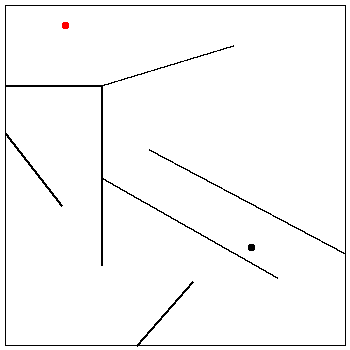

[0.33384476533444296, 0.6515363569112607, 3.337769605982713, 1.1078299799155245, 1.0235826791680311, 3.308326112068527, 0.0, 1.0, 0.0, 0.0]
Step 381:


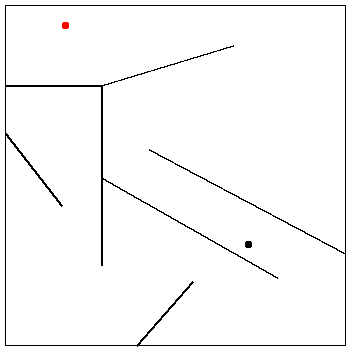

[0.3613809972185014, 0.7052764722814384, 3.237769605982714, 1.0746392534516662, 0.9929160125013651, 3.408326112068527, 0.0, 1.0, 0.0, 0.0]
Step 382:


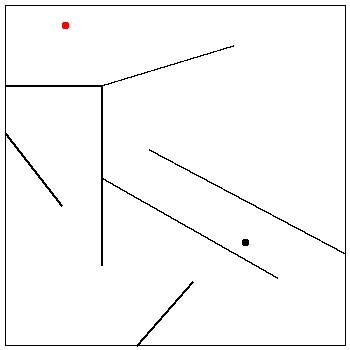

[0.3889172291025592, 0.7590165876516153, 3.137769605982713, 1.041448526987808, 0.9622493458346983, 3.5083261120685267, 0.0, 1.0, 0.0, 0.0]
Step 383:


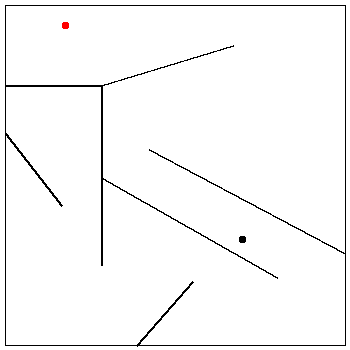

[0.41645346098661706, 0.812756703021793, 3.037769605982714, 1.0082578005239498, 0.9315826791680316, 3.6083261120685255, 0.0, 1.0, 0.0, 0.0]
Step 384:


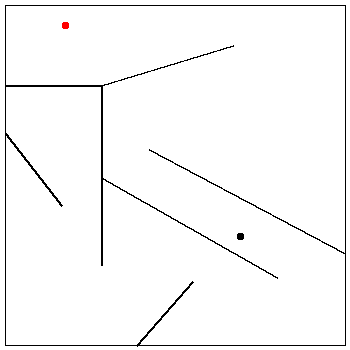

[0.44398969287067486, 0.8664968183919708, 2.937769605982714, 0.9750670740600915, 0.9009160125013649, 3.708326112068525, 0.0, 1.0, 0.0, 0.0]
Step 385:


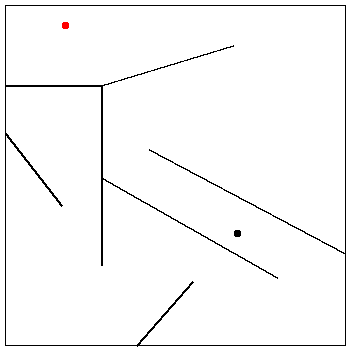

[0.4715259247547327, 0.9202369337621477, 2.8377696059827135, 0.9418763475962333, 0.8702493458346983, 3.808326112068525, 0.0, 1.0, 0.0, 0.0]
Step 386:


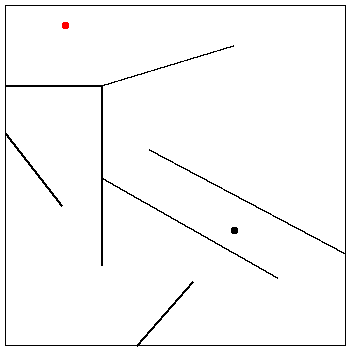

[0.49906215663879055, 0.9739770491323254, 2.737769605982714, 0.908685621132375, 0.8395826791680321, 3.908326112068525, 0.0, 1.0, 0.0, 0.0]
Step 387:


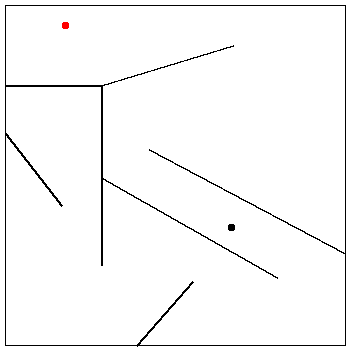

[0.5265983885228483, 1.0277171645025032, 2.6377696059827143, 0.8754948946685168, 0.8089160125013648, 4.008326112068525, 0.0, 1.0, 0.0, 0.0]
Step 388:


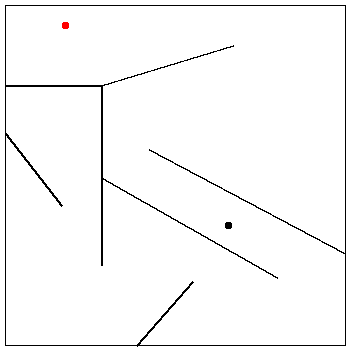

[0.5541346204069062, 1.08145727987268, 2.537769605982714, 0.8423041682046577, 0.7782493458346986, 4.108326112068524, 0.0, 1.0, 0.0, 0.0]
Step 389:


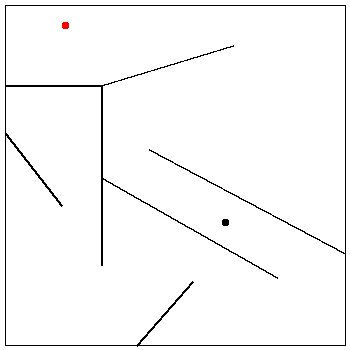

[0.5816708522909647, 1.1351973952428578, 2.4377696059827145, 0.8091134417407995, 0.7475826791680319, 4.208326112068525, 0.0, 1.0, 0.0, 0.0]
Step 390:


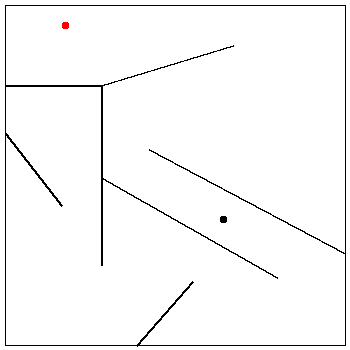

[0.6092070841750218, 1.1889375106130355, 2.3377696059827144, 0.7759227152769412, 0.7169160125013653, 4.308326112068524, 0.0, 1.0, 0.0, 0.0]
Step 391:


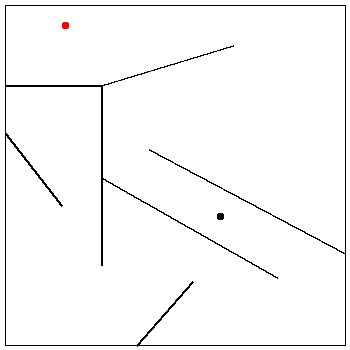

[0.6367433160590803, 1.2426776259832133, 2.237769605982715, 0.742731988813083, 0.6862493458346992, 4.408326112068524, 0.0, 1.0, 0.0, 0.0]
Step 392:


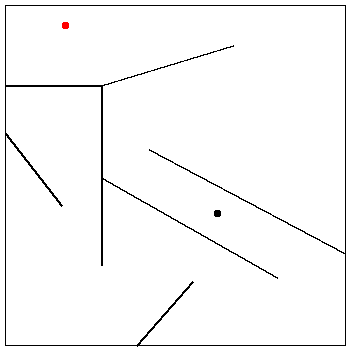

[0.6642795479431381, 1.2964177413533902, 2.1377696059827147, 0.7095412623492248, 0.6555826791680318, 4.508326112068524, 0.0, 1.0, 0.0, 0.0]
Step 393:


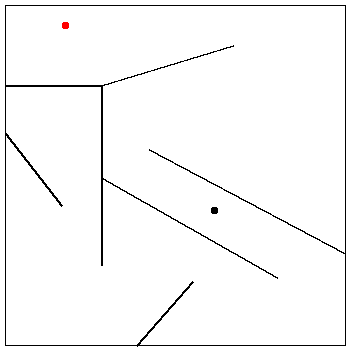

[0.6918157798271959, 1.350157856723568, 2.037769605982715, 0.6763505358853665, 0.6249160125013657, 4.608326112068523, 0.0, 1.0, 0.0, 0.0]
Step 394:


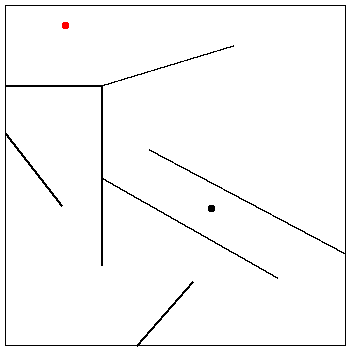

[0.7193520117112538, 1.4038979720937457, 1.9377696059827152, 0.6431598094215083, 0.594249345834699, 4.708326112068523, 0.0, 1.0, 0.0, 0.0]
Step 395:


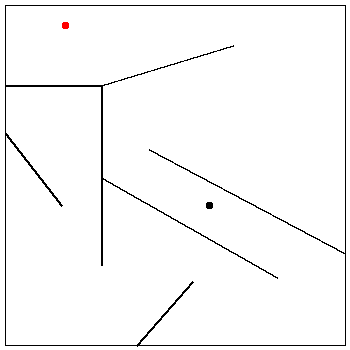

[0.7468882435953123, 1.457638087463923, 1.8377696059827155, 0.6099690829576501, 0.5635826791680323, 4.808326112068523, 0.0, 1.0, 0.0, 0.0]
Step 396:


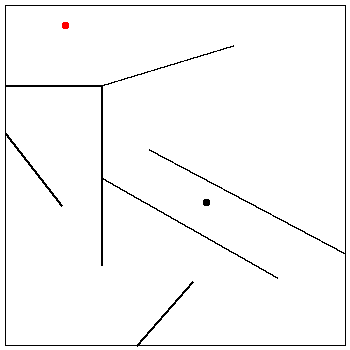

[0.7744244754793701, 1.5113782028341003, 1.7377696059827155, 0.5767783564937918, 0.5329160125013656, 4.908326112068523, 0.0, 1.0, 0.0, 0.0]
Step 397:


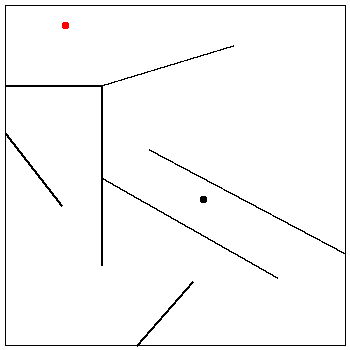

[0.801960707363428, 1.565118318204278, 1.6377696059827156, 0.5435876300299336, 0.5022493458346988, 5.008326112068523, 0.0, 1.0, 0.0, 0.0]
Step 398:


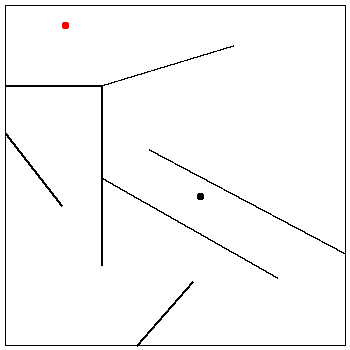

[0.8294969392474857, 1.6188584335744554, 1.5377696059827157, 0.5103969035660754, 0.47158267916803276, 5.108326112068522, 0.0, 1.0, 0.0, 0.0]
Step 399:


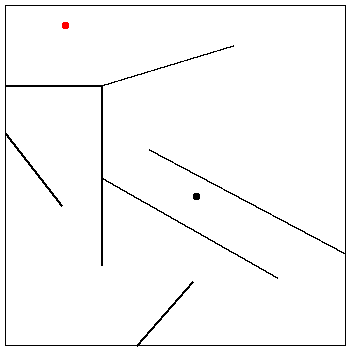

[0.8629877463491225, 0.7782573174223739, 1.5188584335744557, 3.376955262170047, 0.5634581280558706, 1.06190185672068, 0.0, 0.0, 1.0, 0.0]
Step 400:


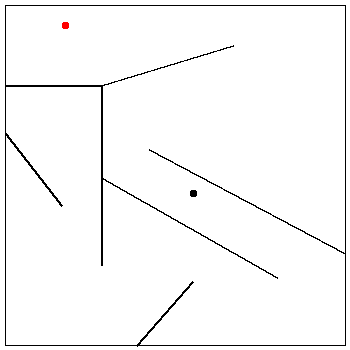

[0.8057935493064319, 1.5725985489446335, 3.2769552621700475, 0.5302674015920124, 0.48994208266363365, 2.9263028895865135, 0.0, 1.0, 0.0, 0.0]
Timeout at 400 steps:


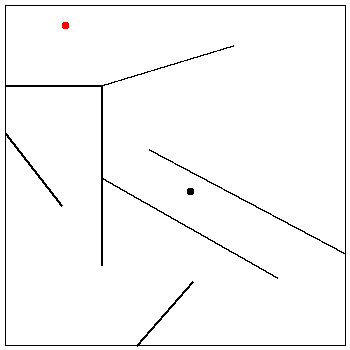

In [ ]:
#runSimulation(hardMaze, goStraight)
runSimulation(hardMaze, goStraightAvoid)
#runSimulation(hardMaze, randomController)
#runSimulation(hardMaze, ANNcontroller)